# Rocket Control

## Rocket Sprite

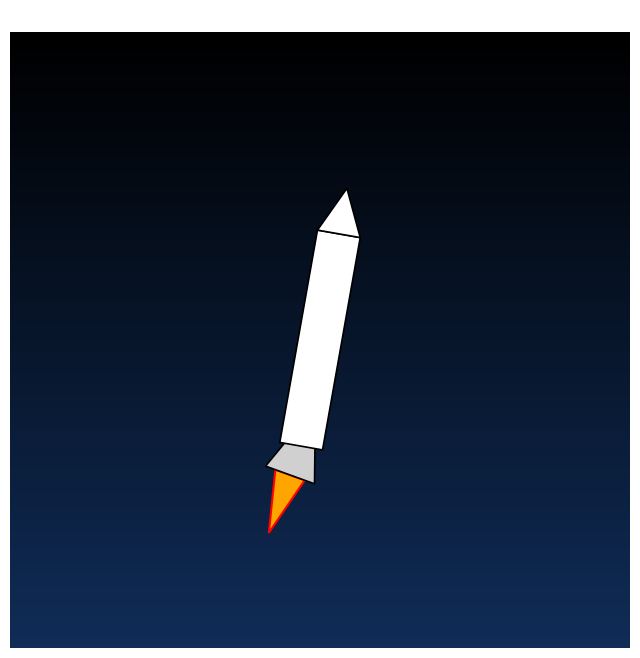

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colors import LinearSegmentedColormap

def rotate_point(x, y, pivot_x, pivot_y, angle_deg):
    """Rotates a point around a pivot by a given angle in degrees."""
    angle_rad = np.radians(angle_deg)
    nx, ny = x - pivot_x, y - pivot_y
    s, c = np.sin(-angle_rad), np.cos(-angle_rad)
    rx = nx * c - ny * s
    ry = nx * s + ny * c
    return rx + pivot_x, ry + pivot_y

def get_rotated_points(points_list, pivot, angle):
    return [rotate_point(p[0], p[1], pivot[0], pivot[1], angle) for p in points_list]

# Setup 
pivot = (0, 0)
rocket_height = 70
rocket_width = rocket_height / 10
nose_height = 15
engine_height = 10
engine_width_bottom = rocket_width * 1.2
engine_width_top = rocket_width * 0.65

# Flame variables
flame_height = 20  # Adjust for "throttle"
flame_width = engine_width_bottom * 0.6

# Inputs
body_tilt = float(input("Enter rocket tilt angle (deg): "))
gimbal_angle = float(input("Enter engine gimbal angle (max +/-10 deg): "))
gimbal_angle = max(-10, min(10, gimbal_angle))

fig, ax = plt.subplots(figsize=(8, 8))
fig_size = rocket_height + 30
ax.set_xlim(-fig_size, fig_size)
ax.set_ylim(-fig_size, fig_size)
ax.set_aspect('equal')
ax.axis('off')

# Gradient Background
custom_cmap = LinearSegmentedColormap.from_list("sky", ["#102C57", "#000000"])
gradient = np.linspace(0, 1, 100).reshape(-1, 1)
ax.imshow(gradient, extent=[-fig_size, fig_size, -fig_size, fig_size], origin='lower', cmap=custom_cmap, aspect='auto')

# 1. Define Raw Coordinates 
body_raw = [[-rocket_width, -rocket_height/2], [rocket_width, -rocket_height/2], 
            [rocket_width, rocket_height/2], [-rocket_width, rocket_height/2]]
nose_raw = [[-rocket_width, rocket_height/2], [rocket_width, rocket_height/2], 
            [0, rocket_height/2 + nose_height]]

# Engine attachment point (on the body)
engine_attach_point = (0, -rocket_height/2 + engine_height*0.1)
skirt_raw = [[-engine_width_bottom, -rocket_height/2 - engine_height], 
             [engine_width_bottom, -rocket_height/2 - engine_height], 
             [engine_width_top, -rocket_height/2 + engine_height*0.1], 
             [-engine_width_top, -rocket_height/2 + engine_height*0.1]]

# Flame Raw (Centered at the base of the engine)
flame_base_y = -rocket_height/2 - engine_height
flame_raw = [[-flame_width, flame_base_y], 
             [flame_width, flame_base_y], 
             [0, flame_base_y - flame_height]]

# 2. Process Rotations (Nested) 
# A. Rotate engine AND flame around the engine attachment point
skirt_gimbaled = get_rotated_points(skirt_raw, engine_attach_point, gimbal_angle)
flame_gimbaled = get_rotated_points(flame_raw, engine_attach_point, gimbal_angle)

# B. Rotate everything around the main body pivot
body_rot = get_rotated_points(body_raw, pivot, body_tilt)
nose_rot = get_rotated_points(nose_raw, pivot, body_tilt)
skirt_final = get_rotated_points(skirt_gimbaled, pivot, body_tilt)
flame_final = get_rotated_points(flame_gimbaled, pivot, body_tilt)

# 3. Draw 
# Flame drawn first so it sits "behind" or flush with the engine
ax.add_patch(Polygon(flame_final, fc='orange', ec='red', lw=1.5, zorder=9))
ax.add_patch(Polygon(skirt_final, fc="#D0D0D0", ec='black', lw=1.2, zorder=10))
ax.add_patch(Polygon(body_rot, fc="#FFFFFF", ec='black', lw=1.2, zorder=11))
ax.add_patch(Polygon(nose_rot, fc="#FFFFFF", ec='black', lw=1.2, zorder=12))

plt.title(f"Body Tilt: {body_tilt}° | Gimbal: {gimbal_angle}°", color='white', fontsize=12)
plt.show()

## Simplified 1D Case: Constant Mass, Full Thrust (No animation, only calculation)
First, let's consider the 1D system of a falling rocket, which can be controlled via a thruster (with a maximum thrust). An initial fuel amount is given. As a simplification, the mass is held constant, which doesn't take into account the continuously burned fuel.

INITIAL CONDITIONS
Initial height: 1000.0 m 
Initial velocity: 10.0 m/s 
Gravity: 9.81 m/s^2 
Dry Mass: 100.0 kg 
Fuel Mass: 400.0 kg 
Total Mass: 500.0 kg 
Maximum Thrust Acceleration: 50.0 m/s^2 
Exhaust Velocity: 150.0 m/s
RESULTS
Can land optimally using approx 259.21 kg of fuel (156.63 m/s delta-v).
Coast for 11.81 seconds, then full thrust for 3.13 seconds.
Simulation confirms soft landing.


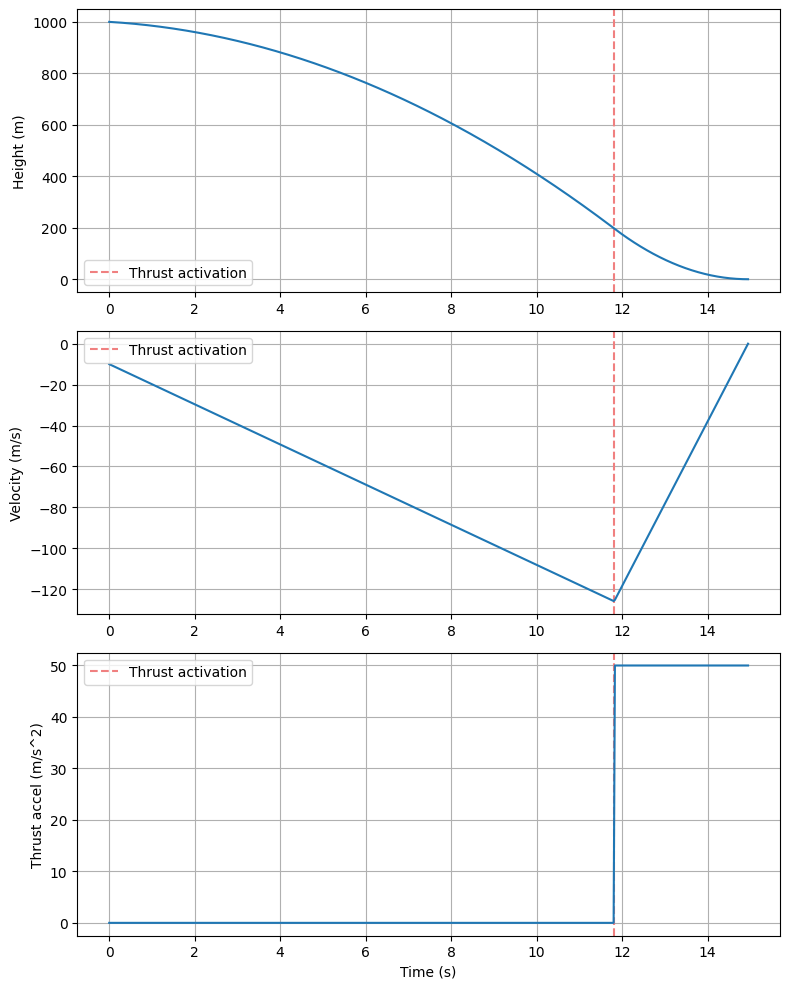

In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt

# User inputs
h0 = float(input("Initial height (m): "))
initial_velocity_down = float(input("Initial downward velocity (m/s): "))
g = float(input("Gravity (m/s^2): "))
dry_mass = float(input("Dry mass (kg): "))
fuel_mass = float(input("Fuel mass (kg): "))
u_max = float(input("Maximum thrust acceleration (m/s^2): "))
v_e = float(input("Exhaust velocity (m/s): "))

# print initial condition summary
print("="*70)
print("INITIAL CONDITIONS")
print("="*70)
print(f"Initial height: {h0} m \nInitial velocity: {initial_velocity_down} m/s \n" + 
      f"Gravity: {g} m/s^2 \nDry Mass: {dry_mass} kg \nFuel Mass: {fuel_mass} kg \n" +
      f"Total Mass: {dry_mass + fuel_mass} kg \nMaximum Thrust Acceleration: {u_max} m/s^2 \n" + 
      f"Exhaust Velocity: {v_e} m/s")
print("="*70)
print("RESULTS")
print("="*70)

# Derived
m0 = dry_mass + fuel_mass
fuel_amount = v_e * math.log(m0 / dry_mass) if fuel_mass > 0 else 0  # Available delta-v

# Set conventions: positive upwards
v0 = -initial_velocity_down  # v0 < 0 for downward

if u_max <= g:
    print("Cannot land: maximum thrust acceleration must at least exceed gravity.")
else:
    a_net = u_max - g
    h_req_initial = 0.5 * (-v0)**2 / a_net
    if h0 < h_req_initial:
        print("Cannot land: initial height too low for the velocity.")
    else:
        # Solve quadratic for coast time
        A = -g * u_max
        B = 2 * v0 * u_max
        C = 2 * a_net * h0 - v0**2
        D = B**2 - 4 * A * C
        if D < 0:
            print("No real solution (unexpected).")
        else:
            sqrt_D = math.sqrt(D)
            t1 = (-B + sqrt_D) / (2 * A)
            t2 = (-B - sqrt_D) / (2 * A)
            candidates = [t for t in [t1, t2] if t >= 0]
            if not candidates:
                print("No positive coast time solution.")
            else:
                t_coast = min(candidates)  # The earliest valid time to start burn
                v_b = v0 - g * t_coast
                y_b = h0 + v0 * t_coast - 0.5 * g * t_coast**2
                t_burn = -v_b / a_net
                fuel_used = u_max * t_burn
                if fuel_used > fuel_amount:
                    print(f"Not enough fuel: requires {fuel_used:.2f} m/s delta-v, but only {fuel_amount:.2f} available.")
                else:
                    # Approximate fuel mass used (for info, since constant mass model)
                    fuel_used_kg_approx = fuel_mass * (1 - math.exp(-fuel_used / v_e))
                    print(f"Can land optimally using approx {fuel_used_kg_approx:.2f} kg of fuel ({fuel_used:.2f} m/s delta-v).")
                    print(f"Coast for {t_coast:.2f} seconds, then full thrust for {t_burn:.2f} seconds.")

                    # Simulate and plot the trajectory
                    t_total = t_coast + t_burn
                    times = np.linspace(0, t_total, 500)
                    heights = []
                    velocities = []
                    thrusts = []
                    for t in times:
                        if t <= t_coast:
                            thrust = 0
                            height = h0 + v0 * t - 0.5 * g * t**2
                            velocity = v0 - g * t
                        else:
                            t_rel = t - t_coast
                            thrust = u_max
                            height = y_b + v_b * t_rel + 0.5 * (u_max - g) * t_rel**2
                            velocity = v_b + (u_max - g) * t_rel
                        heights.append(height)
                        velocities.append(velocity)
                        thrusts.append(thrust)

                    # Verify landing
                    if abs(heights[-1]) < 1e-6 and abs(velocities[-1]) < 1e-6:
                        print("Simulation confirms soft landing.")
                    else:
                        print("Simulation error in landing conditions.")

                    # Plot
                    fig, axs = plt.subplots(3, 1, figsize=(8, 10))
                    axs[0].axvline(x=t_coast, color="lightcoral", linestyle="--", label="Thrust activation")
                    axs[0].plot(times, heights)
                    axs[0].set_ylabel('Height (m)')
                    axs[0].grid(True)
                    axs[0].legend()
                    axs[1].axvline(x=t_coast, color="lightcoral", linestyle="--", label="Thrust activation")
                    axs[1].plot(times, velocities)
                    axs[1].set_ylabel('Velocity (m/s)')
                    axs[1].grid(True)
                    axs[1].legend()
                    axs[2].axvline(x=t_coast, color="lightcoral", linestyle="--", label="Thrust activation")
                    axs[2].plot(times, thrusts)
                    axs[2].set_ylabel('Thrust accel (m/s^2)')
                    axs[2].set_xlabel('Time (s)')
                    axs[2].grid(True)
                    axs[2].legend()
                    plt.tight_layout()
                    plt.show()

## The 1D, Time-Dependent Mass Case
Let's now consider how the mass changes along the trajectory as the rocket burns fuel, using the Tsiolkovsky rocket equation:

$$\dot{h} = v, \quad \dot{v} = \frac{T}{m} - g, \quad \dot{m} = -\frac{T}{v_e}$$

INITIAL CONDITIONS
Initial height: 400.0 m 
Initial velocity: 50.0 m/s 
Gravity: 9.81 m/s^2 
Dry Mass: 100.0 kg 
Fuel Mass: 400.0 kg 
Total Mass: 500.0 kg 
Maximum Thrust Acceleration: 50.0 m/s^2 
Exhaust Velocity: 150.0 m/s
RESULTS
Can land optimally using 257.67 kg of fuel.
Coast for 4.43 seconds, then full thrust for 1.55 seconds.
Simulation confirms soft landing.


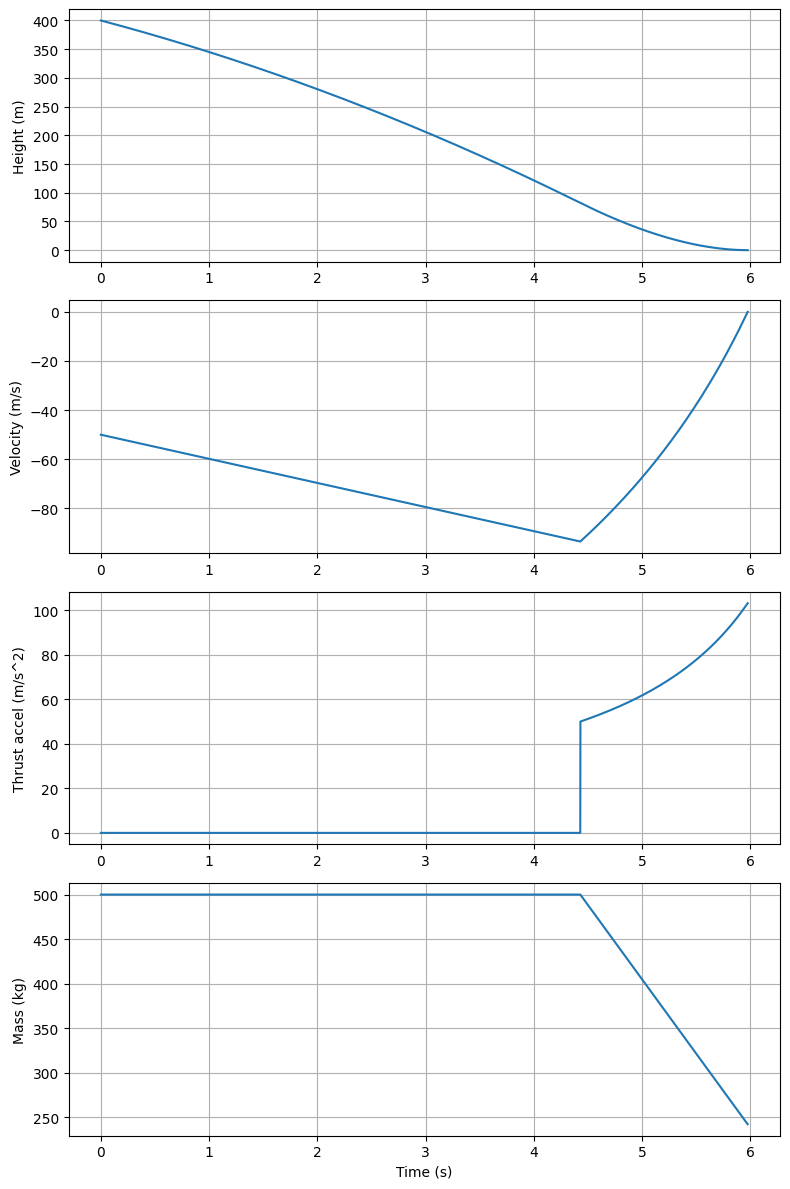

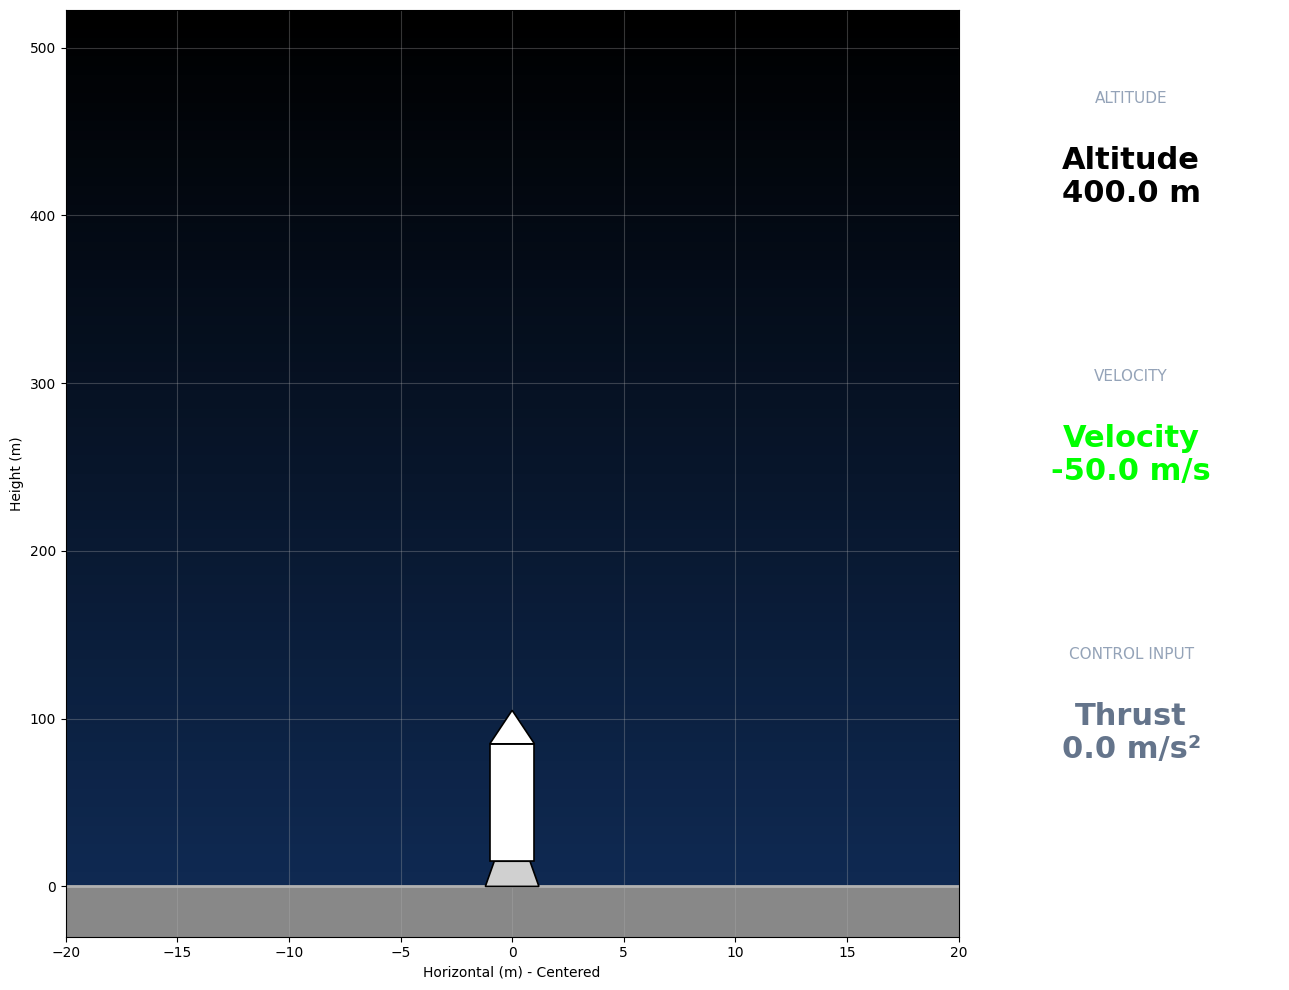

Animation saved as 'rocket_landing.mp4'


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle, Polygon
from matplotlib.colors import LinearSegmentedColormap

# User inputs
h0 = float(input("Initial height (m): "))
initial_velocity_down = float(input("Initial downward velocity (m/s): "))
g = float(input("Gravity (m/s^2): "))
dry_mass = float(input("Dry mass (kg): "))
fuel_mass = float(input("Fuel mass (kg): "))
u_max = float(input("Maximum initial thrust acceleration (m/s^2): "))
v_e = float(input("Exhaust velocity (m/s): "))

# print initial condition summary
print("="*70)
print("INITIAL CONDITIONS")
print("="*70)
print(f"Initial height: {h0} m \nInitial velocity: {initial_velocity_down} m/s \n" + 
      f"Gravity: {g} m/s^2 \nDry Mass: {dry_mass} kg \nFuel Mass: {fuel_mass} kg \n" +
      f"Total Mass: {dry_mass + fuel_mass} kg \nMaximum Thrust Acceleration: {u_max} m/s^2 \n" + 
      f"Exhaust Velocity: {v_e} m/s")
print("="*70)
print("RESULTS")
print("="*70)

# Derived
m0 = dry_mass + fuel_mass
m_dry = dry_mass
T = u_max * m0  # constant thrust force

# Set conventions: positive upwards
v0 = -initial_velocity_down  # v0 < 0 for downward

if u_max <= g:
    print("Cannot land: maximum initial thrust acceleration must exceed gravity.")
else:
    # Time to impact without thrust
    v_down = initial_velocity_down
    t_max = (v_down + math.sqrt(v_down**2 + 2 * g * h0)) / g

    def get_projected_min_h(h_b, v_b, m_b, T, v_e, g, dt=0.001):
        h = h_b
        v = v_b
        m = m_b
        t = 0.0
        while v < 0:
            if m <= m_dry:
                return -1e6, -1, -1
            a_net = T / m - g
            if a_net <= 0:
                return -1e6, -1, -1
            # Compute dt_step to not overshoot v=0
            dt_step = min(dt, -v / a_net if a_net > 0 else dt)
            v_next = v + a_net * dt_step
            h_next = h + v * dt_step + 0.5 * a_net * dt_step**2
            m_next = m - (T / v_e) * dt_step
            if v_next >= 0:
                # Interpolate
                frac = -v / (v_next - v)
                dt_frac = frac * dt_step
                h_v0 = h + v * dt_frac + 0.5 * a_net * dt_frac**2
                m_v0 = m - (T / v_e) * dt_frac
                t_v0 = t + dt_frac
                return h_v0, t_v0, m_v0
            h = h_next
            v = v_next
            m = m_next
            t += dt_step
        return h, t, m  # Rare case

    def f(t_coast):
        if t_coast >= t_max:
            return -1e6
        v_b = v0 - g * t_coast
        h_b = h0 + v0 * t_coast - 0.5 * g * t_coast**2
        if h_b <= 0:
            return -1e6
        return get_projected_min_h(h_b, v_b, m0, T, v_e, g)[0]

    # Check if possible
    if f(0) <= 0:
        print("Cannot land: even immediate full thrust cannot stop in time.")
    else:
        # Bisection to find t_coast where f(t_coast) = 0
        low = 0.0
        high = t_max
        for _ in range(100):  # Sufficient for precision
            mid = (low + high) / 2
            if f(mid) > 0:
                low = mid
            else:
                high = mid
        t_coast = (low + high) / 2
        v_b = v0 - g * t_coast
        h_b = h0 + v0 * t_coast - 0.5 * g * t_coast**2
        h_v0, t_burn, m_final = get_projected_min_h(h_b, v_b, m0, T, v_e, g)
        if abs(h_v0) > 0.1:  # Tolerance
            print("Cannot land precisely: check parameters or increase precision.")
        else:
            fuel_used = m0 - m_final
            if fuel_used > fuel_mass:
                print(f"Not enough fuel: requires {fuel_used:.2f} kg, but only {fuel_mass:.2f} kg available.")
            else:
                print(f"Can land optimally using {fuel_used:.2f} kg of fuel.")
                print(f"Coast for {t_coast:.2f} seconds, then full thrust for {t_burn:.2f} seconds.")

                # Simulate and plot the trajectory numerically for accuracy
                dt = 0.001
                times = []
                heights = []
                velocities = []
                thrusts = []
                masses = []

                # Coast phase
                t = 0.0
                while t < t_coast:
                    height = h0 + v0 * t - 0.5 * g * t**2
                    velocity = v0 - g * t
                    times.append(t)
                    heights.append(height)
                    velocities.append(velocity)
                    thrusts.append(0)
                    masses.append(m0)
                    t += dt

                # Burn phase
                h = h_b
                v = v_b
                m = m0
                t = t_coast
                while t < t_coast + t_burn + dt:  # Slight overrun to ensure
                    times.append(t)
                    heights.append(h)
                    velocities.append(v)
                    thrust_accel = T / m if m > m_dry else 0
                    thrusts.append(thrust_accel)
                    masses.append(m)
                    a_net = thrust_accel - g
                    dt_step = min(dt, t_coast + t_burn - t) if t_coast + t_burn - t > 0 else dt
                    h_next = h + v * dt_step + 0.5 * a_net * dt_step**2
                    v_next = v + a_net * dt_step
                    m_next = m - (T / v_e) * dt_step if thrust_accel > 0 else m
                    h = h_next
                    v = v_next
                    m = m_next
                    t += dt_step

                # Verify landing
                if abs(heights[-1]) < 1e-1 and abs(velocities[-1]) < 1e-1:
                    print("Simulation confirms soft landing.")
                else:
                    print(f"Simulation landing conditions: h={heights[-1]:.2f}, v={velocities[-1]:.2f} (minor error due to dt).")

                # Static plots (optional, kept for reference)
                fig_static, axs = plt.subplots(4, 1, figsize=(8, 12))
                axs[0].plot(times, heights)
                axs[0].set_ylabel('Height (m)')
                axs[0].grid(True)
                axs[1].plot(times, velocities)
                axs[1].set_ylabel('Velocity (m/s)')
                axs[1].grid(True)
                axs[2].plot(times, thrusts)
                axs[2].set_ylabel('Thrust accel (m/s^2)')
                axs[2].grid(True)
                axs[3].plot(times, masses)
                axs[3].set_ylabel('Mass (kg)')
                axs[3].set_xlabel('Time (s)')
                axs[3].grid(True)
                plt.tight_layout()
                plt.show()

                # ====================== ANIMATION SETUP ======================
                rocket_height = 70
                skip = max(1, len(times) // 500)
                times_anim = times[::skip]
                heights_anim = heights[::skip]
                velocities_anim = velocities[::skip]      # ← NEW
                thrusts_anim = thrusts[::skip]

                # Create figure with two panels: animation + telemetry
                fig_anim, (ax, ax_info) = plt.subplots(
                    1, 2, figsize=(13, 10), dpi=100,
                    gridspec_kw={'width_ratios': [3, 1]}
                )

                ax.set_xlim(-20, 20)
                y_min = -30
                y_max = max(heights) + 1.75 * rocket_height
                ax.set_ylim(y_min, y_max)
                ax.set_xlabel('Horizontal (m) - Centered')
                ax.set_ylabel('Height (m)')

                # Gradient background
                top_color    = "#102C57"    
                bottom_color = "#000000"    
                custom_cmap = LinearSegmentedColormap.from_list("mygradient", [top_color, bottom_color])
                gradient = np.linspace(0, 1, 100).reshape(-1, 1)
                ax.imshow(gradient, extent=[-20, 20, y_min, y_max],
                          origin='lower', cmap=custom_cmap,
                          aspect='auto', alpha=1, zorder=0)

                # Ground
                surface = ax.axhspan(y_min, 0, xmin=0, xmax=1, color="#888888", zorder=1)
                surface_line = ax.axhline(0, xmin=0, xmax=1, color="#B1B1B1", linewidth=2, zorder=2)
                ax.grid(True, alpha=0.3, zorder=3)

                # Rocket parts (same as before, with zorder)
                rocket_body = Rectangle((-1, 15), 2, rocket_height, 
                                        fc="#FFFFFF", ec='black', lw=1.2, zorder=11)
                ax.add_patch(rocket_body)

                trapezoid_points = [[-1.2, 0], [1.2, 0], [0.8, 15], [-0.8, 15]]
                engine_skirt = Polygon(trapezoid_points, closed=True,
                                       fc="#D0D0D0", ec='black', lw=1.2, zorder=10)
                ax.add_patch(engine_skirt)

                rocket_nose = Polygon([[-1, rocket_height + 15],
                                       [1, rocket_height + 15],
                                       [0, rocket_height + 35]],
                                      closed=True, fc="#FFFFFF", ec='black', lw=1.2, zorder=12)
                ax.add_patch(rocket_nose)

                flame = Polygon([[-1, 0], [1, 0], [0, -20]],
                                fc='orange', ec='red', visible=False, zorder=20)
                ax.add_patch(flame)

                # ====================== TELEMETRY PANEL ======================
                ax_info.set_facecolor('#0f172a')
                ax_info.axis('off')
                # ax_info.set_title('LIVE TELEMETRY', color='black', fontsize=16, pad=40, fontweight='bold')

                # Text objects
                height_text = ax_info.text(0.5, 0.82, f"Altitude\n{heights_anim[0]:,.1f} m",
                                           ha='center', va='center', fontsize=22,
                                           color='black', fontweight='bold')

                velocity_text = ax_info.text(0.5, 0.52, f"Velocity\n{velocities_anim[0]:+.1f} m/s",
                                             ha='center', va='center', fontsize=22,
                                             color='lime', fontweight='bold')

                thrust_text = ax_info.text(0.5, 0.22, f"Thrust\n{thrusts_anim[0]:.1f} m/s²",
                                           ha='center', va='center', fontsize=22,
                                           color='#64748b', fontweight='bold')

                # Small labels
                ax_info.text(0.5, 0.90, "ALTITUDE", ha='center', fontsize=11, color='#94a3b8')
                ax_info.text(0.5, 0.60, "VELOCITY", ha='center', fontsize=11, color='#94a3b8')
                ax_info.text(0.5, 0.30, "CONTROL INPUT", ha='center', fontsize=11, color='#94a3b8')

                # ====================== ANIMATION FUNCTIONS ======================
                def init():
                    rocket_body.set_y(15)
                    rocket_nose.xy = [[-1, rocket_height + 15],
                                      [1, rocket_height + 15],
                                      [0, rocket_height + 35]]
                    flame.set_visible(False)

                    height_text.set_text(f"Altitude\n{heights_anim[0]:,.1f} m")
                    velocity_text.set_text(f"Velocity\n{velocities_anim[0]:+.1f} m/s")
                    thrust_text.set_text(f"Thrust\n{thrusts_anim[0]:.1f} m/s²")

                    return (rocket_body, rocket_nose, flame, engine_skirt,
                            height_text, velocity_text, thrust_text)

                def animate(i):
                    h = max(0, heights_anim[i])
                    v = velocities_anim[i]
                    thrust = thrusts_anim[i]

                    # Update rocket position
                    rocket_body.set_y(h + 15)
                    rocket_nose.xy = [[-1, h + rocket_height + 15],
                                      [1, h + rocket_height + 15],
                                      [0, h + rocket_height + 35]]
                    engine_skirt.set_xy([[-1.2, h], [1.2, h],
                                         [0.8, h + 15], [-0.8, h + 15]])

                    # Flame
                    if thrust > 0 and i != len(times_anim) - 1:
                        flame.set_visible(True)
                        flame.xy = [[-1, h], [1, h],
                                    [0, h - 5 - (thrust / u_max) * 5]]
                    else:
                        flame.set_visible(False)

                    # Update telemetry
                    height_text.set_text(f"Altitude\n{h:,.1f} m")

                    velocity_text.set_text(f"Velocity\n{v:+.1f} m/s")
                    velocity_text.set_color('black')

                    thrust_text.set_text(f"Thrust\n{thrust:.1f} m/s²")
                    thrust_text.set_color('black')

                    return (rocket_body, rocket_nose, flame, engine_skirt,
                            height_text, velocity_text, thrust_text)

                ani = FuncAnimation(fig_anim, animate, init_func=init,
                                    frames=len(times_anim), interval=20,
                                    blit=True, repeat=True)

                plt.tight_layout()
                plt.show()

                # Save animation
                ani.save('results/rocket_landing.mp4', writer='ffmpeg', fps=90)
                print("Animation saved as 'rocket_landing.mp4'")

As visible in the plots, when we assumed constant mass earlier, we saw a the classic bang-bang behaviour predicted by the PMP arising in the controls. However, when we take into account the decreasing mass during fuel burn, the Thrust force $T$ stays constant, yet, according to Newton,
$$a = \frac{T}{m}.$$

Hence, the Thrust acceleration increases over time, but the control is still bang-bang (constant full throttle after the switching time).

# Attitude Control System (Rotation)

Consider a rocket floating in outer space (in other words, assume the rocket is in a vacuum, with no gravity, no aerodynamic forces). Assume also that the reference frame is fixed to the center of mass of the rocket, such that we only consider the rotational orientation of the rocket in the xy-plane, i.e. the angle between the nose of the rocket and the y-axis (vertical). Assume the thrusters of the rocket are attached to a gimbal which can tilt within $\phi \in [-10\degree, 10\degree]$.

Given initial angle $\theta_0$, an initial angular velocity $\dot{\theta} = \omega$, a target angle $\theta_t$, as well as the dimensions of the rocket (dry mass $m_d$, fuel mass $m_f$, maximum possible thrust $T$ and exhaust velocity $v_e$), is it possible to steer the rocket into the target position $\theta_t$ with zero angular velocity?

If so, which control sequence does so in minimal time $t^*$? (The fuel optimal case is not so interesting here; given the vacuum conditions, it would be a tiny nudge, which causes the rocket to start rotating ever so slowly, and since no external forces act on it, it would spin very slowly until it reached the target position)

This is a classic control problem, with the added challenge of the circular freedom of the state: Any initial angle $\theta_0$ can be steered into the target $\theta_t$ in two ways (clockwise and counterclockwise). The tricky part is deciding which is faster, given the inital angle $\theta_0$, the initial angular velocity $\omega$ and the target angle $\theta_t$.

For simplicity, we may assume that the moment of inertia $I$ of the rocket is that of a rod with the same mass $m$ and height $h$ as the rocket, spinning around its center: $$I = \frac{1}{12}mh^2$$
However, we take into account that the mass changes as fuel is burned, so $\dot{m} \not= 0$. We model the time dependent mass through the Tsiolkovsky equation, $$m(t + \Delta t) = m(t) + \dot{m} \cdot \Delta t = m(t) - \frac{T}{v_e} \Delta t,$$ with discrete time steps $\Delta t$ and a mass burn rate of $\dot{m} = -\frac{T}{v_e}$.

The torque stemming from the tilted gimbal is $$\tau = T \cdot sin(\phi)\cdot l,$$ where $T$ is the Thrust, $\phi$ is the angle of the gimbal, and $l$ is the lever arm, which is the distance from the center of mass of the rocket to the nozzle, so roughly half the height of the rocket, $h/2$. 

The angular acceleration is given by $$\alpha(t) = \frac{\tau}{I(t)} = \frac{12\cdot T \cdot sin(\phi(t))\cdot l}{m(t)\cdot h^2}$$ where $m(t)$ is the current total mass (dry mass + fuel mass) at time $t$. Using discrete time steps $\Delta t$ and Euler integration, we obtain $$\omega(t + \Delta t) = \omega(t) + \alpha(t) \cdot \Delta t$$ as well as $$\theta(t + \Delta t) = \theta(t) + \omega(t) \cdot \Delta t.$$ 
As we will see later, the time-optimal controls are (as predicted by theory) bang-bang controls, which means that the control parameter $\phi(t)$ takes on only the extreme points of the control parameters, $\{-10\degree, 10\degree\}$ as values, with near instant switches between the states. The thrust will also be bang-bang, so either full thrust or no thrust at all. This may not be fuel-efficient, but it is time-efficient.

The guidance law is a smoothed bang-bang / near-time-optimal controller approximating a parabolic switching curve in the phase plane $  (\theta, \omega)  $.
It tries to follow
$$\omega_\text{command} \approx \text{sign}(\text{error}) \sqrt{2 \cdot \alpha_\text{max} \cdot |\text{error}|}$$
which is the equation of the minimum-time switching curve for bounded acceleration.

Note that because inertia decreases over time, the true time-optimal gimbal profile is more complex than pure bang-bang with a fixed switching curve; the simulation uses a constant-acceleration approximation that is close to optimal for short maneuvers.

## Shifting COM and more realistic Inertia (Rotation Only)

Using short path.
System is controllable. Proceeding to simulation...
Final stopping time: 6.69 s


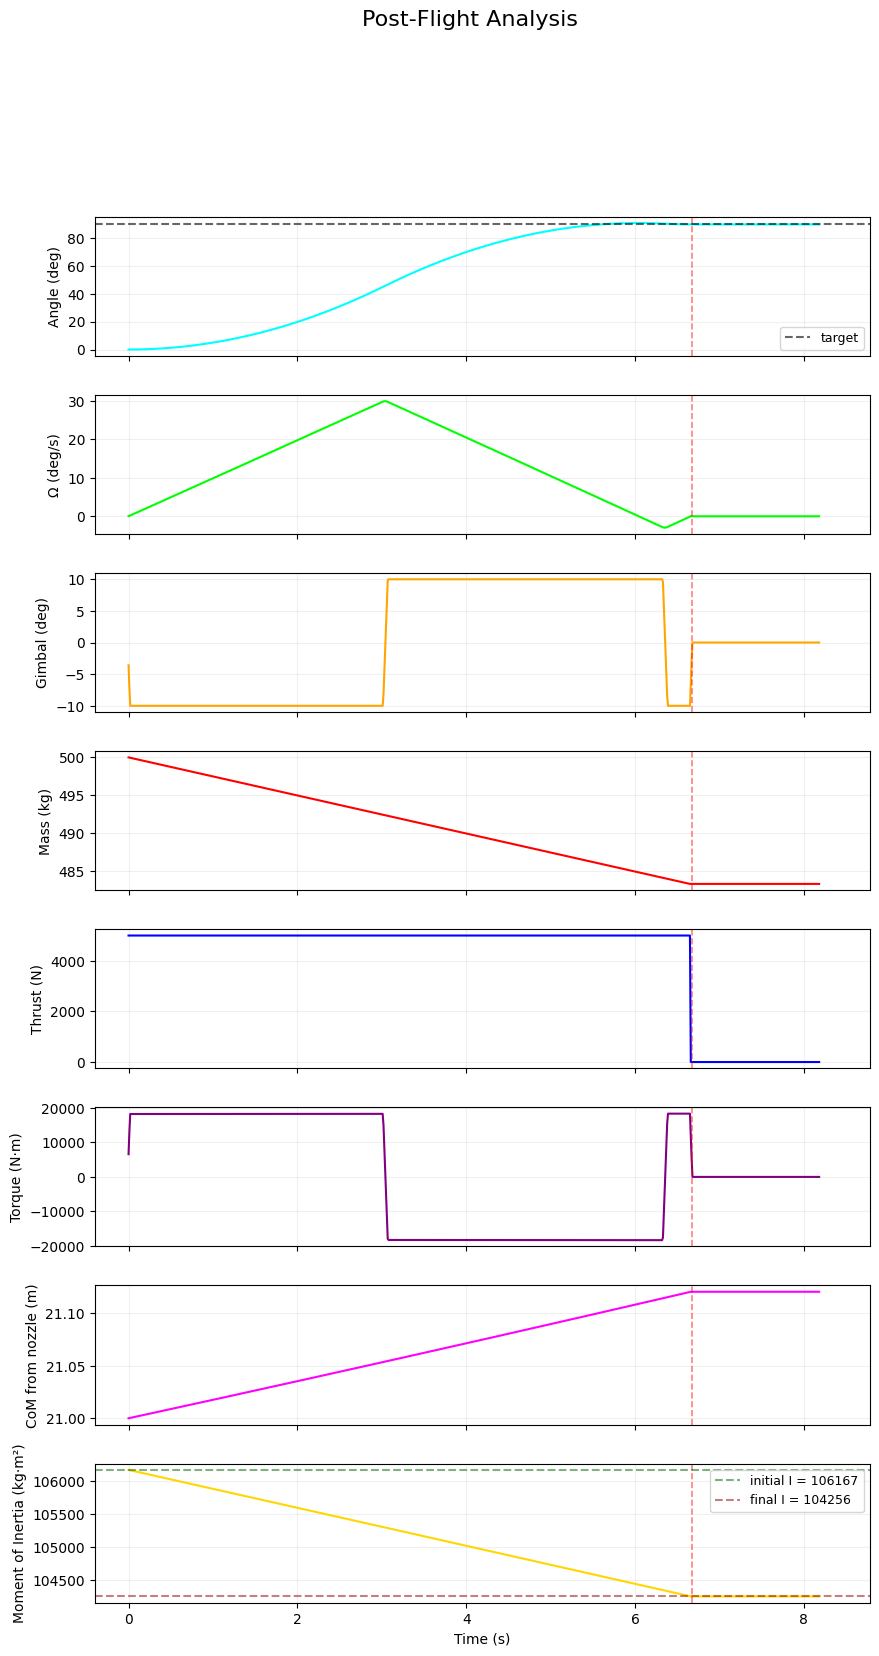

Saving telemetry-enhanced animation...
Done.


In [ ]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.patches import Polygon, FancyArrowPatch
from matplotlib.colors import LinearSegmentedColormap

# Physics & Geometry Helpers
def wrap_angle(a):
    """Wraps angle to [-180, 180] (0=up, 180=down, [0, 180] = right halfplane, [0, -180] = left halfplane)."""
    return (a + 180) % 360 - 180

# for animating rotating objects
def rotate_point(x, y, pivot_x, pivot_y, angle_deg):
    angle_rad = np.radians(angle_deg)
    nx, ny = x - pivot_x, y - pivot_y
    s, c = np.sin(-angle_rad), np.cos(-angle_rad)
    rx = nx * c - ny * s
    ry = nx * s + ny * c
    return rx + pivot_x, ry + pivot_y

def get_rotated_points(points_list, pivot, angle):
    return [rotate_point(p[0], p[1], pivot[0], pivot[1], angle) for p in points_list]

# Function to calculate CoM and I
def calculate_com_and_I(curr_mass, fuel_remaining, dry_mass, rocket_height, fuel_tank_height, dry_cm_from_nozzle, fuel_cm_from_nozzle):
    com_from_nozzle = (dry_mass * dry_cm_from_nozzle + fuel_remaining * fuel_cm_from_nozzle) / curr_mass
    
    # Dry mass: assumed uniform over rocket_height
    I_dry_cm = (1/12) * dry_mass * rocket_height**2
    dry_distance = dry_cm_from_nozzle - com_from_nozzle
    I_dry = I_dry_cm + dry_mass * dry_distance**2
    
    # Fuel: assumed uniform over fuel_tank_height
    I_fuel_cm = (1/12) * fuel_remaining * fuel_tank_height**2
    fuel_distance = fuel_cm_from_nozzle - com_from_nozzle
    I_fuel = I_fuel_cm + fuel_remaining * fuel_distance**2
    
    I = I_dry + I_fuel
    return com_from_nozzle, I

# User Inputs
theta_0 = wrap_angle(float(input("Initial angle (deg): ")))
theta_target = wrap_angle(float(input("Target angle (deg): ")))
omega_0 = float(input("Initial angular velocity (deg/s): "))
dry_mass = float(input("Dry mass (kg): "))
fuel_mass = float(input("Fuel mass (kg): "))
thrust_force = float(input("Thrust Force (N): "))
v_e = float(input("Exhaust velocity (m/s): "))

# Rocket Specs
rocket_height = 70
rocket_width = 7
nose_height = 15
engine_height = 10
gimbal_limit = 10.0
max_gimbal_speed = 360.0

# Rough geometry for CoM and I
fuel_tank_height = rocket_height / 2  # Fuel in lower half
fuel_cm_from_nozzle = fuel_tank_height / 2
dry_cm_from_nozzle = rocket_height / 2  # Dry mass uniform along height

# Controllability Check 
initial_mass = dry_mass + fuel_mass
initial_com, initial_I = calculate_com_and_I(initial_mass, fuel_mass, dry_mass, rocket_height, fuel_tank_height, dry_cm_from_nozzle, fuel_cm_from_nozzle)
max_alpha_possible = np.degrees((thrust_force * np.sin(np.radians(gimbal_limit)) * initial_com) / initial_I)
stopping_time = abs(omega_0) / max_alpha_possible if max_alpha_possible > 0 else 0
fuel_burn_rate = thrust_force / v_e
fuel_needed = fuel_burn_rate * stopping_time

if fuel_needed > fuel_mass:
    print("WARNING: System is NOT controllable. Not enough fuel to stop initial rotation!")
    sys.exit("Aborting simulation.")

short_error = wrap_angle(theta_target - theta_0)
stopping_dist = (omega_0**2) / (2 * max_alpha_possible) if max_alpha_possible > 0 else 9999999
use_wrap = True
effective_target = theta_target
if np.sign(omega_0) != np.sign(short_error) and stopping_dist > abs(short_error):
    # Commit to long path
    use_wrap = False
    effective_target = theta_0 + (short_error - 360 * np.sign(short_error))
    print("Using long path for optimality (effective target: {:.2f}°)".format(effective_target))
else:
    print("Using short path.")

effective_error = abs(effective_target - theta_0)
maneuver_time_est = 2 * np.sqrt(effective_error / max_alpha_possible) if max_alpha_possible > 0 else 0
fuel_maneuver_est = fuel_burn_rate * maneuver_time_est

fuel_stop_est = 0
if np.sign(omega_0) != np.sign(effective_target - theta_0):
    fuel_stop_est = fuel_burn_rate * abs(omega_0) / max_alpha_possible if max_alpha_possible > 0 else 0

fuel_needed = fuel_maneuver_est + fuel_stop_est

if fuel_needed > fuel_mass:
    print("WARNING: System is NOT controllable. Not enough fuel to reach the target!")
    sys.exit("Aborting simulation.")
else:
    print("System is controllable. Proceeding to simulation...")

# Simulation Logic 
dt = 0.01  
times, angles, omegas, gimbals, masses, thrusts, torques, coms, Is = [], [], [], [], [], [], [], [], []

curr_theta = theta_0
curr_omega = omega_0
curr_gimbal = 0.0
curr_mass = dry_mass + fuel_mass

t = 0
running = True
settled = False
while running and t < 40: 
    fuel_remaining = max(curr_mass - dry_mass, 0)
    com_from_nozzle, I = calculate_com_and_I(
        curr_mass, fuel_remaining, dry_mass, rocket_height,
        fuel_tank_height, dry_cm_from_nozzle, fuel_cm_from_nozzle
    )
    lever_arm = com_from_nozzle
    max_alpha = np.degrees((thrust_force * np.sin(np.radians(gimbal_limit)) * lever_arm) / I)
    
    # Smoothed Circular Control Logic 
    if use_wrap:
        error = wrap_angle(effective_target - curr_theta)
    else:
        error = effective_target - curr_theta
    target_omega = np.sign(error) * np.sqrt(2 * max_alpha * abs(error))
    switch_error = target_omega - curr_omega
    
    boundary = 0.2 # smaller = snappier; larger = smoother; the closer it is to zero, the closer the control is to being 100% bang-bang
    if abs(switch_error) > boundary:
        target_gimbal_cmd = -np.sign(switch_error) * gimbal_limit
    else:
        target_gimbal_cmd = -(switch_error / boundary) * gimbal_limit

    # Settling Logic
    active_thrust = True
    if abs(error) < 0.2 and abs(curr_omega) < 0.2:
        target_gimbal_cmd = 0.0
        curr_omega = 0.0
        active_thrust = False
        settled = True

    # Slew Rate Logic
    gimbal_err = target_gimbal_cmd - curr_gimbal
    if abs(gimbal_err) > 0.01:
        step = np.sign(gimbal_err) * max_gimbal_speed * dt
        curr_gimbal += np.clip(step, -abs(gimbal_err), abs(gimbal_err))

    # Physics Integration
    torque = -thrust_force * np.sin(np.radians(curr_gimbal)) * lever_arm
    alpha = np.degrees(torque / I)
    
    curr_omega += alpha * dt
    curr_theta += curr_omega * dt
    
    current_thrust = thrust_force if active_thrust else 0.0
    if active_thrust:
        curr_mass -= (current_thrust / v_e) * dt
    
    # Store everything
    times.append(t)
    angles.append(wrap_angle(curr_theta))
    omegas.append(curr_omega)
    gimbals.append(curr_gimbal)
    masses.append(curr_mass)
    thrusts.append(current_thrust)
    torques.append(torque)
    coms.append(com_from_nozzle)
    Is.append(I)          
    
    t += dt
    if (settled and abs(curr_gimbal) < 0.01) or curr_mass <= dry_mass:
        running = False

# Post-settle hold for visualization
for _ in range(int(1.5/dt)):
    times.append(times[-1] + dt); angles.append(wrap_angle(curr_theta)); omegas.append(0.0)
    gimbals.append(0.0); masses.append(masses[-1]); thrusts.append(0.0); torques.append(0.0)
    coms.append(coms[-1])
    Is.append(Is[-1])

print(f"Final stopping time: {t:.2f} s")

# Diagnostic Plots 
fig_diag, axs = plt.subplots(8, 1, figsize=(10, 18), sharex=True)
plt.subplots_adjust(hspace=0.28)

plot_data = [angles, omegas, gimbals, masses, thrusts, torques, coms, Is]
labels = [
    'Angle (deg)',
    'Ω (deg/s)',
    'Gimbal (deg)',
    'Mass (kg)',
    'Thrust (N)',
    'Torque (N·m)',
    'CoM from nozzle (m)',
    'Moment of Inertia (kg·m²)'
]
colors = ['cyan', 'lime', 'orange', 'red', 'blue', 'purple', 'magenta', 'gold']

for i, ax in enumerate(axs):
    ax.plot(times, plot_data[i], color=colors[i])
    ax.set_ylabel(labels[i])
    ax.set_facecolor("#ffffff")
    ax.grid(True, alpha=0.18)
    ax.set_xlim(-0.4, times[-1] + 0.6)
    ax.axvline(t - dt, color="red", linestyle="--", alpha=0.5, lw=1.2)

# ─── Angle plot extras ────────────────────────────────────────
axs[0].axhline(theta_target, color='black', linestyle='--', alpha=0.6, label="target")
axs[0].legend(fontsize=9)

"""
# ─── CoM plot extras ──────────────────────────────────────────
axs[6].axhline(0, color='gray', ls=':', alpha=0.5, label="nozzle")
axs[6].axhline(rocket_height, color='gray', ls='--', alpha=0.5, label="nose tip")
axs[6].axhline(rocket_height / 2, color='darkgray', ls='-.', alpha=0.4, label="geometric center")
axs[6].set_ylim(0, rocket_height * 1.05)
axs[6].legend(fontsize=9, loc='lower right')"""

# ─── I plot extras ────────────────────────────────────────────
axs[7].axhline(Is[0], color='darkgreen', ls='--', alpha=0.5, label=f"initial I = {Is[0]:.0f}")
if len(Is) > 1:
    axs[7].axhline(Is[-1], color='darkred', ls='--', alpha=0.5, label=f"final I = {Is[-1]:.0f}")
axs[7].legend(fontsize=9, loc='upper right')

axs[-1].set_xlabel("Time (s)")

plt.suptitle("Post-Flight Analysis", fontsize=16, y=0.995)
plt.show()

# Animation Setup 
fig, (ax, ax_info) = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [2, 1]})
fig_size = rocket_height + 40
ax.set_xlim(-fig_size, fig_size); ax.set_ylim(-fig_size, fig_size)
ax.set_aspect('equal'); ax.axis('off')

custom_cmap = LinearSegmentedColormap.from_list("sky", ["#102C57", "#000000"])
ax.imshow(np.linspace(0, 1, 100).reshape(-1, 1), extent=[-fig_size, fig_size, -fig_size, fig_size], origin='lower', cmap=custom_cmap, aspect='auto')

body_patch = Polygon([(0,0)], fc="white", ec="black", zorder=11)
nose_patch = Polygon([(0,0)], fc="white", ec="black", zorder=12)
engine_patch = Polygon([(0,0)], fc="#D0D0D0", ec="black", zorder=10)
flame_patch = Polygon([(0,0)], fc="orange", ec="red", lw=1.5, zorder=9)
initial_line, = ax.plot([], [], color='red', linestyle='--', alpha=0.6, zorder=5, label="Initial Angle") # Initial Angle indicator
target_line, = ax.plot([], [], color='green', linestyle='--', alpha=0.7, zorder=5, label="Target Angle") # Target indicator
for p in [body_patch, nose_patch, engine_patch, flame_patch]: ax.add_patch(p)

# Set static lines
rad1 = np.radians(theta_0)
initial_line.set_data([0, 80*np.sin(rad1)], [0, 80*np.cos(rad1)])
rad2 = np.radians(theta_target)
target_line.set_data([0, 80*np.sin(rad2)], [0, 80*np.cos(rad2)])

ax_info.set_facecolor('white'); ax_info.axis('off')
left_bound = -0.2
fontsize = 15
txt_angle  = ax_info.text(left_bound, 0.8, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
txt_omega  = ax_info.text(left_bound, 0.7, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
txt_gimbal = ax_info.text(left_bound, 0.6, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
txt_thrust = ax_info.text(left_bound, 0.5, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
txt_fuel   = ax_info.text(left_bound, 0.4, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
txt_burned = ax_info.text(left_bound, 0.3, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
txt_torque = ax_info.text(left_bound, 0.2, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
txt_time   = ax_info.text(left_bound, 0.1, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
ax_info.text(0.5, 0.9, "LIVE TELEMETRY", color='black', fontsize=fontsize + 4, fontweight='bold', ha="center")

# Add title above rocket plot
ax.text(0.5, 1.02, f"Initial Angular Velocity: {omega_0:.2f} deg/s", family='monospace', fontweight='bold', ha='center', va='bottom', color='black', fontsize=12, transform=ax.transAxes)

# Add arrow for initial velocity direction (yellow for visibility)
arrow_length = 20
arrow_patch = FancyArrowPatch((0,0), (0,0), mutation_scale=20, color='yellow', visible=False)
ax.add_patch(arrow_patch)

def animate(i):
    t_val, g_val, thr_val = angles[i], gimbals[i], thrusts[i]
    
    # Geometry Definitions
    body_raw = [[-7,-35], [7,-35], [7,35], [-7,35]]
    nose_raw = [[-7,35], [7,35], [0, 50]]
    engine_raw = [[-8.4,-45], [8.4,-45], [4.5,-34], [-4.5,-34]]
    flame_raw = [[-5.6,-45], [5.6,-45], [0, -70]]

    engine_attach = (0, -34)
    engine_rotated = get_rotated_points(engine_raw, engine_attach, g_val)
    flame_rotated = get_rotated_points(flame_raw, engine_attach, g_val)
    
    body_patch.set_xy(get_rotated_points(body_raw, (0,0), t_val))
    nose_patch.set_xy(get_rotated_points(nose_raw, (0,0), t_val))
    engine_patch.set_xy(get_rotated_points(engine_rotated, (0,0), t_val))
    flame_patch.set_xy(get_rotated_points(flame_rotated, (0,0), t_val))
    flame_patch.set_visible(thr_val > 0 and i != 0)
    
    # pretty formatting (unchanged)
    LABEL_WIDTH = len("FUEL BURNED:") + 1
    VALUE_WIDTH = 11

    txt_angle.set_text(  f"{'BODY TILT:':>{LABEL_WIDTH}}{t_val:>{VALUE_WIDTH}.2f} [°]" )
    txt_omega.set_text(  f"{'ANG VEL:':>{LABEL_WIDTH}}{omegas[i]:>{VALUE_WIDTH}.2f} [°/s]" )
    txt_gimbal.set_text( f"{'GIMBAL:':>{LABEL_WIDTH}}{g_val:>{VALUE_WIDTH}.2f} [°]" )
    txt_thrust.set_text( f"{'THRUST:':>{LABEL_WIDTH}}{thr_val:>{VALUE_WIDTH}.0f} [N]" )
    txt_fuel.set_text(   f"{'FUEL LEFT:':>{LABEL_WIDTH}}{(masses[i]-dry_mass):>{VALUE_WIDTH}.2f} [kg]" )
    txt_burned.set_text( f"{'FUEL USED:':>{LABEL_WIDTH}}{(fuel_mass - (masses[i]-dry_mass)):{VALUE_WIDTH}.2f} [kg]" )
    txt_torque.set_text( f"{'TORQUE:':>{LABEL_WIDTH}}{torques[i]:>{VALUE_WIDTH}.0f} [N·m]" )
    txt_time.set_text(   f"{'TIME:':>{LABEL_WIDTH}}{min(times[i], t):>{VALUE_WIDTH}.2f} [s]" )
        
    # ─── Arrow + legend logic ───────────────────────────────────────
    # Remove existing legend if present
    legend = ax.get_legend()
    if legend is not None:
        legend.remove()

    show_initial_arrow = (times[i] < dt) and (abs(omega_0) > 1e-6)

    if show_initial_arrow:
        tip_point = get_rotated_points([(0, 50)], (0, 0), t_val)[0]
        tx, ty = tip_point
        r = np.sqrt(tx**2 + ty**2)
        if r > 0:
            dx = -np.sign(omega_0) * (-ty / r) * arrow_length
            dy = -np.sign(omega_0) * (tx / r) * arrow_length
            arrow_patch.set_positions((tx, ty), (tx + dx, ty + dy))
            arrow_patch.set_visible(True)

            # Create legend with lines and arrow
            handles = [initial_line, target_line, arrow_patch]
            labels = ["Initial Angle", "Target Angle", r"Initial $\omega$"]
            ax.legend(handles, labels, loc='upper right', fontsize=10, framealpha=0.7)
        else:
            arrow_patch.set_visible(False)
            # Create legend with only lines
            handles = [initial_line, target_line]
            labels = ["Initial Angle", "Target Angle"]
            ax.legend(handles, labels, loc='upper right', fontsize=10, framealpha=0.7)
    else:
        arrow_patch.set_visible(False)
        # Create legend with only lines
        handles = [initial_line, target_line]
        labels = ["Initial Angle", "Target Angle"]
        ax.legend(handles, labels, loc='upper right', fontsize=10, framealpha=0.7)

    return body_patch, nose_patch, engine_patch, flame_patch,txt_angle, txt_omega, txt_gimbal, txt_thrust,txt_fuel, txt_burned, txt_torque, txt_time, arrow_patch

# Build animation
step_size = 2
anim_frames = [0] * 120 + list(range(0, len(times), step_size))
ani = FuncAnimation(fig, animate, frames=anim_frames, interval=20, blit=True)

print("Saving telemetry-enhanced animation...")
writer = FFMpegWriter(fps=60, bitrate=2500)
ani.save("results/attitude_rotation.mp4", writer=writer)
print("Done.")
plt.close()

## Shifting COM and more realistic Inertia (with Translation)

Using short path.
System is controllable. Proceeding to simulation...
Final stopping time: 6.69 s


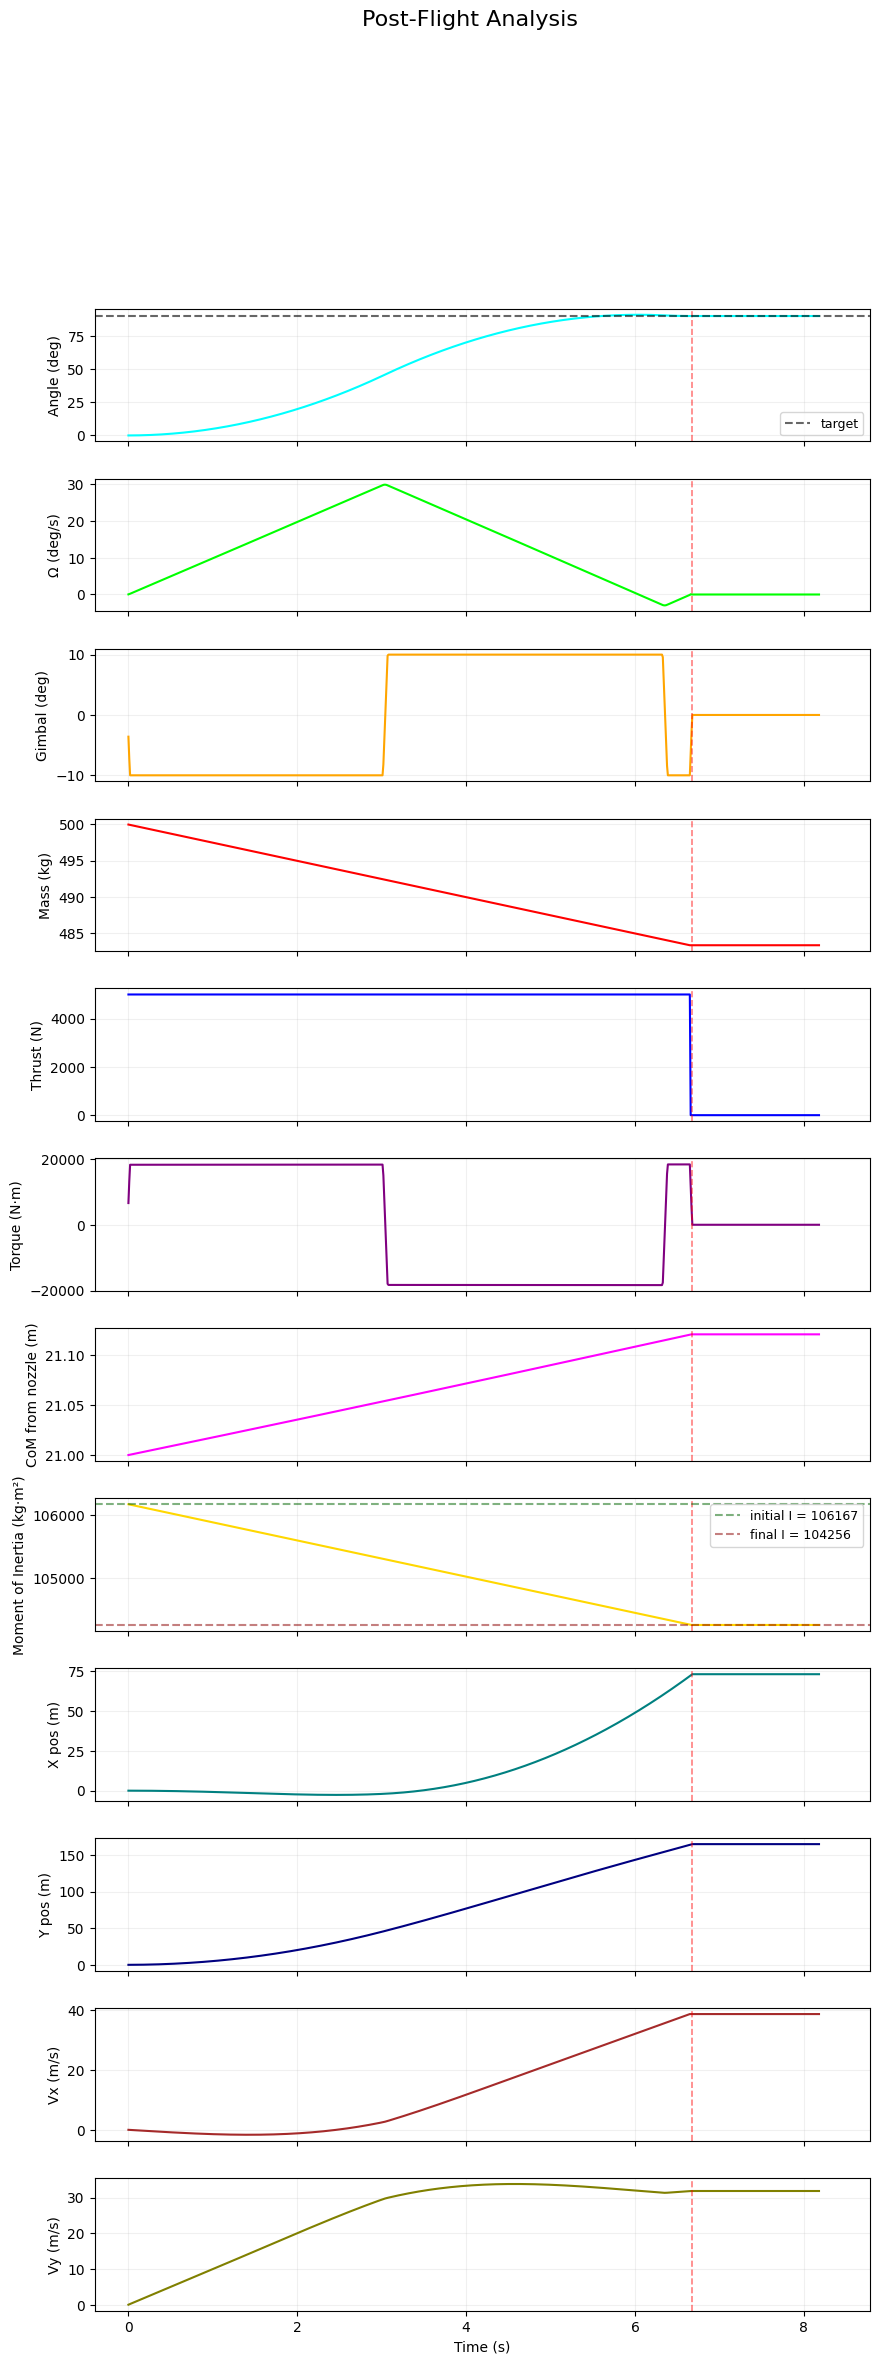

288.54736745815455
Saving telemetry-enhanced animation...
Done.


In [ ]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.patches import Polygon, FancyArrowPatch
from matplotlib.colors import LinearSegmentedColormap

# Physics & Geometry Helpers
def wrap_angle(a):
    """Wraps angle to [-180, 180] (0=up, 180=down, [0, 180] = right halfplane, [0, -180] = left halfplane)."""
    return (a + 180) % 360 - 180

# for animating rotating objects
def rotate_point(x, y, pivot_x, pivot_y, angle_deg):
    angle_rad = np.radians(angle_deg)
    nx, ny = x - pivot_x, y - pivot_y
    s, c = np.sin(-angle_rad), np.cos(-angle_rad)
    rx = nx * c - ny * s
    ry = nx * s + ny * c
    return rx + pivot_x, ry + pivot_y

def get_rotated_points(points_list, pivot, angle):
    return [rotate_point(p[0], p[1], pivot[0], pivot[1], angle) for p in points_list]

# Function to calculate CoM and I
def calculate_com_and_I(curr_mass, fuel_remaining, dry_mass, rocket_height, fuel_tank_height, dry_cm_from_nozzle, fuel_cm_from_nozzle):
    com_from_nozzle = (dry_mass * dry_cm_from_nozzle + fuel_remaining * fuel_cm_from_nozzle) / curr_mass
    
    # Dry mass: assumed uniform over rocket_height
    I_dry_cm = (1/12) * dry_mass * rocket_height**2
    dry_distance = dry_cm_from_nozzle - com_from_nozzle
    I_dry = I_dry_cm + dry_mass * dry_distance**2
    
    # Fuel: assumed uniform over fuel_tank_height
    I_fuel_cm = (1/12) * fuel_remaining * fuel_tank_height**2
    fuel_distance = fuel_cm_from_nozzle - com_from_nozzle
    I_fuel = I_fuel_cm + fuel_remaining * fuel_distance**2
    
    I = I_dry + I_fuel
    return com_from_nozzle, I

# User Inputs
theta_0 = wrap_angle(float(input("Initial angle (deg): ")))
theta_target = wrap_angle(float(input("Target angle (deg): ")))
omega_0 = float(input("Initial angular velocity (deg/s): "))
dry_mass = float(input("Dry mass (kg): "))
fuel_mass = float(input("Fuel mass (kg): "))
thrust_force = float(input("Thrust Force (N): "))
v_e = float(input("Exhaust velocity (m/s): "))

# Rocket Specs
rocket_height = 70
rocket_width = 7
nose_height = 15
engine_height = 10
gimbal_limit = 10.0
max_gimbal_speed = 360.0

# Rough geometry for CoM and I
fuel_tank_height = rocket_height / 2  # Fuel in lower half
fuel_cm_from_nozzle = fuel_tank_height / 2
dry_cm_from_nozzle = rocket_height / 2  # Dry mass uniform along height

# Controllability Check 
initial_mass = dry_mass + fuel_mass
initial_com, initial_I = calculate_com_and_I(initial_mass, fuel_mass, dry_mass, rocket_height, fuel_tank_height, dry_cm_from_nozzle, fuel_cm_from_nozzle)
max_alpha_possible = np.degrees((thrust_force * np.sin(np.radians(gimbal_limit)) * initial_com) / initial_I)
stopping_time = abs(omega_0) / max_alpha_possible if max_alpha_possible > 0 else 0
fuel_burn_rate = thrust_force / v_e
fuel_needed = fuel_burn_rate * stopping_time

if fuel_needed > fuel_mass:
    print("WARNING: System is NOT controllable. Not enough fuel to stop initial rotation!")
    sys.exit("Aborting simulation.")

short_error = wrap_angle(theta_target - theta_0)
stopping_dist = (omega_0**2) / (2 * max_alpha_possible) if max_alpha_possible > 0 else 9999999
use_wrap = True
effective_target = theta_target
if np.sign(omega_0) != np.sign(short_error) and stopping_dist > abs(short_error):
    # Commit to long path
    use_wrap = False
    effective_target = theta_0 + (short_error - 360 * np.sign(short_error))
    print("Using long path for optimality (effective target: {:.2f}°)".format(effective_target))
else:
    print("Using short path.")

effective_error = abs(effective_target - theta_0)
maneuver_time_est = 2 * np.sqrt(effective_error / max_alpha_possible) if max_alpha_possible > 0 else 0
fuel_maneuver_est = fuel_burn_rate * maneuver_time_est

fuel_stop_est = 0
if np.sign(omega_0) != np.sign(effective_target - theta_0):
    fuel_stop_est = fuel_burn_rate * abs(omega_0) / max_alpha_possible if max_alpha_possible > 0 else 0

fuel_needed = fuel_maneuver_est + fuel_stop_est

if fuel_needed > fuel_mass:
    print("WARNING: System is NOT controllable. Not enough fuel to reach the target!")
    sys.exit("Aborting simulation.")
else:
    print("System is controllable. Proceeding to simulation...")

# Simulation Logic 
dt = 0.01  
times, angles, unwrapped_angles, omegas, gimbals, masses, thrusts, torques, coms, Is, x_coms, y_coms, vxs, vys = [], [], [], [], [], [], [], [], [], [], [], [], [], []

curr_theta = theta_0
curr_omega = omega_0
curr_gimbal = 0.0
curr_mass = dry_mass + fuel_mass
x_com = 0.0
y_com = 0.0
vx = 0.0
vy = 0.0

t = 0
running = True
settled = False
while running and t < 40: 
    fuel_remaining = max(curr_mass - dry_mass, 0)
    com_from_nozzle, I = calculate_com_and_I(
        curr_mass, fuel_remaining, dry_mass, rocket_height,
        fuel_tank_height, dry_cm_from_nozzle, fuel_cm_from_nozzle
    )
    lever_arm = com_from_nozzle
    max_alpha = np.degrees((thrust_force * np.sin(np.radians(gimbal_limit)) * lever_arm) / I)
    
    # Smoothed Circular Control Logic 
    if use_wrap:
        error = wrap_angle(effective_target - curr_theta)
    else:
        error = effective_target - curr_theta
    target_omega = np.sign(error) * np.sqrt(2 * max_alpha * abs(error))
    switch_error = target_omega - curr_omega
    
    boundary = 0.2 # smaller = snappier; larger = smoother; the closer it is to zero, the closer the control is to being 100% bang-bang
    if abs(switch_error) > boundary:
        target_gimbal_cmd = -np.sign(switch_error) * gimbal_limit
    else:
        target_gimbal_cmd = -(switch_error / boundary) * gimbal_limit

    # Settling Logic
    active_thrust = True
    if abs(error) < 0.2 and abs(curr_omega) < 0.2:
        target_gimbal_cmd = 0.0
        curr_omega = 0.0
        active_thrust = False
        settled = True

    # Slew Rate Logic
    gimbal_err = target_gimbal_cmd - curr_gimbal
    if abs(gimbal_err) > 0.01:
        step = np.sign(gimbal_err) * max_gimbal_speed * dt
        curr_gimbal += np.clip(step, -abs(gimbal_err), abs(gimbal_err))

    # Physics Integration
    current_thrust = thrust_force if active_thrust else 0.0

    # Thrust direction in body frame: along rocket axis + gimbal
    thrust_body_angle = curr_theta + curr_gimbal   # both in degrees
    thrust_rad = np.radians(thrust_body_angle)

    # Thrust vector in world coordinates (0° = up = +y)
    thrust_x = current_thrust * np.sin(thrust_rad)
    thrust_y = current_thrust * np.cos(thrust_rad)

    # Acceleration from thrust
    if curr_mass > dry_mass + 1e-6:   # avoid div by near-zero
        ax = thrust_x / curr_mass
        ay = thrust_y / curr_mass
    else:
        ax = ay = 0.0

    # Integrate translation (simple Euler — good enough for visualization)
    vx += ax * dt
    vy += ay * dt
    x_com += vx * dt
    y_com += vy * dt

    # Rotational part
    torque = -thrust_force * np.sin(np.radians(curr_gimbal)) * lever_arm
    alpha = np.degrees(torque / I)
    
    curr_omega += alpha * dt
    curr_theta += curr_omega * dt
    
    if active_thrust:
        curr_mass -= (current_thrust / v_e) * dt
        curr_mass = max(curr_mass, dry_mass)
    
    # Store everything
    times.append(t)
    angles.append(wrap_angle(curr_theta))
    unwrapped_angles.append(curr_theta)
    omegas.append(curr_omega)
    gimbals.append(curr_gimbal)
    masses.append(curr_mass)
    thrusts.append(current_thrust)
    torques.append(torque)
    coms.append(com_from_nozzle)
    Is.append(I)          
    x_coms.append(x_com)
    y_coms.append(y_com)
    vxs.append(vx)
    vys.append(vy)
    
    t += dt
    if (settled and abs(curr_gimbal) < 0.01) or curr_mass <= dry_mass:
        running = False

# Post-settle hold for visualization
for _ in range(int(1.5/dt)):
    times.append(times[-1] + dt)
    angles.append(wrap_angle(curr_theta))
    unwrapped_angles.append(curr_theta)
    omegas.append(0.0)
    gimbals.append(0.0)
    masses.append(masses[-1])
    thrusts.append(0.0)
    torques.append(0.0)
    coms.append(coms[-1])
    Is.append(Is[-1])
    x_coms.append(x_coms[-1])
    y_coms.append(y_coms[-1])
    vxs.append(vxs[-1])
    vys.append(vys[-1])

print(f"Final stopping time: {t:.2f} s")

# Diagnostic Plots 
fig_diag, axs = plt.subplots(12, 1, figsize=(10, 26), sharex=True)
plt.subplots_adjust(hspace=0.28)

plot_data = [angles, omegas, gimbals, masses, thrusts, torques, coms, Is, x_coms, y_coms, vxs, vys]
labels = [
    'Angle (deg)',
    'Ω (deg/s)',
    'Gimbal (deg)',
    'Mass (kg)',
    'Thrust (N)',
    'Torque (N·m)',
    'CoM from nozzle (m)',
    'Moment of Inertia (kg·m²)',
    'X pos (m)',
    'Y pos (m)',
    'Vx (m/s)',
    'Vy (m/s)'
]
colors = ['cyan', 'lime', 'orange', 'red', 'blue', 'purple', 'magenta', 'gold', 'teal', 'navy', 'brown', 'olive']

for i, ax in enumerate(axs):
    ax.plot(times, plot_data[i], color=colors[i])
    ax.set_ylabel(labels[i])
    ax.set_facecolor("#ffffff")
    ax.grid(True, alpha=0.18)
    ax.set_xlim(-0.4, times[-1] + 0.6)
    ax.axvline(t - dt, color="red", linestyle="--", alpha=0.5, lw=1.2)

# ─── Angle plot extras ────────────────────────────────────────
axs[0].axhline(theta_target, color='black', linestyle='--', alpha=0.6, label="target")
axs[0].legend(fontsize=9)

"""
# ─── CoM plot extras ──────────────────────────────────────────
axs[6].axhline(0, color='gray', ls=':', alpha=0.5, label="nozzle")
axs[6].axhline(rocket_height, color='gray', ls='--', alpha=0.5, label="nose tip")
axs[6].axhline(rocket_height / 2, color='darkgray', ls='-.', alpha=0.4, label="geometric center")
axs[6].set_ylim(0, rocket_height * 1.05)
axs[6].legend(fontsize=9, loc='lower right')"""

# ─── I plot extras ────────────────────────────────────────────
axs[7].axhline(Is[0], color='darkgreen', ls='--', alpha=0.5, label=f"initial I = {Is[0]:.0f}")
if len(Is) > 1:
    axs[7].axhline(Is[-1], color='darkred', ls='--', alpha=0.5, label=f"final I = {Is[-1]:.0f}")
axs[7].legend(fontsize=9, loc='upper right')

axs[-1].set_xlabel("Time (s)")

plt.suptitle("Post-Flight Analysis", fontsize=16, y=0.995)
plt.show()

# Animation Setup 
fig, (ax, ax_info) = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [2, 1]})
fig_size = max(1.75 * max(max(abs(x) for x in x_coms), max(abs(y) for y in y_coms)), rocket_height + 30)
print(fig_size)
ax.set_xlim(-fig_size, fig_size); ax.set_ylim(-fig_size + 25, fig_size)
ax.set_aspect('equal'); ax.axis('off')

custom_cmap = LinearSegmentedColormap.from_list("sky", ["#102C57", "#000000"])
ax.imshow(np.linspace(0, 1, 100).reshape(-1, 1), extent=[-fig_size, fig_size, -fig_size, fig_size], origin='lower', cmap=custom_cmap, aspect='auto')

body_patch = Polygon([(0,0)], fc="white", ec="black", zorder=11)
nose_patch = Polygon([(0,0)], fc="white", ec="black", zorder=12)
engine_patch = Polygon([(0,0)], fc="#D0D0D0", ec="black", zorder=10)
flame_patch = Polygon([(0,0)], fc="orange", ec="red", lw=1.5, zorder=9)
initial_line, = ax.plot([], [], color='red', linestyle='--', alpha=0.6, zorder=5, label="Initial Angle") # Initial Angle indicator
target_line, = ax.plot([], [], color='green', linestyle='--', alpha=0.7, zorder=5, label="Target Angle") # Target indicator
for p in [body_patch, nose_patch, engine_patch, flame_patch]: ax.add_patch(p)

# Set static lines
rad1 = np.radians(theta_0)
initial_line.set_data([0, 80*np.sin(rad1)], [0, 80*np.cos(rad1)])
rad2 = np.radians(theta_target)
target_line.set_data([0, 80*np.sin(rad2)], [0, 80*np.cos(rad2)])

ax_info.set_facecolor('white'); ax_info.axis('off')
left_bound = -0.2
fontsize = 15
txt_angle  = ax_info.text(left_bound, 0.8, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
txt_omega  = ax_info.text(left_bound, 0.7, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
txt_gimbal = ax_info.text(left_bound, 0.6, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
txt_thrust = ax_info.text(left_bound, 0.5, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
txt_fuel   = ax_info.text(left_bound, 0.4, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
txt_burned = ax_info.text(left_bound, 0.3, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
txt_torque = ax_info.text(left_bound, 0.2, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
txt_time   = ax_info.text(left_bound, 0.1, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
ax_info.text(0.5, 0.9, "LIVE TELEMETRY", color='black', fontsize=fontsize + 4, fontweight='bold', ha="center")

# Add title above rocket plot
ax.text(0.5, 1.02, f"Initial Angular Velocity: {omega_0:.2f} deg/s", family='monospace', fontweight='bold', ha='center', va='bottom', color='black', fontsize=12, transform=ax.transAxes)

# Add arrow for initial velocity direction (yellow for visibility)
arrow_length = 0.2*fig_size
arrow_patch = FancyArrowPatch((0,0), (0,0), mutation_scale=20, color='yellow', visible=False, zorder=20)
ax.add_patch(arrow_patch)

# Add arrow for translational velocity (cyan)
vel_arrow_patch = FancyArrowPatch((0,0), (0,0), mutation_scale=20, color='cyan', visible=False, zorder=20)
ax.add_patch(vel_arrow_patch)

# Position & velocity display on the rocket plot (bottom left, fixed screen position)
pos_vel_text1 = ax.text(
    0.05, 0.06, '', 
    transform=ax.transAxes,
    color='white',
    fontsize=13,
    family='monospace',
    fontweight='bold',
    va='bottom',
    ha='left',
)

pos_vel_text2 = ax.text(
    0.05, 0.02, '', 
    transform=ax.transAxes,
    color='white',
    fontsize=13,
    family='monospace',
    fontweight='bold',
    va='bottom',
    ha='left',
)

# Geometry Definitions (outside animate for efficiency)
body_raw = [[-7,-35], [7,-35], [7,35], [-7,35]]
nose_raw = [[-7,35], [7,35], [0, 50]]
engine_attach = (0, -34)
engine_raw = [[-8.4,-45], [8.4,-45], [4.5,-34], [-4.5,-34]]
flame_raw = [[-5.6,-45], [5.6,-45], [0, -70]]

# Precompute relative points for gimbaled parts
engine_rel = [(ex - engine_attach[0], ey - engine_attach[1]) for ex, ey in engine_raw]
flame_rel = [(fx - engine_attach[0], fy - engine_attach[1]) for fx, fy in flame_raw]

def animate(i):
    t_val, g_val, thr_val = unwrapped_angles[i], gimbals[i], thrusts[i]
    
    # Shift to local CoM at (0,0)
    local_com_y = coms[i] - dry_cm_from_nozzle
    body_local = [(bx, by - local_com_y) for bx, by in body_raw]
    nose_local = [(nx, ny - local_com_y) for nx, ny in nose_raw]
    engine_attach_local = (engine_attach[0], engine_attach[1] - local_com_y)
    
    # Rotate fixed parts around local CoM
    body_rot = get_rotated_points(body_local, (0, 0), t_val)
    nose_rot = get_rotated_points(nose_local, (0, 0), t_val)
    
    # Rotate gimbaled parts around their local pivot
    engine_gimb_rel = get_rotated_points(engine_rel, (0, 0), g_val)
    flame_gimb_rel  = get_rotated_points(flame_rel,  (0, 0), g_val)
    
    engine_local = [(ex + engine_attach_local[0], ey + engine_attach_local[1]) for ex, ey in engine_gimb_rel]
    flame_local  = [(fx + engine_attach_local[0], fy + engine_attach_local[1]) for fx, fy in flame_gimb_rel]
    
    engine_rot = get_rotated_points(engine_local, (0, 0), t_val)
    flame_rot  = get_rotated_points(flame_local,  (0, 0), t_val)
    
    # World position
    cx, cy = x_coms[i], y_coms[i]
    body_patch.set_xy([(px + cx, py + cy) for px, py in body_rot])
    nose_patch.set_xy([(px + cx, py + cy) for px, py in nose_rot])
    engine_patch.set_xy([(px + cx, py + cy) for px, py in engine_rot])
    flame_patch.set_xy([(px + cx, py + cy) for px, py in flame_rot])
    flame_patch.set_visible(thr_val > 0 and i != 0)
    
    # Telemetry
    LABEL_WIDTH = len("FUEL BURNED:") + 1
    VALUE_WIDTH = 11

    txt_angle.set_text(  f"{'BODY TILT:':>{LABEL_WIDTH}}{wrap_angle(t_val):>{VALUE_WIDTH}.2f} [°]" )
    txt_omega.set_text(  f"{'ANG VEL:':>{LABEL_WIDTH}}{omegas[i]:>{VALUE_WIDTH}.2f} [°/s]" )
    txt_gimbal.set_text( f"{'GIMBAL:':>{LABEL_WIDTH}}{g_val:>{VALUE_WIDTH}.2f} [°]" )
    txt_thrust.set_text( f"{'THRUST:':>{LABEL_WIDTH}}{thr_val:>{VALUE_WIDTH}.0f} [N]" )
    txt_fuel.set_text(   f"{'FUEL LEFT:':>{LABEL_WIDTH}}{(masses[i]-dry_mass):>{VALUE_WIDTH}.2f} [kg]" )
    txt_burned.set_text( f"{'FUEL USED:':>{LABEL_WIDTH}}{(fuel_mass - (masses[i]-dry_mass)):{VALUE_WIDTH}.2f} [kg]" )
    txt_torque.set_text( f"{'TORQUE:':>{LABEL_WIDTH}}{torques[i]:>{VALUE_WIDTH}.0f} [N·m]" )
    txt_time.set_text(   f"{'TIME:':>{LABEL_WIDTH}}{min(times[i], t):>{VALUE_WIDTH}.2f} [s]" )
    pos_vel_text1.set_text(
        f"   X: {x_coms[i]:10.2f} m     "
        f"    Y: {y_coms[i]:10.2f} m"
    )

    pos_vel_text2.set_text(
        f"  Vx: {vxs[i]:10.2f} m/s    "
        f"  Vy: {vys[i]:10.2f} m/s"
    )
        
    # ─── Arrow + legend logic ───────────────────────────────────────
    legend = ax.get_legend()
    if legend is not None:
        legend.remove()

    show_initial_arrow = (times[i] < dt) and (abs(omega_0) > 1e-6)

    if show_initial_arrow:
        tip_point = get_rotated_points([(0, 50 - local_com_y)], (0, 0), t_val)[0]
        tx, ty = tip_point[0] + cx, tip_point[1] + cy
        r = np.sqrt(tx**2 + ty**2)
        if r > 0:
            dx = -np.sign(omega_0) * (-ty / r) * arrow_length
            dy = -np.sign(omega_0) * (tx / r) * arrow_length
            arrow_patch.set_positions((tx, ty), (tx + dx, ty + dy))
            arrow_patch.set_visible(True)

            handles = [initial_line, target_line, arrow_patch]
            labels = ["Initial Angle", "Target Angle", r"Initial $\omega$"]
            ax.legend(handles, labels, loc='upper right', fontsize=10, framealpha=0.7)
        else:
            arrow_patch.set_visible(False)
            handles = [initial_line, target_line]
            labels = ["Initial Angle", "Target Angle"]
            ax.legend(handles, labels, loc='upper right', fontsize=10, framealpha=0.7)
    else:
        arrow_patch.set_visible(False)
        if times[i] >= t:
            speed = np.sqrt(vxs[i]**2 + vys[i]**2)
            if speed > 1e-6:
                # Geometric center in body-local frame
                geom_center_local = (0, -local_com_y)
                geom_center_rot = rotate_point(
                    geom_center_local[0], geom_center_local[1],
                    0, 0, t_val
                )
                base_x = geom_center_rot[0] + cx
                base_y = geom_center_rot[1] + cy
                
                dx = (vxs[i] / speed) * arrow_length
                dy = (vys[i] / speed) * arrow_length
                
                vel_arrow_patch.set_positions((base_x, base_y), (base_x + dx, base_y + dy))
                vel_arrow_patch.set_visible(True)
                
                handles = [initial_line, target_line, vel_arrow_patch]
                labels = ["Initial Angle", "Target Angle", "Velocity"]
                ax.legend(handles, labels, loc='upper right', fontsize=10, framealpha=0.7)
            else:
                vel_arrow_patch.set_visible(False)
                handles = [initial_line, target_line]
                labels = ["Initial Angle", "Target Angle"]
                ax.legend(handles, labels, loc='upper right', fontsize=10, framealpha=0.7)
        else:
            vel_arrow_patch.set_visible(False)
            handles = [initial_line, target_line]
            labels = ["Initial Angle", "Target Angle"]
            ax.legend(handles, labels, loc='upper right', fontsize=10, framealpha=0.7)

    return (body_patch, nose_patch, engine_patch, flame_patch,
            txt_angle, txt_omega, txt_gimbal, txt_thrust, txt_fuel,
            txt_burned, txt_torque, txt_time, arrow_patch, vel_arrow_patch,
            pos_vel_text1, pos_vel_text2)

# Build animation
step_size = 2
anim_frames = [0] * 120 + list(range(0, len(times), step_size))
ani = FuncAnimation(fig, animate, frames=anim_frames, interval=20, blit=True)

print("Saving telemetry-enhanced animation...")
writer = FFMpegWriter(fps=60, bitrate=2500)
ani.save("results/attitude_translation.mp4", writer=writer)
print("Done.")
plt.close()

# Full 2D Case

## SLSQP Implementation

--- Time-Optimal Rocket Landing Solver ---

Initial state: [ 100.          270.00333333    0.          -20.            0.
    0.         1500.        ]
Optimizing trajectory (pass 1 — loose tolerance)...
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 36693342.43547107
            Iterations: 204
            Function evaluations: 74712
            Gradient evaluations: 200

Optimizing trajectory (pass 2 — tight tolerance)...
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 36693342.43547107
            Iterations: 204
            Function evaluations: 74712
            Gradient evaluations: 200

--- Solution Report ---
  Converged:        False
  Landing time:     51.776 s
  Final pos error:  42.6883 m
  Final vel error:  0.0000 m/s
  Fuel consumed:    245.96 kg

  Message: Positive directional derivative for linesearch
  The solution may be approximate. Try adjusting initial conditio

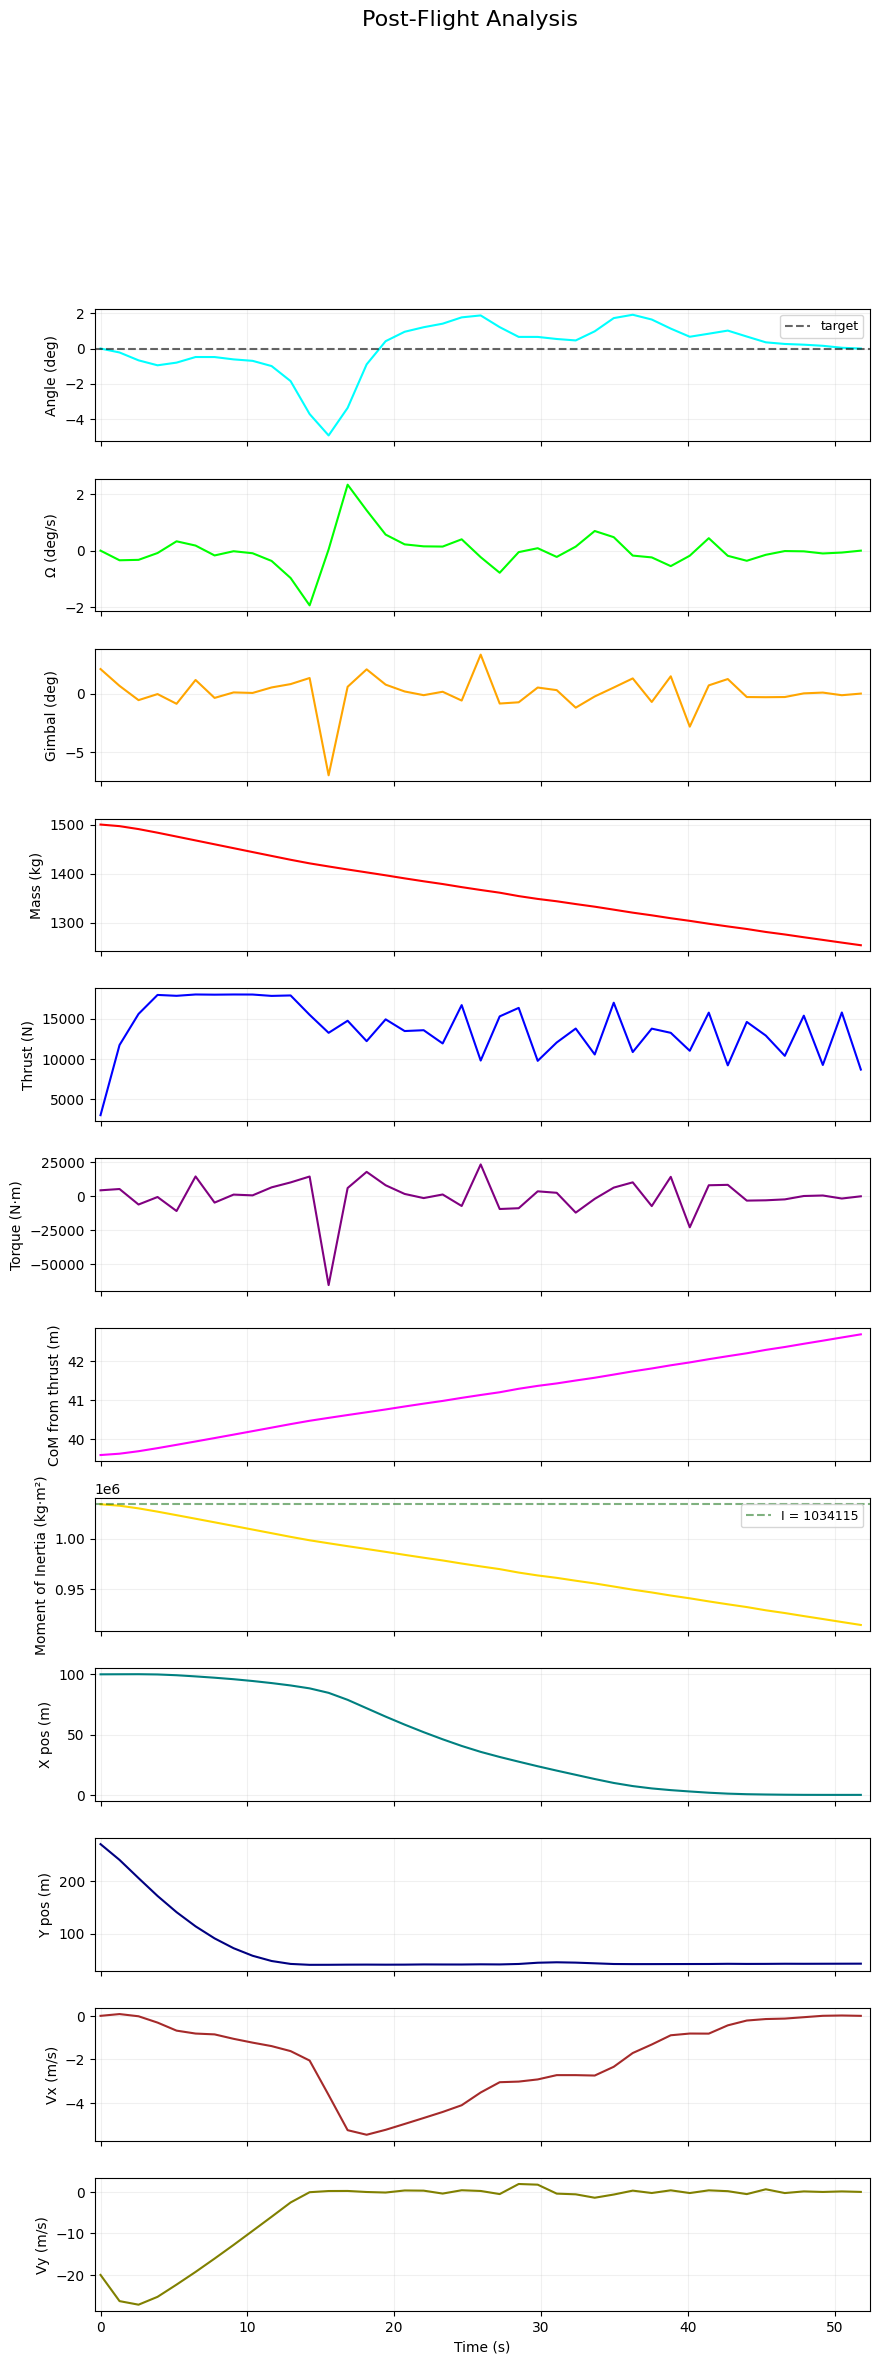

Saving animation...
Done.


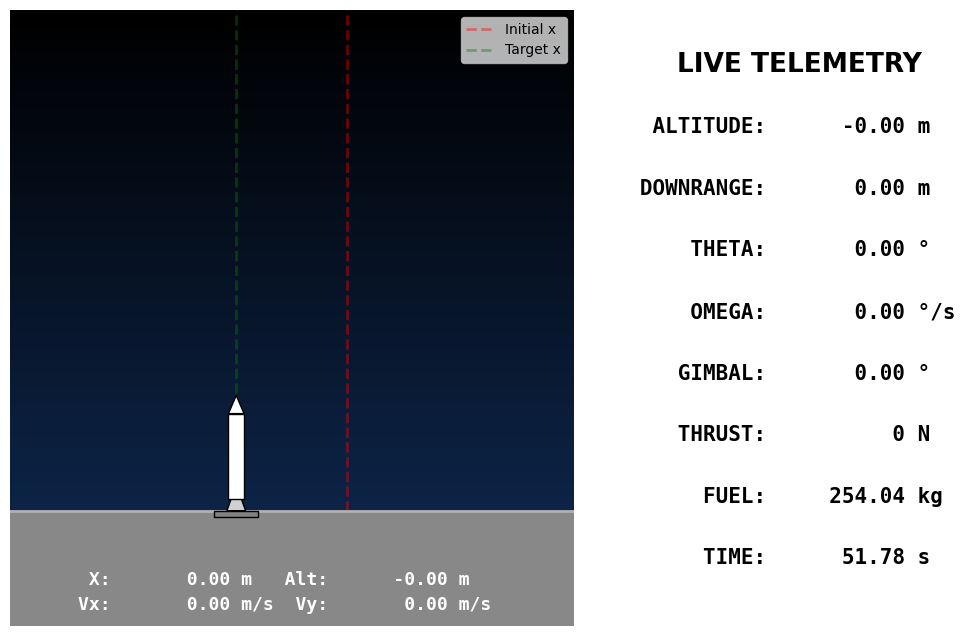

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.patches import Polygon, FancyArrowPatch, Rectangle
from matplotlib.colors import LinearSegmentedColormap

# ==========================================
# 1. Physics & Vehicle Configuration
# ==========================================
class RocketConfig:
    g = 9.81              # Gravity (m/s^2)
    I_sp = 300.0          # Specific Impulse (s)
    g0 = 9.81             # Standard gravity for Isp (m/s^2)
    v_e = I_sp * g0       # Exhaust velocity (m/s)
    m_dry = 1000.0        # Dry mass (kg)
    m_fuel = 500.0        # Fuel mass (kg)
    T_max = 18000.0       # Max Thrust (N)
    T_min = 000.0        # Min throttleable thrust (N) - rockets can't throttle to zero
    
    # Geometry for shifting CoM and I
    rocket_height = 95.0  # Total height from nozzle to nose tip (m), adjusted to match drawing
    fuel_tank_height = rocket_height / 2
    dry_cm_from_nozzle = rocket_height / 2
    fuel_cm_from_nozzle = fuel_tank_height / 2

    alpha_max = np.deg2rad(10.0)  # Gimbal limit (rad)
    
    # Simulation settings
    N = 40                # More nodes for better resolution

config = RocketConfig()

# Helper to calculate CoM and I based on current mass
def calculate_com_and_I(curr_mass):
    fuel_remaining = max(curr_mass - config.m_dry, 0.0)
    com_from_nozzle = (config.m_dry * config.dry_cm_from_nozzle + fuel_remaining * config.fuel_cm_from_nozzle) / curr_mass
    
    # Dry mass: assumed uniform over rocket_height
    I_dry_cm = (1/12) * config.m_dry * config.rocket_height**2
    dry_distance = config.dry_cm_from_nozzle - com_from_nozzle
    I_dry = I_dry_cm + config.m_dry * dry_distance**2
    
    # Fuel: assumed uniform over fuel_tank_height
    I_fuel_cm = (1/12) * fuel_remaining * config.fuel_tank_height**2 if fuel_remaining > 0 else 0
    fuel_distance = config.fuel_cm_from_nozzle - com_from_nozzle
    I_fuel = I_fuel_cm + fuel_remaining * fuel_distance**2
    
    I_z = I_dry + I_fuel
    return com_from_nozzle, I_z

# ==========================================
# 2. Dynamics Model
# ==========================================
def rocket_dynamics(state, control):
    """
    State: [x, y, vx, vy, theta, omega, m] — y is CoM height
    Control: [T, alpha]
    
    Convention:
      theta = 0 means rocket pointing straight up (vertical)
      theta > 0 means rocket tilted to the right
      
    Thrust vector direction in world frame:
      Thrust acts along the rocket body axis (pointing "up" the rocket),
      then the gimbal deflects it by alpha relative to the body.
      
      Total angle of thrust vector from world vertical = theta + alpha
      Fx = T * sin(theta + alpha)   [horizontal, adjusted sign for consistency]
      Fy = T * cos(theta + alpha)   [vertical]
      
    Torque: gimbal deflects thrust, creating a moment.
      tau = -l_t * T * sin(alpha)
      Negative: positive alpha deflects thrust to create a restoring torque
      (if rocket tilts right/positive theta, positive alpha corrects it)
    """
    x, y, vx, vy, theta, omega, m = state
    T, alpha = control
    
    l_t, I_z = calculate_com_and_I(m)
    
    thrust_angle = theta + alpha  # Total angle of thrust from vertical
    
    dx = vx
    dy = vy
    dvx = (T / m) * np.sin(thrust_angle)   # Adjusted sign to match convention
    dvy = (T / m) * np.cos(thrust_angle) - config.g
    dtheta = omega
    domega = -(l_t * T / I_z) * np.sin(alpha) if I_z > 0 else 0
    dm = -T / config.v_e
    
    return np.array([dx, dy, dvx, dvy, dtheta, domega, dm])

# ==========================================
# 3. Optimization Problem Setup
# ==========================================
def solve_optimal_landing(initial_state):
    N = config.N
    n_states = 7
    n_controls = 2
    
    n_vars = (N + 1) * (n_states + n_controls) + 1
    
    tf_guess = 15.0
    time_array = np.linspace(0, tf_guess, N+1)
    
    # Approximate final com for guess (assume near dry)
    approx_final_com, _ = calculate_com_and_I(config.m_dry + config.m_fuel * 0.1)
    final_state_target = np.array([0, approx_final_com, 0, 0, 0, 0, config.m_dry])
    
    x_guess = np.linspace(initial_state, final_state_target, N+1)
    u_guess = np.zeros((N+1, n_controls))
    
    # Better initial guess: hover thrust, no gimbal
    hover_thrust = initial_state[6] * config.g  # mg to hover
    hover_thrust = np.clip(hover_thrust, config.T_min, config.T_max)
    u_guess[:, 0] = hover_thrust
    u_guess[:, 1] = 0.0
    
    x0 = np.concatenate([x_guess.flatten(), u_guess.flatten(), [tf_guess]])

    def unpack(vector):
        tf = vector[-1]
        dt = tf / N
        idx_state_end = (N + 1) * n_states
        states_flat = vector[:idx_state_end]
        controls_flat = vector[idx_state_end:-1]
        states = states_flat.reshape((N + 1, n_states))
        controls = controls_flat.reshape((N + 1, n_controls))
        return states, controls, tf, dt

    # ------------------------------------------
    # Objective: time + regularization terms
    # ------------------------------------------
    # Pure time minimization leads to chaotic bang-bang controls.
    # Adding small penalties for:
    #   1. Control effort (smooths thrust profile)
    #   2. Control rate (penalizes rapid changes — the key fix for wobbling)
    #   3. Angle deviation (encourages upright flight)
    def objective(vector):
        states, controls, tf, dt = unpack(vector)
        
        """
        Physical / Smooth solution:
                # Regularization weights (small enough not to dominate, big enough to smooth)
                w_thrust = 1e-9      # Thrust effort penalty
                w_gimbal = 0.05      # Gimbal angle penalty (strongly discourages unnecessary gimbaling) (was 1e-3)
                w_gimbal_rate = 0.25 # Gimbal rate penalty (prevents rapid gimbal changes) (was 5e-2)
                w_theta = 0.2       # Attitude deviation penalty (encourages upright) (was 1e-2)
        """
        """ 
        Also decent:
        w_thrust = 0.05      # Thrust effort penalty (was 1e-9)
        w_gimbal = 0.2      # Gimbal angle penalty (strongly discourages unnecessary gimbaling) (was 1e-3)
        w_gimbal_rate = 0.5 # Gimbal rate penalty (prevents rapid gimbal changes) (was 5e-2)
        w_theta = 0.2       # Attitude deviation penalty (encourages upright) (was 1e-2)
        """

        """ 
        Also decent:
        w_thrust = 0.05      # Thrust effort penalty (was 1e-9)
        w_gimbal = 0.3      # Gimbal angle penalty (strongly discourages unnecessary gimbaling) (was 1e-3)
        w_gimbal_rate = 0.55 # Gimbal rate penalty (prevents rapid gimbal changes) (was 5e-2)
        w_theta = 0.2       # Attitude deviation penalty (encourages upright) (was 1e-2)
        
        """


        # Existing weights (unchanged, but you may need to tune them down to allow more bang-bang behavior)
        w_time = 10.0        # Time penalty (encourages shortest time)
        w_thrust = 1e-3      # Thrust effort penalty (was 1e-9)
        w_gimbal = 0.05      # Gimbal angle penalty (strongly discourages unnecessary gimbaling) (was 1e-3)
        w_gimbal_rate = 0.25 # Gimbal rate penalty (prevents rapid gimbal changes) (was 5e-2)
        w_theta = 0.5       # Attitude deviation penalty (encourages upright) (was 1e-2)
        
        # New weight for altitude-weighted thrust penalty (start small; tune up if not suicide-like enough)
        w_alt_thrust = 0.01  # Adjust this: too low = no effect; too high = may not converge or crash early
        
        w_landing = 2000.0

        thrusts = controls[:, 0]
        gimbals = controls[:, 1]
        thetas  = states[:, 4]
        ys      = states[:, 1]  # Altitude (y-position of CoM)

        # Soft penalty: penalize nozzle going below ground
        nozzle_heights = ys - np.array([calculate_com_and_I(m)[0] for m in states[:, 6]])
        # Proximity is 0 when high up, 1 when nozzle is at ground level
        # Use a fixed clearance distance (absolute, not relative to trajectory height)
        clearance_zone = config.rocket_height * 2  # ~190m above ground
        ground_proximity = np.maximum(0, 1.0 - nozzle_heights / clearance_zone)
        ground_proximity = ground_proximity ** 3  # sharper ramp near ground
        ground_violation = np.maximum(0, -nozzle_heights)  # only penalize when below 0

        # Primary: minimize time
        J_time = w_time * tf

        # Existing costs
        J_thrust = w_thrust * dt * np.sum(thrusts**2)
        J_gimbal = w_gimbal * dt * np.sum(gimbals**2)
        
        # Rate penalty: finite differences of controls
        gimbal_rates = np.diff(gimbals) / dt
        J_gimbal_rate = w_gimbal_rate * dt * np.sum(gimbal_rates**2)
        
        J_theta = w_theta * dt * np.sum(thetas**2)

        J_ground = 1e6 * np.sum(ground_violation**2)

        J_landing_theta  = w_landing * dt * np.sum((thetas * ground_proximity)**2)
        J_landing_gimbal = w_landing * dt * np.sum((gimbals * ground_proximity)**2)
        
        # New: Penalize thrust more when altitude (y) is high
        # Use thrusts**2 to match existing quadratic penalties (encourages zero thrust over low thrust)
        # Normalize by max(y) to make weight scale-invariant (optional but helps tuning)
        y_norm = ys / np.max(ys) if np.max(ys) > 0 else np.ones_like(ys)
        J_alt_thrust = w_alt_thrust * dt * np.sum(thrusts**2 * y_norm)
        
        return J_time + J_thrust + J_gimbal + J_gimbal_rate + J_theta + J_alt_thrust + J_ground + J_landing_theta + J_landing_gimbal

    def constraints(vector):
        states, controls, tf, dt = unpack(vector)
        cons = []
        
        # 1. Trapezoidal collocation defects
        for k in range(N):
            s_k   = states[k]
            s_kp1 = states[k+1]
            u_k   = controls[k]
            u_kp1 = controls[k+1]
            
            f_k   = rocket_dynamics(s_k,   u_k)
            f_kp1 = rocket_dynamics(s_kp1, u_kp1)
            
            defect = s_kp1 - s_k - 0.5 * dt * (f_k + f_kp1)
            cons.extend(defect)
            
        # 2. Initial conditions
        cons.extend(states[0] - initial_state)
        
        # 3. Terminal conditions: x=0, vx=vy=theta=omega=0, y = com_from_nozzle(m_terminal)
        cons.extend(states[-1, [0,2,3,4,5]] - [0, 0, 0, 0, 0])
        com_term, _ = calculate_com_and_I(states[-1, 6])
        cons.append(states[-1, 1] - com_term)
        
        # Force the engine gimbal to be centered (0 rad) at touchdown
        cons.append(controls[-1, 1])
        
        return np.array(cons)

    # ------------------------------------------
    # Bounds
    # ------------------------------------------
    bounds = []
    
    # How many nodes to enforce tight landing attitude over
    landing_nodes = 5  # last ~12% of trajectory
    tight_theta = np.deg2rad(2.0)   # ±2° near ground
    tight_alpha = np.deg2rad(2.0)   # ±2° gimbal near ground

    for k in range(N + 1):
        bounds.append((None, None))            # x
        bounds.append((0.0, None))             # y >= 0
        bounds.append((-50.0, 50.0))           # vx
        bounds.append((-100.0, 50.0))          # vy
        
        # Tighten attitude bounds near landing
        if k >= N + 1 - landing_nodes:
            bounds.append((-tight_theta, tight_theta))   # theta tight near ground
        else:
            bounds.append((-np.pi/4, np.pi/4))           # theta normal
        
        bounds.append((-0.5, 0.5))             # omega
        bounds.append((config.m_dry, initial_state[6]))  # mass

    for k in range(N + 1):
        bounds.append((config.T_min, config.T_max))
        
        # Tighten gimbal bounds near landing
        if k >= N + 1 - landing_nodes:
            bounds.append((-tight_alpha, tight_alpha))   # gimbal tight near ground
        else:
            bounds.append((-config.alpha_max, config.alpha_max))

    bounds.append((1.0, 60.0))  # tf

    # ------------------------------------------
    # Run Solver (two-pass for robustness)
    # ------------------------------------------
    print("Optimizing trajectory (pass 1 — loose tolerance)...")
    res1 = minimize(
        objective,
        x0,
        method='SLSQP',
        constraints={'type': 'eq', 'fun': constraints},
        bounds=bounds,
        options={'maxiter': 300, 'ftol': 1e-3, 'disp': True}
    )
    
    # Warm-start pass 2 from pass 1 result
    x0_warm = res1.x if res1.success else x0
    
    print("\nOptimizing trajectory (pass 2 — tight tolerance)...")
    res = minimize(
        objective,
        x0_warm,
        method='SLSQP',
        constraints={'type': 'eq', 'fun': constraints},
        bounds=bounds,
        options={'maxiter': 500, 'ftol': 1e-6, 'disp': True}
    )
    
    # Accept result from whichever pass got closer if both fail
    best = res if (res.success or not res1.success) else res1
    
    if best.success or True:  # Show result even if not fully converged
        states_sol, controls_sol, tf_sol, dt_sol = unpack(best.x)
        
        # Check if solution is physically reasonable
        final_pos_err = np.linalg.norm(states_sol[-1, 0:2])
        final_vel_err = np.linalg.norm(states_sol[-1, 2:4])
        
        print(f"\n--- Solution Report ---")
        print(f"  Converged:        {best.success}")
        print(f"  Landing time:     {tf_sol:.3f} s")
        print(f"  Final pos error:  {final_pos_err:.4f} m")
        print(f"  Final vel error:  {final_vel_err:.4f} m/s")
        print(f"  Fuel consumed:    {initial_state[6] - states_sol[-1, 6]:.2f} kg")
        
        if not best.success:
            print(f"\n  WARNING: Optimizer did not fully converge.")
            print(f"  Message: {best.message}")
            print(f"  The solution may be approximate. Try adjusting initial conditions.")
        
        return states_sol, controls_sol, tf_sol, best.x
    else:
        print("Optimization Failed.")
        print(best.message)
        return None, None, None, None

# ==========================================
# 4. Animation
# ==========================================
def rotate_point(x, y, pivot_x, pivot_y, angle_deg):
    angle_rad = np.radians(angle_deg)
    nx, ny = x - pivot_x, y - pivot_y
    s, c = np.sin(-angle_rad), np.cos(-angle_rad)
    rx = nx * c - ny * s
    ry = nx * s + ny * c
    return rx + pivot_x, ry + pivot_y

def get_rotated_points(points_list, pivot, angle):
    return [rotate_point(p[0], p[1], pivot[0], pivot[1], angle) for p in points_list]

def animate_results(states, controls, tf):
    N = states.shape[0] - 1
    sim_times = np.linspace(0, tf, N + 1)
    
    fps = 30
    hold_time_start = 2.0
    hold_time_end = 2.0
    num_hold_start = int(hold_time_start * fps)
    num_hold_end = int(hold_time_end * fps)
    num_anim_frames = int(tf * fps) + 1
    anim_times = np.linspace(0, tf, num_anim_frames)
    
    dt_anim = anim_times[1] - anim_times[0] if num_anim_frames > 1 else 0
    
    x_coms = interp1d(sim_times, states[:, 0])(anim_times)
    y_coms = interp1d(sim_times, states[:, 1])(anim_times)
    vxs    = interp1d(sim_times, states[:, 2])(anim_times)
    vys    = interp1d(sim_times, states[:, 3])(anim_times)
    angles = np.rad2deg(interp1d(sim_times, states[:, 4])(anim_times))
    omegas = np.rad2deg(interp1d(sim_times, states[:, 5])(anim_times))
    masses = interp1d(sim_times, states[:, 6])(anim_times)
    
    thrusts = interp1d(sim_times, controls[:, 0])(anim_times)
    gimbals = np.rad2deg(interp1d(sim_times, controls[:, 1])(anim_times))
    
    thrusts[-1] = 0
    gimbals[-1] = 0
    
    # Compute coms and I_zs for animation frames
    coms = np.array([calculate_com_and_I(m)[0] for m in masses])
    I_zs = np.array([calculate_com_and_I(m)[1] for m in masses])
    
    # Add start hold
    x_coms = np.concatenate((np.full(num_hold_start, x_coms[0]), x_coms))
    y_coms = np.concatenate((np.full(num_hold_start, y_coms[0]), y_coms))
    vxs = np.concatenate((np.full(num_hold_start, vxs[0]), vxs))
    vys = np.concatenate((np.full(num_hold_start, vys[0]), vys))
    angles = np.concatenate((np.full(num_hold_start, angles[0]), angles))
    omegas = np.concatenate((np.full(num_hold_start, omegas[0]), omegas))
    masses = np.concatenate((np.full(num_hold_start, masses[0]), masses))
    thrusts = np.concatenate((np.full(num_hold_start, thrusts[0]), thrusts))
    gimbals = np.concatenate((np.full(num_hold_start, gimbals[0]), gimbals))
    coms = np.concatenate((np.full(num_hold_start, coms[0]), coms))
    I_zs = np.concatenate((np.full(num_hold_start, I_zs[0]), I_zs))
    
    # Add end hold
    x_coms  = np.append(x_coms,  np.full(num_hold_end, x_coms[-1]))
    y_coms  = np.append(y_coms,  np.full(num_hold_end, y_coms[-1]))
    vxs     = np.append(vxs,     np.full(num_hold_end, 0.0))
    vys     = np.append(vys,     np.full(num_hold_end, 0.0))
    angles  = np.append(angles,  np.full(num_hold_end, angles[-1]))
    omegas  = np.append(omegas,  np.full(num_hold_end, 0.0))
    masses  = np.append(masses,  np.full(num_hold_end, masses[-1]))
    thrusts = np.append(thrusts, np.full(num_hold_end, 0.0))
    gimbals = np.append(gimbals, np.full(num_hold_end, gimbals[-1])) # Hold the last valid gimbal angle
    coms    = np.append(coms,    np.full(num_hold_end, coms[-1]))
    I_zs    = np.append(I_zs,    np.full(num_hold_end, I_zs[-1]))
    
    anim_times_start = np.linspace(-hold_time_start, -dt_anim, num_hold_start)
    anim_times_end = np.linspace(tf + dt_anim, tf + hold_time_end, num_hold_end)
    anim_times = np.concatenate((anim_times_start, anim_times, anim_times_end))
    num_anim_frames += num_hold_start + num_hold_end
    
    torques = coms * thrusts * np.sin(np.radians(gimbals))

    margin = config.rocket_height * 1.5
    x_min = min(x_coms) - margin
    x_max = max(x_coms) + margin
    y_min = -config.rocket_height
    y_max = max(y_coms) + margin
    x_span = x_max - x_min
    y_span = y_max - y_min
    if x_span < y_span:
        extra = (y_span - x_span) / 2
        x_min -= extra
        x_max += extra
    elif y_span < x_span:
        extra = (x_span - y_span) / 2
        y_min -= extra
        y_max += extra

    fig, (ax, ax_info) = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [2, 1]})
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')
    ax.axis('off')

    custom_cmap = LinearSegmentedColormap.from_list("sky", ["#102C57", "#000000"])
    ax.imshow(np.linspace(0, 1, 100).reshape(-1, 1), extent=[x_min, x_max, y_min, y_max],
              origin='lower', cmap=custom_cmap, aspect='auto')

    ax.axhspan(y_min, 0, color="#888888", zorder=1)
    ax.axhline(0, color="#B1B1B1", linewidth=2, zorder=2)

    # Add red dashed vertical line for initial position
    initial_x_line, = ax.plot([x_coms[0], x_coms[0]], [0, y_max], color='red', ls='--', lw=2, zorder=1.5, alpha=0.4, label="Initial x")

    # Add green dashed vertical line for target position
    target_x_line, = ax.plot([0, 0], [0, y_max], color='green', ls='--', lw=2, zorder=1.5, alpha=0.4, label="Target x")

    pad = Rectangle((-20, -5), 40, 5, fc="gray", ec="black", zorder=3)
    ax.add_patch(pad)

    body_patch   = Polygon([[0,0]], fc="white",   ec="black", zorder=11)
    nose_patch   = Polygon([[0,0]], fc="white",   ec="black", zorder=12)
    engine_patch = Polygon([[0,0]], fc="#D0D0D0", ec="black", zorder=10)
    flame_patch  = Polygon([[0,0]], fc="orange",  ec="red",   lw=1.5, zorder=9, visible=False)
    ax.add_patch(body_patch)
    ax.add_patch(nose_patch)
    ax.add_patch(engine_patch)
    ax.add_patch(flame_patch)

    arrow_length = abs(x_max - x_min) * 0.1
    vel_arrow = FancyArrowPatch(
        (0,0), (0,0),
        arrowstyle = "simple, head_width=9, head_length=9, tail_width=4",
        mutation_scale = 1.5,
        facecolor     = 'cyan',
        edgecolor     = 'black',
        linewidth     = 1.5,
        zorder        = 20,
        visible       = False,
        label         = "Initial Velocity"
    )
    ax.add_patch(vel_arrow)

    pos_vel_text1 = ax.text(0.12, 0.06, '', transform=ax.transAxes, color='white',
                            fontsize=13, family='monospace', fontweight='bold', va='bottom', ha='left')
    pos_vel_text2 = ax.text(0.12, 0.02, '', transform=ax.transAxes, color='white',
                            fontsize=13, family='monospace', fontweight='bold', va='bottom', ha='left')

    ax_info.set_facecolor('white')
    ax_info.axis('off')
    left_bound = -0.2
    fontsize = 15
    txt_alt      = ax_info.text(left_bound, 0.8, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_downrange= ax_info.text(left_bound, 0.7, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_theta    = ax_info.text(left_bound, 0.6, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_omega    = ax_info.text(left_bound, 0.5, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_gimbal   = ax_info.text(left_bound, 0.4, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_thrust   = ax_info.text(left_bound, 0.3, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_fuel     = ax_info.text(left_bound, 0.2, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_time     = ax_info.text(left_bound, 0.1, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    ax_info.text(0.5, 0.9, "LIVE TELEMETRY", color='black', fontsize=fontsize + 4, fontweight='bold', ha="center")

    # Geometry definitions with nozzle at y=0
    body_raw = [[-7,10], [7,10], [7,80], [-7,80]]
    nose_raw = [[-7,80], [7,80], [0,95]]
    engine_attach = (0, 10)
    engine_raw = [[-8.4,0], [8.4,0], [4.5,10], [-4.5,10]]
    engine_rel = [(ex - engine_attach[0], ey - engine_attach[1]) for ex, ey in engine_raw]

    base_flame_length = 25
    flame_raw = [[-5.6,0], [5.6,0], [0, -base_flame_length]]
    flame_rel = [(fx - engine_attach[0], fy - engine_attach[1]) for fx, fy in flame_raw]

    def animate(i):
        t_val  = angles[i]
        g_val  = gimbals[i]
        thr_val= thrusts[i]
        cx = x_coms[i]
        cy = y_coms[i]
        vx_i, vy_i = vxs[i], vys[i]
        com = coms[i]

        # Shift geometry so CoM at (0,0) local
        body_local = [[px, py - com] for px, py in body_raw]
        nose_local = [[px, py - com] for px, py in nose_raw]
        engine_attach_local = (0, 10 - com)

        body_rot   = get_rotated_points(body_local, (0, 0), t_val)
        nose_rot   = get_rotated_points(nose_local, (0, 0), t_val)

        engine_gimb_rel = get_rotated_points(engine_rel, (0, 0), g_val)
        engine_local    = [(ex + engine_attach_local[0], ey + engine_attach_local[1]) for ex, ey in engine_gimb_rel]
        engine_rot      = get_rotated_points(engine_local, (0, 0), t_val)

        flame_length = base_flame_length * (thr_val / config.T_max) if config.T_max > 0 else 0
        flame_rel_scaled = [(fx, fy * (flame_length / base_flame_length)) for fx, fy in flame_rel]  # Scale flame length
        flame_gimb_rel = get_rotated_points(flame_rel_scaled, (0, 0), g_val)
        flame_local    = [(fx + engine_attach_local[0], fy + engine_attach_local[1]) for fx, fy in flame_gimb_rel]
        flame_rot      = get_rotated_points(flame_local, (0, 0), t_val)

        body_patch.set_xy(  [(px + cx, py + cy) for px, py in body_rot])
        nose_patch.set_xy(  [(px + cx, py + cy) for px, py in nose_rot])
        engine_patch.set_xy([(px + cx, py + cy) for px, py in engine_rot])
        flame_patch.set_xy( [(px + cx, py + cy) for px, py in flame_rot])
        flame_patch.set_visible(thr_val > 0)

        LABEL_WIDTH = len("FUEL BURNED:") + 1
        VALUE_WIDTH = 11

        txt_alt.set_text(      f"{'ALTITUDE:':>{LABEL_WIDTH}}{y_coms[i] - coms[i]:>{VALUE_WIDTH}.2f} m")
        txt_downrange.set_text(f"{'DOWNRANGE:':>{LABEL_WIDTH}}{x_coms[i]:>{VALUE_WIDTH}.2f} m")
        txt_theta.set_text(    f"{'THETA:':>{LABEL_WIDTH}}{t_val:>{VALUE_WIDTH}.2f} °")
        txt_omega.set_text(    f"{'OMEGA:':>{LABEL_WIDTH}}{omegas[i]:>{VALUE_WIDTH}.2f} °/s")
        txt_gimbal.set_text(   f"{'GIMBAL:':>{LABEL_WIDTH}}{g_val:>{VALUE_WIDTH}.2f} °")
        txt_thrust.set_text(   f"{'THRUST:':>{LABEL_WIDTH}}{thr_val:>{VALUE_WIDTH}.0f} N")
        txt_fuel.set_text(     f"{'FUEL:':>{LABEL_WIDTH}}{masses[i] - config.m_dry:>{VALUE_WIDTH}.2f} kg")
        txt_time.set_text(     f"{'TIME:':>{LABEL_WIDTH}}{max(0, min(anim_times[i], tf)):>{VALUE_WIDTH}.2f} s")

        pos_vel_text1.set_text(f" X: {x_coms[i]:10.2f} m   Alt: {y_coms[i] - coms[i]:10.2f} m")
        pos_vel_text2.set_text(f"Vx: {vxs[i]:10.2f} m/s  Vy: {vys[i]:10.2f} m/s")

        show_vel_arrow = anim_times[i] < 0
        speed = np.sqrt(vx_i**2 + vy_i**2)
        if show_vel_arrow and speed > 1e-3:
            base_x = cx
            base_y = cy
            dx = (vx_i / speed) * arrow_length
            dy = (vy_i / speed) * arrow_length
            vel_arrow.set_positions((base_x, base_y), (base_x + dx, base_y + dy))
            vel_arrow.set_visible(True)
        else:
            vel_arrow.set_visible(False)

        # Legend management
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

        if show_vel_arrow and speed > 1e-3:
            handles = [initial_x_line, target_x_line, vel_arrow]
            labels = ["Initial x", "Target x", "Initial Velocity"]
            ax.legend(handles, labels, loc='upper right', fontsize=10, framealpha=0.7)
        else:
            handles = [initial_x_line, target_x_line]
            labels = ["Initial x", "Target x"]
            ax.legend(handles, labels, loc='upper right', fontsize=10, framealpha=0.7)

        return (body_patch, nose_patch, engine_patch, flame_patch,
                txt_alt, txt_downrange, txt_theta, txt_omega, txt_gimbal,
                txt_thrust, txt_fuel, txt_time, pos_vel_text1, pos_vel_text2, vel_arrow)

    ani = FuncAnimation(fig, animate, frames=range(num_anim_frames), interval=1000 // fps, blit=True)

    print("Saving animation...")
    writer = FFMpegWriter(fps=fps, bitrate=2500)
    ani.save("results/rocket_optimal_landing_claude_34.mp4", writer=writer)
    print("Done.")
    plt.show()

# ==========================================
# 5. Main Execution
# ==========================================
if __name__ == "__main__":
    print("--- Time-Optimal Rocket Landing Solver ---")
    
    h_0, x_0, vx_0, vy_0 = 230.42, 100.0, 0.0, -20.0

    initial_m = config.m_dry + config.m_fuel
    initial_com, _ = calculate_com_and_I(initial_m)
    s0 = np.array([x_0, h_0 + initial_com, vx_0, vy_0, 0.0, 0.0, initial_m])
    
    print(f"\nInitial state: {s0}")
    
    states, controls, tf, raw_res = solve_optimal_landing(s0)
    
    if states is not None:
        fig_diag, axs = plt.subplots(12, 1, figsize=(10, 26), sharex=True)
        plt.subplots_adjust(hspace=0.28)

        times       = np.linspace(0, tf, states.shape[0])
        angles_deg  = np.rad2deg(states[:, 4])
        omegas_deg  = np.rad2deg(states[:, 5])
        gimbals_deg = np.rad2deg(controls[:, 1])
        masses      = states[:, 6]
        thrusts     = controls[:, 0]
        coms        = np.array([calculate_com_and_I(m)[0] for m in masses])
        I_zs        = np.array([calculate_com_and_I(m)[1] for m in masses])
        torques     = coms * thrusts * np.sin(np.radians(gimbals_deg))
        x_coms      = states[:, 0]
        y_coms      = states[:, 1]
        vxs         = states[:, 2]
        vys         = states[:, 3]

        plot_data = [angles_deg, omegas_deg, gimbals_deg, masses, thrusts, torques,
                     coms, I_zs, x_coms, y_coms, vxs, vys]
        labels = ['Angle (deg)', 'Ω (deg/s)', 'Gimbal (deg)', 'Mass (kg)', 'Thrust (N)',
                  'Torque (N·m)', 'CoM from thrust (m)', 'Moment of Inertia (kg·m²)',
                  'X pos (m)', 'Y pos (m)', 'Vx (m/s)', 'Vy (m/s)']
        colors = ['cyan','lime','orange','red','blue','purple','magenta','gold','teal','navy','brown','olive']

        for i, ax in enumerate(axs):
            ax.plot(times, plot_data[i], color=colors[i])
            ax.set_ylabel(labels[i])
            ax.set_facecolor("#ffffff")
            ax.grid(True, alpha=0.18)
            ax.set_xlim(-0.4, times[-1] + 0.6)

        axs[0].axhline(0, color='black', linestyle='--', alpha=0.6, label="target")
        axs[0].legend(fontsize=9)
        axs[7].axhline(I_zs[0], color='darkgreen', ls='--', alpha=0.5, label=f"I = {I_zs[0]:.0f}")
        axs[7].legend(fontsize=9, loc='upper right')
        axs[-1].set_xlabel("Time (s)")

        plt.suptitle("Post-Flight Analysis", fontsize=16, y=0.995)
        plt.show()

        animate_results(states, controls, tf)

## CasADi Implementation

--- Time-Optimal Rocket Landing Solver ---

Initial state: [  50.          120.00333333   -5.          -70.            0.
    0.         1500.        ]
Setting up CasADi + IPOPT NLP...

Starting Optimization with IPOPT...
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2055
Number of nonzeros in inequality constraint Jacobian.:      329
Number of nonzeros in Lagrangian Hessian.............:      984

Total number of variables............................:      370
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      294
Total number of inequality constraints...............:      329
        inequality constraints with only lower bounds:       41
   inequality constraints with lower and upper bounds:      288
 

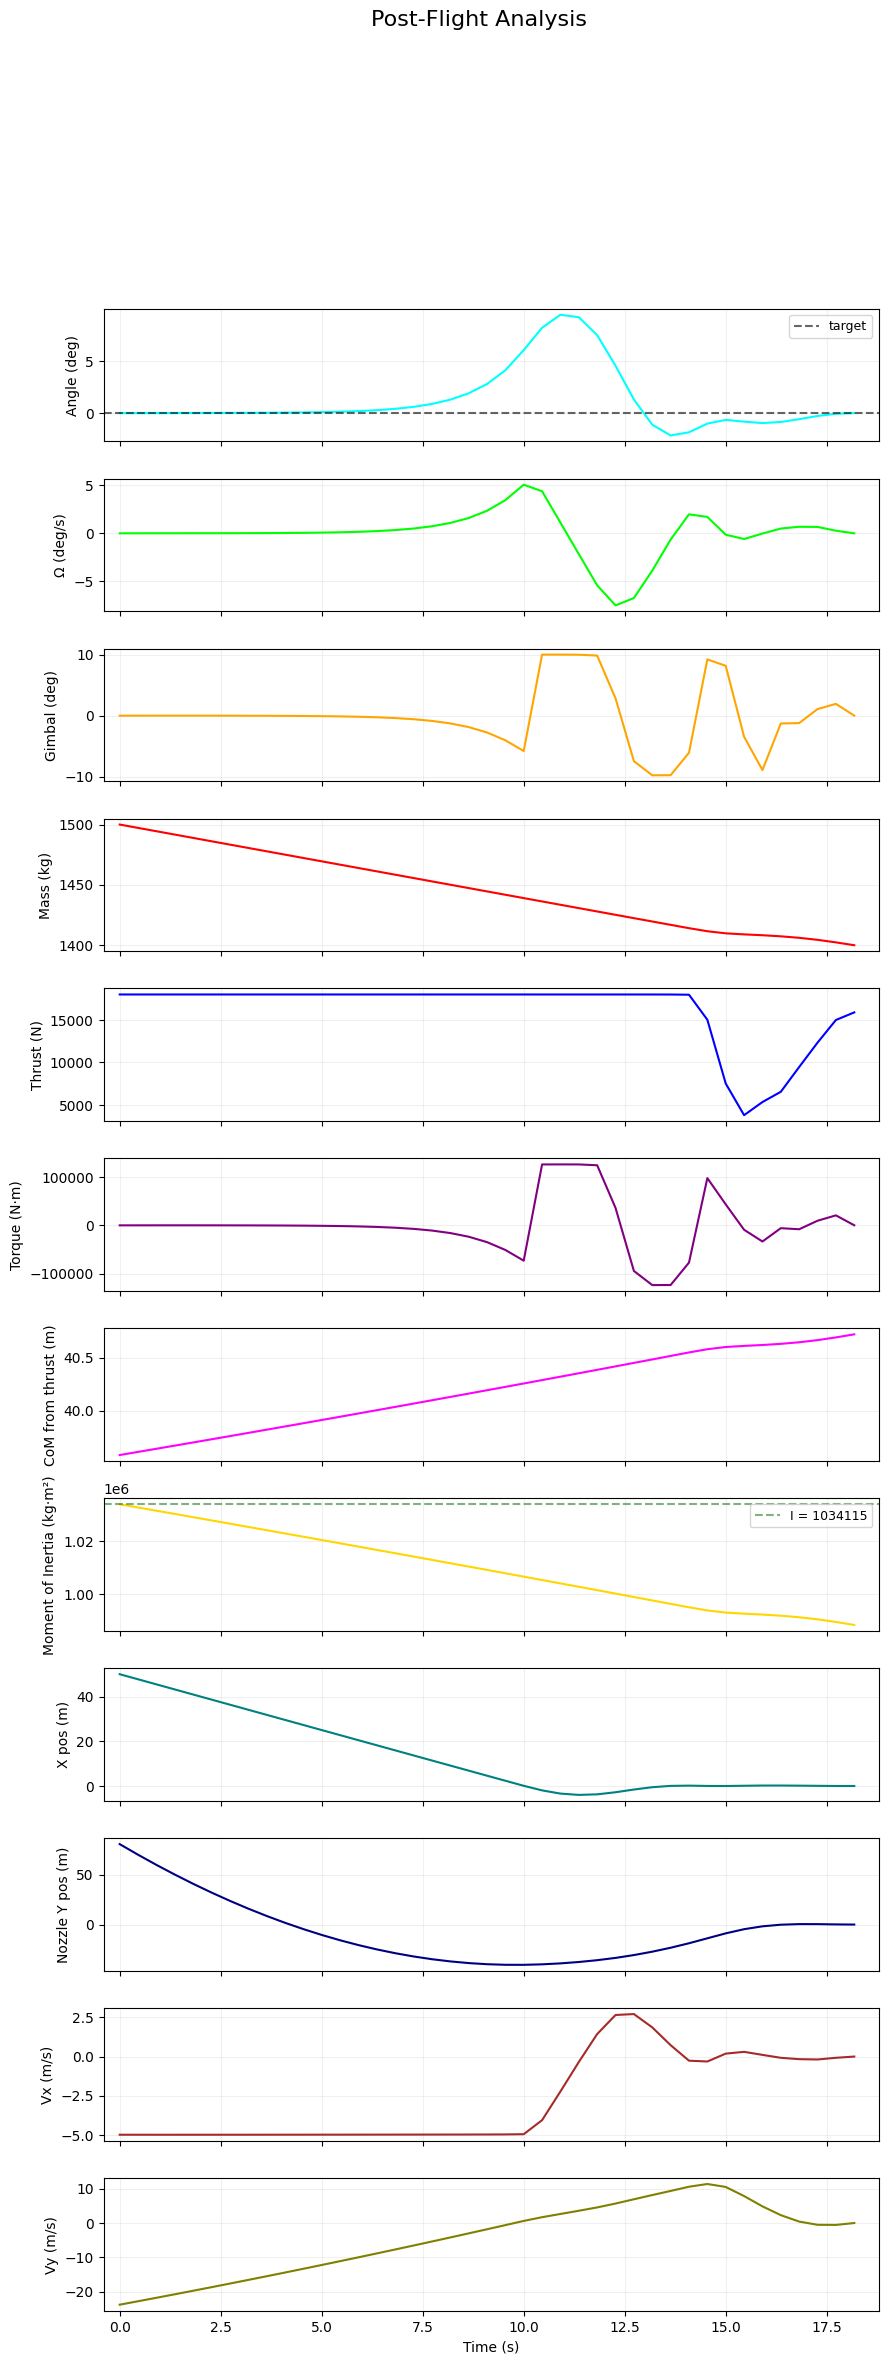

Saving animation...
Done.


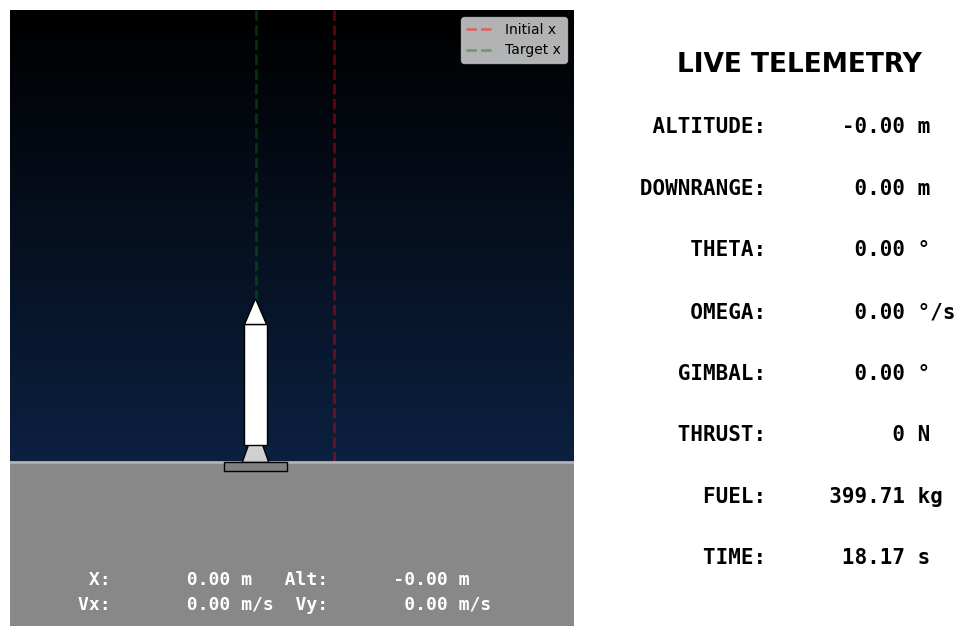

In [ ]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.patches import Polygon, FancyArrowPatch, Rectangle
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d

# ==========================================
# 1. Physics & Vehicle Configuration
# ==========================================
class RocketConfig:
    g = 9.81              # Gravity (m/s^2)
    I_sp = 300.0          # Specific Impulse (s)
    g0 = 9.81             # Standard gravity for Isp (m/s^2)
    v_e = I_sp * g0       # Exhaust velocity (m/s)
    m_dry = 1000.0        # Dry mass (kg)
    m_fuel = 500.0        # Fuel mass (kg)
    T_max = 18000.0       # Max Thrust (N)
    T_min = 000.0         # Min throttleable thrust (N)
    
    # Geometry for shifting CoM and I
    rocket_height = 95.0  # Total height from nozzle to nose tip (m)
    fuel_tank_height = rocket_height / 2
    dry_cm_from_nozzle = rocket_height / 2
    fuel_cm_from_nozzle = fuel_tank_height / 2

    alpha_max = np.deg2rad(10.0)  # Gimbal limit (rad)
    
    # Simulation settings
    N = 40                # Number of collocation nodes

config = RocketConfig()

# NumPy version for Animation/Plotting
def calculate_com_and_I(curr_mass):
    fuel_remaining = max(curr_mass - config.m_dry, 0.0)
    com_from_nozzle = (config.m_dry * config.dry_cm_from_nozzle + fuel_remaining * config.fuel_cm_from_nozzle) / curr_mass
    
    I_dry_cm = (1/12) * config.m_dry * config.rocket_height**2
    dry_distance = config.dry_cm_from_nozzle - com_from_nozzle
    I_dry = I_dry_cm + config.m_dry * dry_distance**2
    
    I_fuel_cm = (1/12) * fuel_remaining * config.fuel_tank_height**2 if fuel_remaining > 0 else 0
    fuel_distance = config.fuel_cm_from_nozzle - com_from_nozzle
    I_fuel = I_fuel_cm + fuel_remaining * fuel_distance**2
    
    I_z = I_dry + I_fuel
    return com_from_nozzle, I_z

# ==========================================
# 2. CasADi Optimal Landing Solver
# ==========================================
def solve_optimal_landing(initial_state):
    print("Setting up CasADi + IPOPT NLP...")
    opti = ca.Opti()
    N = config.N
    
    # --- Decision Variables ---
    X = opti.variable(7, N+1)  # States: [x, y, vx, vy, theta, omega, m]
    U = opti.variable(2, N+1)  # Controls: [T, alpha]
    tf = opti.variable()       # Final time
    dt = tf / N                # Time step
    
    # Extract variables for readability
    xs, ys, vxs, vys, thetas, omegas, ms = X[0,:], X[1,:], X[2,:], X[3,:], X[4,:], X[5,:], X[6,:]
    Ts, alphas = U[0,:], U[1,:]

    # --- CasADi Helper for CoM and I ---
    def calc_com_I_casadi(m):
        # m is constrained >= m_dry, so fuel_remaining is smoothly >= 0
        fuel_remaining = m - config.m_dry
        com_from_nozzle = (config.m_dry * config.dry_cm_from_nozzle + fuel_remaining * config.fuel_cm_from_nozzle) / m
        
        I_dry_cm = (1/12) * config.m_dry * config.rocket_height**2
        dry_dist = config.dry_cm_from_nozzle - com_from_nozzle
        I_dry = I_dry_cm + config.m_dry * dry_dist**2
        
        I_fuel_cm = (1/12) * fuel_remaining * config.fuel_tank_height**2
        fuel_dist = config.fuel_cm_from_nozzle - com_from_nozzle
        I_fuel = I_fuel_cm + fuel_remaining * fuel_dist**2
        
        I_z = I_dry + I_fuel
        return com_from_nozzle, I_z

    # --- Dynamics Function ---
    def rocket_dynamics_casadi(state, control):
        x, y, vx, vy, theta, omega, m = state[0], state[1], state[2], state[3], state[4], state[5], state[6]
        T, alpha = control[0], control[1]
        
        l_t, I_z = calc_com_I_casadi(m)
        thrust_angle = theta + alpha
        
        dx = vx
        dy = vy
        dvx = (T / m) * ca.sin(thrust_angle)
        dvy = (T / m) * ca.cos(thrust_angle) - config.g
        dtheta = omega
        # No need for I_z > 0 check, m is bounded >= m_dry, so I_z is safely positive
        domega = -(l_t * T / I_z) * ca.sin(alpha)
        dm = -T / config.v_e
        
        return ca.vertcat(dx, dy, dvx, dvy, dtheta, domega, dm)

    # --- Collocation Constraints (Trapezoidal) ---
    for k in range(N):
        s_k   = X[:, k]
        s_kp1 = X[:, k+1]
        u_k   = U[:, k]
        u_kp1 = U[:, k+1]
        
        f_k   = rocket_dynamics_casadi(s_k, u_k)
        f_kp1 = rocket_dynamics_casadi(s_kp1, u_kp1)
        
        # Defect constraint
        opti.subject_to(s_kp1 == s_k + 0.5 * dt * (f_k + f_kp1))

    # --- Boundary Conditions ---
    # Initial state
    opti.subject_to(X[:, 0] == initial_state)
    
    # Terminal state targets
    opti.subject_to(X[0, -1] == 0) # x = 0
    opti.subject_to(X[2, -1] == 0) # vx = 0
    opti.subject_to(X[3, -1] == 0) # vy = 0
    opti.subject_to(X[4, -1] == 0) # theta = 0
    opti.subject_to(X[5, -1] == 0) # omega = 0
    
    # Terminal height must equal CoM height at terminal mass
    com_term, _ = calc_com_I_casadi(X[6, -1])
    opti.subject_to(X[1, -1] == com_term)
    
    # Engine gimbal centered at touchdown
    opti.subject_to(U[1, -1] == 0.0)

    # --- Variable Bounds ---
    opti.subject_to(opti.bounded(1.0, tf, 60.0))
    opti.subject_to(opti.bounded(0.0, ys, ca.inf))             # y >= 0
    opti.subject_to(opti.bounded(-50.0, vxs, 50.0))            # vx
    opti.subject_to(opti.bounded(-100.0, vys, 50.0))           # vy
    opti.subject_to(opti.bounded(-0.5, omegas, 0.5))           # omega
    opti.subject_to(opti.bounded(config.m_dry, ms, initial_state[6])) # mass bounds
    opti.subject_to(opti.bounded(config.T_min, Ts, config.T_max))     # Thrust limits

    landing_nodes = 5
    tight_theta = np.deg2rad(2.0)
    tight_alpha = np.deg2rad(2.0)

    for k in range(N + 1):
        if k >= N + 1 - landing_nodes:
            opti.subject_to(opti.bounded(-tight_theta, thetas[k], tight_theta))
            opti.subject_to(opti.bounded(-tight_alpha, alphas[k], tight_alpha))
        else:
            opti.subject_to(opti.bounded(-ca.pi/4, thetas[k], ca.pi/4))
            opti.subject_to(opti.bounded(-config.alpha_max, alphas[k], config.alpha_max))

    # --- Objective Formulation ---
    w_time = 10.0
    w_thrust = 1e-3
    w_gimbal = 0.05
    w_gimbal_rate = 0.25
    w_theta = 0.5
    w_alt_thrust = 0.01
    w_landing = 2000.0

    J_time = w_time * tf
    J_thrust = w_thrust * dt * ca.sumsqr(Ts)
    J_gimbal = w_gimbal * dt * ca.sumsqr(alphas)
    
    gimbal_rates = ca.diff(alphas) / dt
    J_gimbal_rate = w_gimbal_rate * dt * ca.sumsqr(gimbal_rates)
    
    J_theta = w_theta * dt * ca.sumsqr(thetas)

    # Compute CoM heights for penalty mappings
    com_heights = [calc_com_I_casadi(ms[k])[0] for k in range(N+1)]
    com_heights = ca.horzcat(*com_heights)
    
    nozzle_heights = ys - com_heights
    clearance_zone = config.rocket_height * 2
    
    # Use CasADi's fmax for smooth-ish bounding
    ground_proximity = ca.fmax(0, 1.0 - nozzle_heights / clearance_zone)**3
    ground_violation = ca.fmax(0, -nozzle_heights)

    J_ground = 1e6 * ca.sumsqr(ground_violation)
    J_landing_theta = w_landing * dt * ca.sumsqr(thetas * ground_proximity)
    J_landing_gimbal = w_landing * dt * ca.sumsqr(alphas * ground_proximity)
    
    # Scale altitude penalty relative to start height
    y_norm = ys / initial_state[1]
    J_alt_thrust = w_alt_thrust * dt * ca.sum2((Ts**2) * y_norm)

    # Full Objective
    J = J_time + J_thrust + J_gimbal + J_gimbal_rate + J_theta + J_alt_thrust + J_ground + J_landing_theta + J_landing_gimbal
    opti.minimize(J)

    # --- Initial Guesses ---
    opti.set_initial(tf, 15.0)
    
    # Linear interpolation for states
    target_com, _ = calculate_com_and_I(config.m_dry)
    target_state = np.array([0, target_com, 0, 0, 0, 0, config.m_dry])
    for i in range(7):
        guess_traj = np.linspace(initial_state[i], target_state[i], N+1)
        opti.set_initial(X[i, :], guess_traj)
        
    hover_thrust = initial_state[6] * config.g
    opti.set_initial(Ts, np.clip(hover_thrust, config.T_min, config.T_max))
    opti.set_initial(alphas, 0.0)

    # --- Solve ---
    # Setup IPOPT options for maximum speed and exact Hessians
    p_opts = {"expand": True} 
    s_opts = {"max_iter": 500, "tol": 1e-6, "print_level": 5}
    opti.solver("ipopt", p_opts, s_opts)

    print("\nStarting Optimization with IPOPT...")
    try:
        sol = opti.solve()
        success = True
        print("\n--- Solution Report ---")
        print(f"  Converged:        {success}")
        
    except RuntimeError:
        # If it fails, extract the closest guess for debugging
        sol = opti.debug
        success = False
        print("\n  WARNING: Optimizer did not fully converge.")
        print("  The solution may be approximate. Try adjusting initial conditions.")

    states_sol = sol.value(X).T
    controls_sol = sol.value(U).T
    tf_sol = sol.value(tf)
    
    final_pos_err = np.linalg.norm(states_sol[-1, 0:2])
    final_vel_err = np.linalg.norm(states_sol[-1, 2:4])
    
    print(f"  Landing time:     {tf_sol:.3f} s")
    print(f"  Final pos error:  {final_pos_err:.4f} m")
    print(f"  Final vel error:  {final_vel_err:.4f} m/s")
    print(f"  Fuel consumed:    {initial_state[6] - states_sol[-1, 6]:.2f} kg")

    return states_sol, controls_sol, tf_sol, sol

# ==========================================
# 3. Animation & Plotting (Untouched)
# ==========================================
def rotate_point(x, y, pivot_x, pivot_y, angle_deg):
    angle_rad = np.radians(angle_deg)
    nx, ny = x - pivot_x, y - pivot_y
    s, c = np.sin(-angle_rad), np.cos(-angle_rad)
    rx = nx * c - ny * s
    ry = nx * s + ny * c
    return rx + pivot_x, ry + pivot_y

def get_rotated_points(points_list, pivot, angle):
    return [rotate_point(p[0], p[1], pivot[0], pivot[1], angle) for p in points_list]

def animate_results(states, controls, tf):
    N = states.shape[0] - 1
    sim_times = np.linspace(0, tf, N + 1)
    
    fps = 30
    hold_time_start = 2.0
    hold_time_end = 2.0
    num_hold_start = int(hold_time_start * fps)
    num_hold_end = int(hold_time_end * fps)
    num_anim_frames = int(tf * fps) + 1
    anim_times = np.linspace(0, tf, num_anim_frames)
    
    dt_anim = anim_times[1] - anim_times[0] if num_anim_frames > 1 else 0
    
    x_coms = interp1d(sim_times, states[:, 0])(anim_times)
    y_coms = interp1d(sim_times, states[:, 1])(anim_times)
    vxs    = interp1d(sim_times, states[:, 2])(anim_times)
    vys    = interp1d(sim_times, states[:, 3])(anim_times)
    angles = np.rad2deg(interp1d(sim_times, states[:, 4])(anim_times))
    omegas = np.rad2deg(interp1d(sim_times, states[:, 5])(anim_times))
    masses = interp1d(sim_times, states[:, 6])(anim_times)
    
    thrusts = interp1d(sim_times, controls[:, 0])(anim_times)
    gimbals = np.rad2deg(interp1d(sim_times, controls[:, 1])(anim_times))
    
    thrusts[-1] = 0
    gimbals[-1] = 0
    
    coms = np.array([calculate_com_and_I(m)[0] for m in masses])
    I_zs = np.array([calculate_com_and_I(m)[1] for m in masses])
    
    # Add start hold
    x_coms = np.concatenate((np.full(num_hold_start, x_coms[0]), x_coms))
    y_coms = np.concatenate((np.full(num_hold_start, y_coms[0]), y_coms))
    vxs = np.concatenate((np.full(num_hold_start, vxs[0]), vxs))
    vys = np.concatenate((np.full(num_hold_start, vys[0]), vys))
    angles = np.concatenate((np.full(num_hold_start, angles[0]), angles))
    omegas = np.concatenate((np.full(num_hold_start, omegas[0]), omegas))
    masses = np.concatenate((np.full(num_hold_start, masses[0]), masses))
    thrusts = np.concatenate((np.full(num_hold_start, thrusts[0]), thrusts))
    gimbals = np.concatenate((np.full(num_hold_start, gimbals[0]), gimbals))
    coms = np.concatenate((np.full(num_hold_start, coms[0]), coms))
    I_zs = np.concatenate((np.full(num_hold_start, I_zs[0]), I_zs))
    
    # Add end hold
    x_coms  = np.append(x_coms,  np.full(num_hold_end, x_coms[-1]))
    y_coms  = np.append(y_coms,  np.full(num_hold_end, y_coms[-1]))
    vxs     = np.append(vxs,     np.full(num_hold_end, 0.0))
    vys     = np.append(vys,     np.full(num_hold_end, 0.0))
    angles  = np.append(angles,  np.full(num_hold_end, angles[-1]))
    omegas  = np.append(omegas,  np.full(num_hold_end, 0.0))
    masses  = np.append(masses,  np.full(num_hold_end, masses[-1]))
    thrusts = np.append(thrusts, np.full(num_hold_end, 0.0))
    gimbals = np.append(gimbals, np.full(num_hold_end, gimbals[-1])) 
    coms    = np.append(coms,    np.full(num_hold_end, coms[-1]))
    I_zs    = np.append(I_zs,    np.full(num_hold_end, I_zs[-1]))
    
    anim_times_start = np.linspace(-hold_time_start, -dt_anim, num_hold_start)
    anim_times_end = np.linspace(tf + dt_anim, tf + hold_time_end, num_hold_end)
    anim_times = np.concatenate((anim_times_start, anim_times, anim_times_end))
    num_anim_frames += num_hold_start + num_hold_end
    
    margin = config.rocket_height * 1.5
    x_min = min(x_coms) - margin
    x_max = max(x_coms) + margin
    y_min = -config.rocket_height
    y_max = max(y_coms) + margin
    x_span = x_max - x_min
    y_span = y_max - y_min
    if x_span < y_span:
        extra = (y_span - x_span) / 2
        x_min -= extra
        x_max += extra
    elif y_span < x_span:
        extra = (x_span - y_span) / 2
        y_min -= extra
        y_max += extra

    fig, (ax, ax_info) = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [2, 1]})
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')
    ax.axis('off')

    custom_cmap = LinearSegmentedColormap.from_list("sky", ["#102C57", "#000000"])
    ax.imshow(np.linspace(0, 1, 100).reshape(-1, 1), extent=[x_min, x_max, y_min, y_max],
              origin='lower', cmap=custom_cmap, aspect='auto')

    ax.axhspan(y_min, 0, color="#888888", zorder=1)
    ax.axhline(0, color="#B1B1B1", linewidth=2, zorder=2)

    initial_x_line, = ax.plot([x_coms[0], x_coms[0]], [0, y_max], color='red', ls='--', lw=2, zorder=1.5, alpha=0.4, label="Initial x")
    target_x_line, = ax.plot([0, 0], [0, y_max], color='green', ls='--', lw=2, zorder=1.5, alpha=0.4, label="Target x")

    pad = Rectangle((-20, -5), 40, 5, fc="gray", ec="black", zorder=3)
    ax.add_patch(pad)

    body_patch   = Polygon([[0,0]], fc="white",   ec="black", zorder=11)
    nose_patch   = Polygon([[0,0]], fc="white",   ec="black", zorder=12)
    engine_patch = Polygon([[0,0]], fc="#D0D0D0", ec="black", zorder=10)
    flame_patch  = Polygon([[0,0]], fc="orange",  ec="red",   lw=1.5, zorder=9, visible=False)
    ax.add_patch(body_patch)
    ax.add_patch(nose_patch)
    ax.add_patch(engine_patch)
    ax.add_patch(flame_patch)

    arrow_length = abs(x_max - x_min) * 0.1
    vel_arrow = FancyArrowPatch(
        (0,0), (0,0),
        arrowstyle = "simple, head_width=9, head_length=9, tail_width=4",
        mutation_scale = 1.5, facecolor = 'cyan', edgecolor = 'black',
        linewidth = 1.5, zorder = 20, visible = False, label = "Initial Velocity"
    )
    ax.add_patch(vel_arrow)

    pos_vel_text1 = ax.text(0.12, 0.06, '', transform=ax.transAxes, color='white',
                            fontsize=13, family='monospace', fontweight='bold', va='bottom', ha='left')
    pos_vel_text2 = ax.text(0.12, 0.02, '', transform=ax.transAxes, color='white',
                            fontsize=13, family='monospace', fontweight='bold', va='bottom', ha='left')

    ax_info.set_facecolor('white')
    ax_info.axis('off')
    left_bound = -0.2
    fontsize = 15
    txt_alt      = ax_info.text(left_bound, 0.8, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_downrange= ax_info.text(left_bound, 0.7, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_theta    = ax_info.text(left_bound, 0.6, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_omega    = ax_info.text(left_bound, 0.5, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_gimbal   = ax_info.text(left_bound, 0.4, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_thrust   = ax_info.text(left_bound, 0.3, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_fuel     = ax_info.text(left_bound, 0.2, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_time     = ax_info.text(left_bound, 0.1, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    ax_info.text(0.5, 0.9, "LIVE TELEMETRY", color='black', fontsize=fontsize + 4, fontweight='bold', ha="center")

    body_raw = [[-7,10], [7,10], [7,80], [-7,80]]
    nose_raw = [[-7,80], [7,80], [0,95]]
    engine_attach = (0, 10)
    engine_raw = [[-8.4,0], [8.4,0], [4.5,10], [-4.5,10]]
    engine_rel = [(ex - engine_attach[0], ey - engine_attach[1]) for ex, ey in engine_raw]

    base_flame_length = 25
    flame_raw = [[-5.6,0], [5.6,0], [0, -base_flame_length]]
    flame_rel = [(fx - engine_attach[0], fy - engine_attach[1]) for fx, fy in flame_raw]

    def animate(i):
        t_val  = angles[i]
        g_val  = gimbals[i]
        thr_val= thrusts[i]
        cx = x_coms[i]
        cy = y_coms[i]
        vx_i, vy_i = vxs[i], vys[i]
        com = coms[i]

        body_local = [[px, py - com] for px, py in body_raw]
        nose_local = [[px, py - com] for px, py in nose_raw]
        engine_attach_local = (0, 10 - com)

        body_rot   = get_rotated_points(body_local, (0, 0), t_val)
        nose_rot   = get_rotated_points(nose_local, (0, 0), t_val)

        engine_gimb_rel = get_rotated_points(engine_rel, (0, 0), g_val)
        engine_local    = [(ex + engine_attach_local[0], ey + engine_attach_local[1]) for ex, ey in engine_gimb_rel]
        engine_rot      = get_rotated_points(engine_local, (0, 0), t_val)

        flame_length = base_flame_length * (thr_val / config.T_max) if config.T_max > 0 else 0
        flame_rel_scaled = [(fx, fy * (flame_length / base_flame_length)) for fx, fy in flame_rel]
        flame_gimb_rel = get_rotated_points(flame_rel_scaled, (0, 0), g_val)
        flame_local    = [(fx + engine_attach_local[0], fy + engine_attach_local[1]) for fx, fy in flame_gimb_rel]
        flame_rot      = get_rotated_points(flame_local, (0, 0), t_val)

        body_patch.set_xy(  [(px + cx, py + cy) for px, py in body_rot])
        nose_patch.set_xy(  [(px + cx, py + cy) for px, py in nose_rot])
        engine_patch.set_xy([(px + cx, py + cy) for px, py in engine_rot])
        flame_patch.set_xy( [(px + cx, py + cy) for px, py in flame_rot])
        flame_patch.set_visible(thr_val > 0)

        LABEL_WIDTH = len("FUEL BURNED:") + 1
        VALUE_WIDTH = 11

        txt_alt.set_text(      f"{'ALTITUDE:':>{LABEL_WIDTH}}{y_coms[i] - coms[i]:>{VALUE_WIDTH}.2f} m")
        txt_downrange.set_text(f"{'DOWNRANGE:':>{LABEL_WIDTH}}{x_coms[i]:>{VALUE_WIDTH}.2f} m")
        txt_theta.set_text(    f"{'THETA:':>{LABEL_WIDTH}}{t_val:>{VALUE_WIDTH}.2f} °")
        txt_omega.set_text(    f"{'OMEGA:':>{LABEL_WIDTH}}{omegas[i]:>{VALUE_WIDTH}.2f} °/s")
        txt_gimbal.set_text(   f"{'GIMBAL:':>{LABEL_WIDTH}}{g_val:>{VALUE_WIDTH}.2f} °")
        txt_thrust.set_text(   f"{'THRUST:':>{LABEL_WIDTH}}{thr_val:>{VALUE_WIDTH}.0f} N")
        txt_fuel.set_text(     f"{'FUEL:':>{LABEL_WIDTH}}{masses[i] - config.m_dry:>{VALUE_WIDTH}.2f} kg")
        txt_time.set_text(     f"{'TIME:':>{LABEL_WIDTH}}{max(0, min(anim_times[i], tf)):>{VALUE_WIDTH}.2f} s")

        pos_vel_text1.set_text(f" X: {x_coms[i]:10.2f} m   Alt: {y_coms[i] - coms[i]:10.2f} m")
        pos_vel_text2.set_text(f"Vx: {vxs[i]:10.2f} m/s  Vy: {vys[i]:10.2f} m/s")

        show_vel_arrow = anim_times[i] < 0
        speed = np.sqrt(vx_i**2 + vy_i**2)
        if show_vel_arrow and speed > 1e-3:
            base_x, base_y = cx, cy
            dx = (vx_i / speed) * arrow_length
            dy = (vy_i / speed) * arrow_length
            vel_arrow.set_positions((base_x, base_y), (base_x + dx, base_y + dy))
            vel_arrow.set_visible(True)
        else:
            vel_arrow.set_visible(False)

        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

        if show_vel_arrow and speed > 1e-3:
            handles = [initial_x_line, target_x_line, vel_arrow]
            labels = ["Initial x", "Target x", "Initial Velocity"]
            ax.legend(handles, labels, loc='upper right', fontsize=10, framealpha=0.7)
        else:
            handles = [initial_x_line, target_x_line]
            labels = ["Initial x", "Target x"]
            ax.legend(handles, labels, loc='upper right', fontsize=10, framealpha=0.7)

        return (body_patch, nose_patch, engine_patch, flame_patch,
                txt_alt, txt_downrange, txt_theta, txt_omega, txt_gimbal,
                txt_thrust, txt_fuel, txt_time, pos_vel_text1, pos_vel_text2, vel_arrow)

    ani = FuncAnimation(fig, animate, frames=range(num_anim_frames), interval=1000 // fps, blit=True)

    print("Saving animation...")
    writer = FFMpegWriter(fps=fps, bitrate=2500)
    ani.save("results/rocket_casadi_3.mp4", writer=writer)
    print("Done.")
    plt.show()

# ==========================================
# 4. Main Execution
# ==========================================
if __name__ == "__main__":
    print("--- Time-Optimal Rocket Landing Solver ---")
    
    h_0, x_0, vx_0, vy_0 = 80.42, 50.0, -5.0, -70.0

    initial_m = config.m_dry + config.m_fuel
    initial_com, _ = calculate_com_and_I(initial_m)
    s0 = np.array([x_0, h_0 + initial_com, vx_0, vy_0, 0.0, 0.0, initial_m])
    
    print(f"\nInitial state: {s0}")
    
    states, controls, tf, raw_res = solve_optimal_landing(s0)
    
    if states is not None:
        fig_diag, axs = plt.subplots(12, 1, figsize=(10, 26), sharex=True)
        plt.subplots_adjust(hspace=0.28)

        times       = np.linspace(0, tf, states.shape[0])
        angles_deg  = np.rad2deg(states[:, 4])
        omegas_deg  = np.rad2deg(states[:, 5])
        gimbals_deg = np.rad2deg(controls[:, 1])
        masses      = states[:, 6]
        thrusts     = controls[:, 0]
        coms        = np.array([calculate_com_and_I(m)[0] for m in masses])
        I_zs        = np.array([calculate_com_and_I(m)[1] for m in masses])
        torques     = coms * thrusts * np.sin(np.radians(gimbals_deg))
        x_coms      = states[:, 0]
        y_coms      = states[:, 1]
        y_nozzle    = y_coms - coms
        vxs         = states[:, 2]
        vys         = states[:, 3]

        plot_data = [angles_deg, omegas_deg, gimbals_deg, masses, thrusts, torques,
                     coms, I_zs, x_coms, y_nozzle, vxs, vys]
        labels = ['Angle (deg)', 'Ω (deg/s)', 'Gimbal (deg)', 'Mass (kg)', 'Thrust (N)',
                  'Torque (N·m)', 'CoM from thrust (m)', 'Moment of Inertia (kg·m²)',
                  'X pos (m)', 'Nozzle Y pos (m)', 'Vx (m/s)', 'Vy (m/s)']
        colors = ['cyan','lime','orange','red','blue','purple','magenta','gold','teal','navy','brown','olive']

        for i, ax in enumerate(axs):
            ax.plot(times, plot_data[i], color=colors[i])
            ax.set_ylabel(labels[i])
            ax.set_facecolor("#ffffff")
            ax.grid(True, alpha=0.18)
            ax.set_xlim(-0.4, times[-1] + 0.6)

        axs[0].axhline(0, color='black', linestyle='--', alpha=0.6, label="target")
        axs[0].legend(fontsize=9)
        axs[7].axhline(I_zs[0], color='darkgreen', ls='--', alpha=0.5, label=f"I = {I_zs[0]:.0f}")
        axs[7].legend(fontsize=9, loc='upper right')
        axs[-1].set_xlabel("Time (s)")

        plt.suptitle("Post-Flight Analysis", fontsize=16, y=0.995)
        plt.show()

        animate_results(states, controls, tf)

## With controllability check

--- Time-Optimal Rocket Landing Solver ---

Initial state:
  [  50.          280.00333333   -6.          -25.            0.
    0.         1500.        ]
  Fuel mass   :  500.0 kg
  Dry mass    : 1000.0 kg
  Initial CoM :  39.58 m from nozzle
  Nozzle alt  :  240.4 m

Checking approximate controllability...
→ Approximate check passed. Starting optimization...
Setting up CasADi + IPOPT NLP...

Starting Optimization with IPOPT...
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2055
Number of nonzeros in inequality constraint Jacobian.:      329
Number of nonzeros in Lagrangian Hessian.............:     1230

Total number of variables............................:      370
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints...........

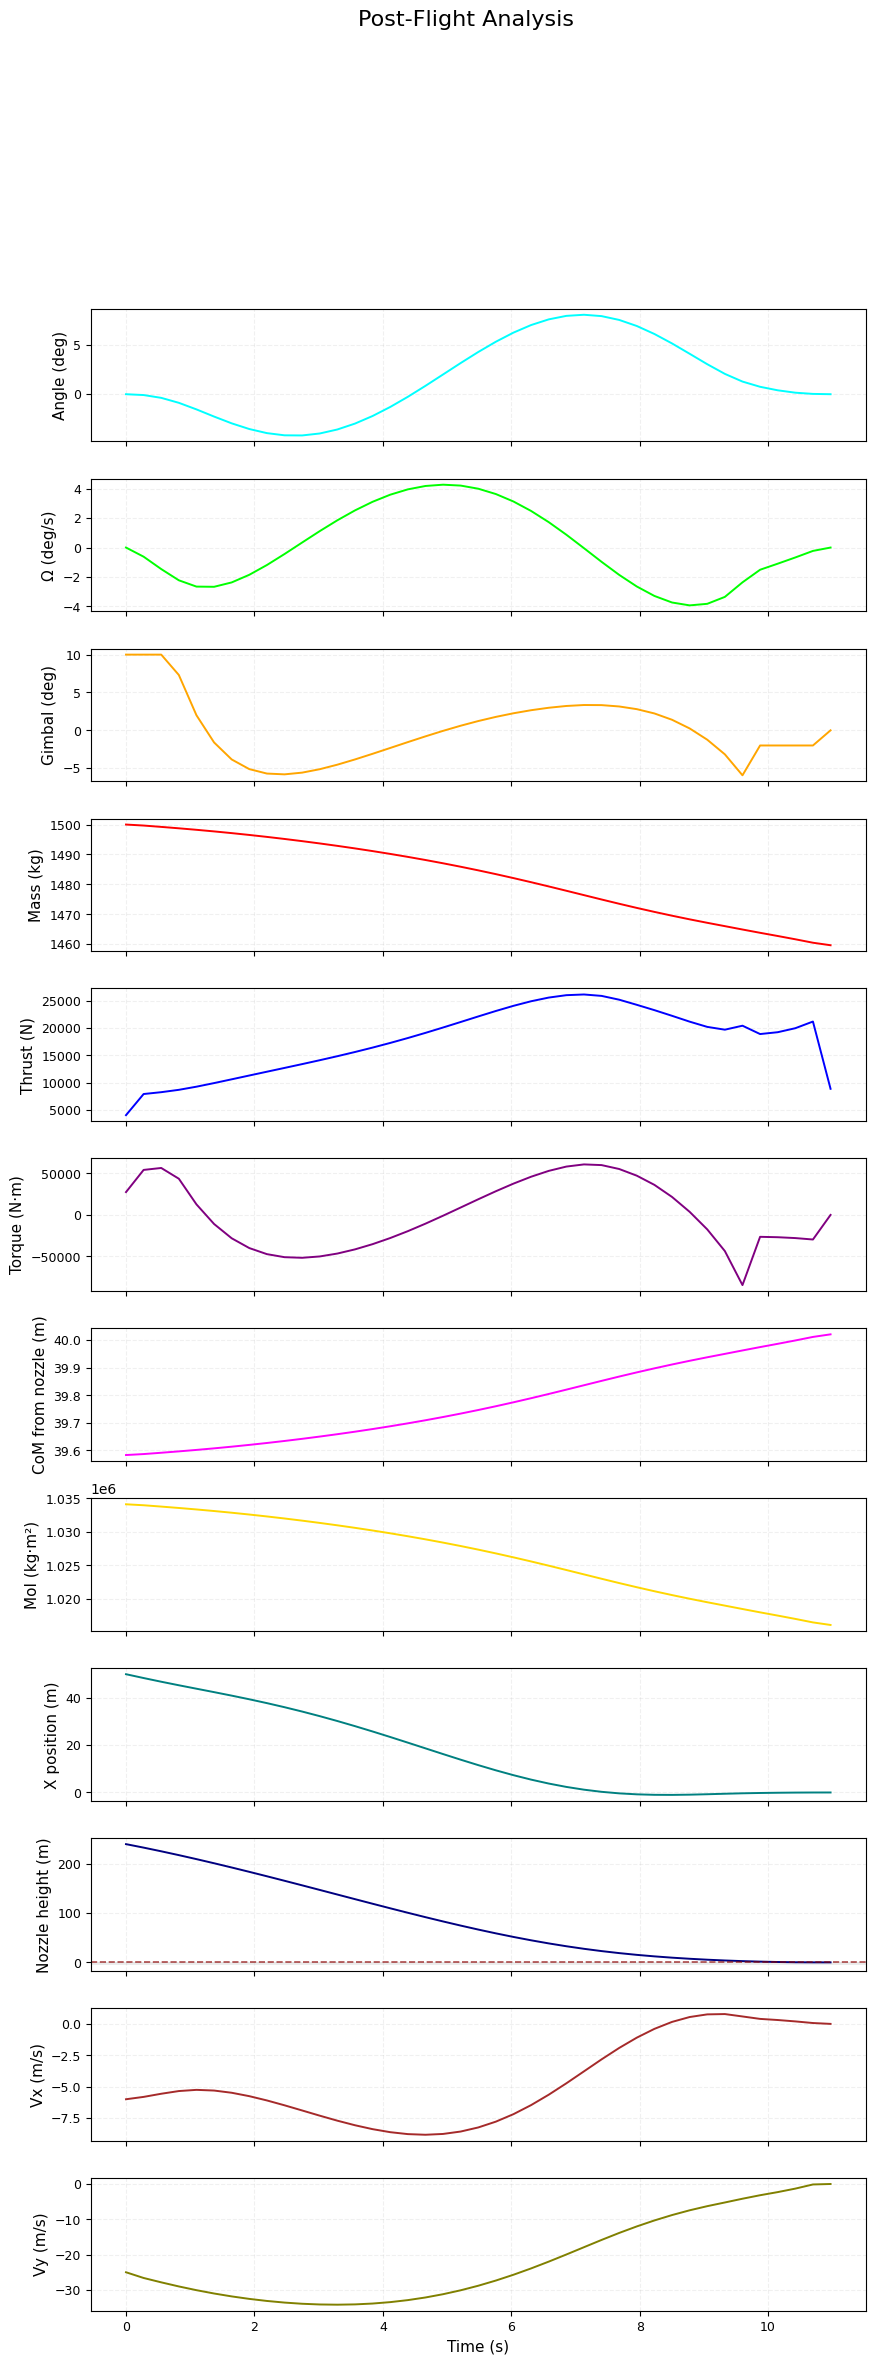


Landing looks good within tolerances!
  X-offset:       0.000 m
  Y-offset:       0.000 m (Positive = Floating, Negative = Sunk)
  Velocity err:   0.000 m/s
  Min nozzle:     0.000 m
Generating animation...

Saving animation...
Done.


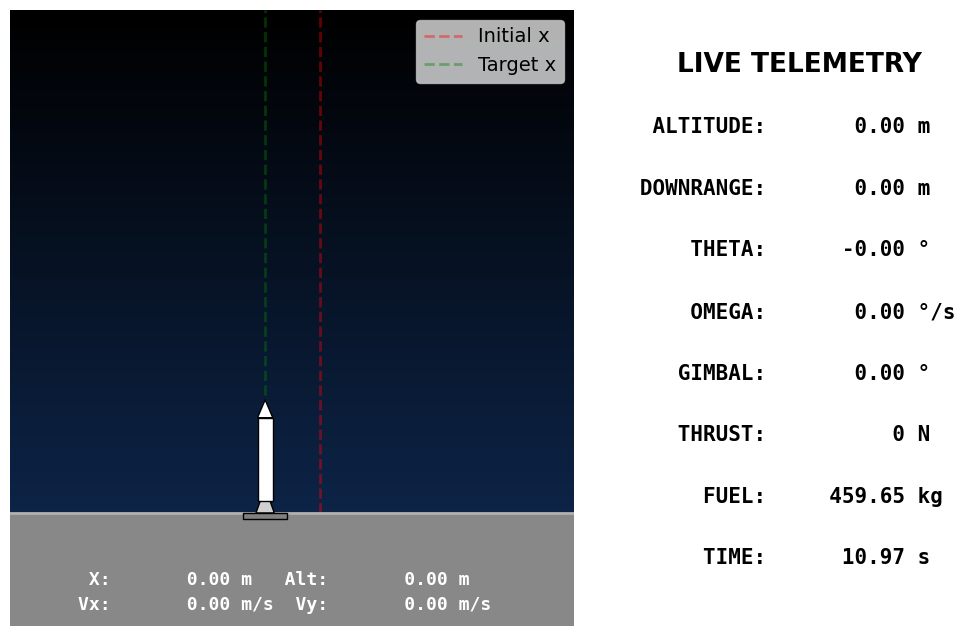

In [48]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.patches import Polygon, FancyArrowPatch, Rectangle
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d
# ==========================================
# 1. Physics & Vehicle Configuration
# ==========================================
class RocketConfig:
    g = 9.81              # Gravity (m/s^2)
    I_sp = 500.0          # Specific Impulse (s)
    g0 = 9.81             # Standard gravity for Isp (m/s^2)
    v_e = I_sp * g0       # Exhaust velocity (m/s)
    m_dry = 1000.0        # Dry mass (kg)
    m_fuel = 500.0        # Fuel mass (kg)
    T_max = 60000.0       # Max Thrust (N)
    T_min = 4000.0         # Min throttleable thrust (N)
   
    # Geometry for shifting CoM and I
    rocket_height = 95.0  # Total height from nozzle to nose tip (m)
    fuel_tank_height = rocket_height / 2
    dry_cm_from_nozzle = rocket_height / 2
    fuel_cm_from_nozzle = fuel_tank_height / 2
    alpha_max = np.deg2rad(10.0)  # Gimbal limit (rad)
   
    # Simulation settings
    N = 40                # Number of collocation nodes
config = RocketConfig()
# NumPy version for Animation/Plotting
def calculate_com_and_I(curr_mass):
    fuel_remaining = max(curr_mass - config.m_dry, 0.0)
    com_from_nozzle = (config.m_dry * config.dry_cm_from_nozzle + fuel_remaining * config.fuel_cm_from_nozzle) / curr_mass
   
    I_dry_cm = (1/12) * config.m_dry * config.rocket_height**2
    dry_distance = config.dry_cm_from_nozzle - com_from_nozzle
    I_dry = I_dry_cm + config.m_dry * dry_distance**2
   
    I_fuel_cm = (1/12) * fuel_remaining * config.fuel_tank_height**2 if fuel_remaining > 0 else 0
    fuel_distance = config.fuel_cm_from_nozzle - com_from_nozzle
    I_fuel = I_fuel_cm + fuel_remaining * fuel_distance**2
   
    I_z = I_dry + I_fuel
    return com_from_nozzle, I_z
# ==========================================
# Approximate Controllability Check
# ==========================================
def approx_controllable(initial_state, config):
    x, y, vx, vy, theta, omega, m = initial_state
    fuel_mass = m - config.m_dry

    # Basic sanity
    if fuel_mass < 1e-6:
        print("No usable fuel → cannot control attitude, position or rate.")
        return False

    com, _ = calculate_com_and_I(m)
    nozzle_y = y - com
    if nozzle_y < -0.1:  # already in/through ground
        return False

    # Very basic thrust-to-weight check (must at least be able to hover)
    hover_thrust_needed = m * config.g
    if config.T_max < 0.6 * hover_thrust_needed:  # quite conservative
        print("Thrust too low even to hover.")
        return False

    # Very rough delta-v budget check
    dv_available = config.v_e * np.log(m / config.m_dry)

    # Required dv ≈ current speed + gravity losses + some margin for steering
    speed = np.sqrt(vx**2 + vy**2)
    dv_required_rough = speed + 1.5 * config.g * (abs(vy)/config.g + 5)  # crude

    if dv_available < 0.6 * dv_required_rough:
        print(f"Delta-v budget too low: {dv_available:.1f} <~ {dv_required_rough:.1f} m/s")
        return False

    # Attitude / angular rate — very crude
    if abs(theta) > np.deg2rad(25) or abs(omega) > np.deg2rad(35):
        print("Initial attitude or rate too extreme for recovery with limited control.")
        return False

    # Horizontal distance — very crude
    if abs(x) > 800:   # arbitrary — depends on your vehicle
        print("Too far downrange for realistic recovery.")
        return False

    return True
# ==========================================
# 2. CasADi Optimal Landing Solver
# ==========================================
def solve_optimal_landing(initial_state):
    print("Setting up CasADi + IPOPT NLP...")
    opti = ca.Opti()
    N = config.N
   
    # --- Decision Variables ---
    X = opti.variable(7, N+1)  # States: [x, y, vx, vy, theta, omega, m]
    U = opti.variable(2, N+1)  # Controls: [T, alpha]
    tf = opti.variable()       # Final time
    dt = tf / N                # Time step
   
    # Extract variables for readability
    xs, ys, vxs, vys, thetas, omegas, ms = X[0,:], X[1,:], X[2,:], X[3,:], X[4,:], X[5,:], X[6,:]
    Ts, alphas = U[0,:], U[1,:]
    # --- CasADi Helper for CoM and I ---
    def calc_com_I_casadi(m):
        # m is constrained >= m_dry, so fuel_remaining is smoothly >= 0
        fuel_remaining = m - config.m_dry
        com_from_nozzle = (config.m_dry * config.dry_cm_from_nozzle + fuel_remaining * config.fuel_cm_from_nozzle) / m
       
        I_dry_cm = (1/12) * config.m_dry * config.rocket_height**2
        dry_dist = config.dry_cm_from_nozzle - com_from_nozzle
        I_dry = I_dry_cm + config.m_dry * dry_dist**2
       
        I_fuel_cm = (1/12) * fuel_remaining * config.fuel_tank_height**2
        fuel_dist = config.fuel_cm_from_nozzle - com_from_nozzle
        I_fuel = I_fuel_cm + fuel_remaining * fuel_dist**2
       
        I_z = I_dry + I_fuel
        return com_from_nozzle, I_z
    # --- Dynamics Function ---
    def rocket_dynamics_casadi(state, control):
        x, y, vx, vy, theta, omega, m = state[0], state[1], state[2], state[3], state[4], state[5], state[6]
        T, alpha = control[0], control[1]
       
        l_t, I_z = calc_com_I_casadi(m)
        thrust_angle = theta + alpha
       
        dx = vx
        dy = vy
        dvx = (T / m) * ca.sin(thrust_angle)
        dvy = (T / m) * ca.cos(thrust_angle) - config.g
        dtheta = omega
        # No need for I_z > 0 check, m is bounded >= m_dry, so I_z is safely positive
        domega = -(l_t * T / I_z) * ca.sin(alpha)
        dm = -T / config.v_e
       
        return ca.vertcat(dx, dy, dvx, dvy, dtheta, domega, dm)
    # --- Collocation Constraints (Trapezoidal) ---
    for k in range(N):
        s_k   = X[:, k]
        s_kp1 = X[:, k+1]
        u_k   = U[:, k]
        u_kp1 = U[:, k+1]
       
        f_k   = rocket_dynamics_casadi(s_k, u_k)
        f_kp1 = rocket_dynamics_casadi(s_kp1, u_kp1)
       
        # Defect constraint
        opti.subject_to(s_kp1 == s_k + 0.5 * dt * (f_k + f_kp1))
    # --- Boundary Conditions ---
    # Initial state
    opti.subject_to(X[:, 0] == initial_state)
   
    # Terminal state targets
    opti.subject_to(X[0, -1] == 0) # x = 0
    opti.subject_to(X[2, -1] == 0) # vx = 0
    opti.subject_to(X[3, -1] == 0) # vy = 0
    opti.subject_to(X[4, -1] == 0) # theta = 0
    opti.subject_to(X[5, -1] == 0) # omega = 0
   
    # Terminal height must equal CoM height at terminal mass
    com_term, _ = calc_com_I_casadi(X[6, -1])
    opti.subject_to(X[1, -1] == com_term)
   
    # Engine gimbal centered at touchdown
    opti.subject_to(U[1, -1] == 0.0)
    # --- Variable Bounds ---
    opti.subject_to(opti.bounded(1.0, tf, 60.0))
    opti.subject_to(opti.bounded(0.0, ys, ca.inf))             # y >= 0
    opti.subject_to(opti.bounded(-50.0, vxs, 50.0))            # vx
    opti.subject_to(opti.bounded(-100.0, vys, 50.0))           # vy
    opti.subject_to(opti.bounded(-0.5, omegas, 0.5))           # omega
    opti.subject_to(opti.bounded(config.m_dry, ms, initial_state[6])) # mass bounds
    opti.subject_to(opti.bounded(config.T_min, Ts, config.T_max))     # Thrust limits
    
    # controls stability on the landing
    landing_nodes = 5

    tight_theta = np.deg2rad(2.0)
    tight_alpha = np.deg2rad(2.0)
    for k in range(N + 1):
        if k >= N + 1 - landing_nodes:
            opti.subject_to(opti.bounded(-tight_theta, thetas[k], tight_theta))
            opti.subject_to(opti.bounded(-tight_alpha, alphas[k], tight_alpha))
        else:
            opti.subject_to(opti.bounded(-ca.pi/4, thetas[k], ca.pi/4))
            opti.subject_to(opti.bounded(-config.alpha_max, alphas[k], config.alpha_max))
    # --- Objective Formulation ---
    epsilon = 20.0          # [m] — softening to avoid singularity
    w_time = 10.0
    w_thrust = 1e-10
    w_gimbal = 0.05
    w_gimbal_rate = 0.25
    w_theta = 2.0
    w_alt_thrust = 6e-6
    w_landing = 4000.0
    w_v = 50.0
    J_time = w_time * tf
    J_thrust = w_thrust * dt * ca.sumsqr(Ts)
    J_gimbal = w_gimbal * dt * ca.sumsqr(alphas)
   
    gimbal_rates = ca.diff(alphas) / dt
    J_gimbal_rate = w_gimbal_rate * dt * ca.sumsqr(gimbal_rates)
   
    J_theta = w_theta * dt * ca.sumsqr(thetas)
    # Compute CoM heights for penalty mappings
    com_heights = [calc_com_I_casadi(ms[k])[0] for k in range(N+1)]
    com_heights = ca.horzcat(*com_heights)
    nozzle_heights = ys - com_heights
    clearance_zone = config.rocket_height * 2
   
    # Use CasADi's fmax for smooth-ish bounding
    ground_proximity = ca.fmax(0, 1.0 - nozzle_heights / clearance_zone)**3
    ground_violation = ca.fmax(0, -nozzle_heights)
    h_nozzle_safe = ca.fmax(epsilon, nozzle_heights)   # never goes below ε
    J_inverse_h = w_v * dt * ca.sum2( (vxs**2 + vys**2) / h_nozzle_safe )
    J_ground = 1e6 * ca.sumsqr(ground_violation)
    J_landing_theta = w_landing * dt * ca.sumsqr(thetas * ground_proximity)
    J_landing_gimbal = w_landing * dt * ca.sumsqr(alphas * ground_proximity)
   
    # Scale altitude penalty relative to start height
    y_norm = ys / initial_state[1]
    J_alt_thrust = w_alt_thrust * dt * ca.sum2((Ts**2) * y_norm)
    # Full Objective
    J = J_time + J_thrust + J_gimbal + J_gimbal_rate + J_theta + J_alt_thrust + J_ground + J_landing_theta + J_landing_gimbal + J_inverse_h
    opti.minimize(J)
    # --- Initial Guesses ---
    opti.set_initial(tf, 15.0)
   
    # Linear interpolation for states
    target_com, _ = calculate_com_and_I(config.m_dry)
    target_state = np.array([0, target_com, 0, 0, 0, 0, config.m_dry])
    for i in range(7):
        guess_traj = np.linspace(initial_state[i], target_state[i], N+1)
        opti.set_initial(X[i, :], guess_traj)
       
    hover_thrust = initial_state[6] * config.g
    opti.set_initial(Ts, np.clip(hover_thrust, config.T_min, config.T_max))
    opti.set_initial(alphas, 0.0)
    # --- Solve ---
    # Setup IPOPT options for maximum speed and exact Hessians
    p_opts = {"expand": True}
    s_opts = {"max_iter": 500, "tol": 1e-6, "print_level": 5}
    opti.solver("ipopt", p_opts, s_opts)
    print("\nStarting Optimization with IPOPT...")
    try:
        sol = opti.solve()
        success = True
        print("\n--- Solution Report ---")
        print(f"  Converged:        {success}")
       
    except RuntimeError:
        # If it fails, extract the closest guess for debugging
        sol = opti.debug
        success = False
        print("\n  WARNING: Optimizer did not fully converge.")
        print("  The solution may be approximate. Try adjusting initial conditions.")
    states_sol = sol.value(X).T
    controls_sol = sol.value(U).T
    tf_sol = sol.value(tf)
   
    com_term, _ = calculate_com_and_I(states_sol[-1, 6])
    final_pos_err = np.linalg.norm([states_sol[-1, 0] - 0, states_sol[-1, 1] - com_term])
    final_vel_err = np.linalg.norm(states_sol[-1, 2:4])
   
    print(f"  Landing time:     {tf_sol:.3f} s")
    print(f"  Final pos error:  {final_pos_err:.4f} m")
    print(f"  Final vel error:  {final_vel_err:.4f} m/s")
    print(f"  Fuel consumed:    {initial_state[6] - states_sol[-1, 6]:.2f} kg")
    return states_sol, controls_sol, tf_sol, success
# ==========================================
# 3. Animation & Plotting (Untouched)
# ==========================================
def rotate_point(x, y, pivot_x, pivot_y, angle_deg):
    angle_rad = np.radians(angle_deg)
    nx, ny = x - pivot_x, y - pivot_y
    s, c = np.sin(-angle_rad), np.cos(-angle_rad)
    rx = nx * c - ny * s
    ry = nx * s + ny * c
    return rx + pivot_x, ry + pivot_y
def get_rotated_points(points_list, pivot, angle):
    return [rotate_point(p[0], p[1], pivot[0], pivot[1], angle) for p in points_list]
def animate_results(states, controls, tf):
    N = states.shape[0] - 1
    sim_times = np.linspace(0, tf, N + 1)
    min_flame_length = 15.0  # minimum visible flame length
    base_flame_length = 35
    variable_flame_range = base_flame_length - min_flame_length
   
    fps = 30
    hold_time_start = 2.0
    hold_time_end = 2.0
    num_hold_start = int(hold_time_start * fps)
    num_hold_end = int(hold_time_end * fps)
    num_anim_frames = int(tf * fps) + 1
    anim_times = np.linspace(0, tf, num_anim_frames)
   
    dt_anim = anim_times[1] - anim_times[0] if num_anim_frames > 1 else 0
   
    x_coms = interp1d(sim_times, states[:, 0])(anim_times)
    y_coms = interp1d(sim_times, states[:, 1])(anim_times)
    vxs    = interp1d(sim_times, states[:, 2])(anim_times)
    vys    = interp1d(sim_times, states[:, 3])(anim_times)
    angles = np.rad2deg(interp1d(sim_times, states[:, 4])(anim_times))
    omegas = np.rad2deg(interp1d(sim_times, states[:, 5])(anim_times))
    masses = interp1d(sim_times, states[:, 6])(anim_times)
   
    thrusts = interp1d(sim_times, controls[:, 0])(anim_times)
    gimbals = np.rad2deg(interp1d(sim_times, controls[:, 1])(anim_times))
   
    thrusts[-1] = 0
    gimbals[-1] = 0
   
    coms = np.array([calculate_com_and_I(m)[0] for m in masses])
    I_zs = np.array([calculate_com_and_I(m)[1] for m in masses])
   
    # Add start hold
    x_coms = np.concatenate((np.full(num_hold_start, x_coms[0]), x_coms))
    y_coms = np.concatenate((np.full(num_hold_start, y_coms[0]), y_coms))
    vxs = np.concatenate((np.full(num_hold_start, vxs[0]), vxs))
    vys = np.concatenate((np.full(num_hold_start, vys[0]), vys))
    angles = np.concatenate((np.full(num_hold_start, angles[0]), angles))
    omegas = np.concatenate((np.full(num_hold_start, omegas[0]), omegas))
    masses = np.concatenate((np.full(num_hold_start, masses[0]), masses))
    thrusts = np.concatenate((np.full(num_hold_start, thrusts[0]), thrusts))
    gimbals = np.concatenate((np.full(num_hold_start, gimbals[0]), gimbals))
    coms = np.concatenate((np.full(num_hold_start, coms[0]), coms))
    I_zs = np.concatenate((np.full(num_hold_start, I_zs[0]), I_zs))
   
    # Add end hold
    x_coms  = np.append(x_coms,  np.full(num_hold_end, x_coms[-1]))
    y_coms  = np.append(y_coms,  np.full(num_hold_end, y_coms[-1]))
    vxs     = np.append(vxs,     np.full(num_hold_end, 0.0))
    vys     = np.append(vys,     np.full(num_hold_end, 0.0))
    angles  = np.append(angles,  np.full(num_hold_end, angles[-1]))
    omegas  = np.append(omegas,  np.full(num_hold_end, 0.0))
    masses  = np.append(masses,  np.full(num_hold_end, masses[-1]))
    thrusts = np.append(thrusts, np.full(num_hold_end, 0.0))
    gimbals = np.append(gimbals, np.full(num_hold_end, gimbals[-1]))
    coms    = np.append(coms,    np.full(num_hold_end, coms[-1]))
    I_zs    = np.append(I_zs,    np.full(num_hold_end, I_zs[-1]))
   
    anim_times_start = np.linspace(-hold_time_start, -dt_anim, num_hold_start)
    anim_times_end = np.linspace(tf + dt_anim, tf + hold_time_end, num_hold_end)
    anim_times = np.concatenate((anim_times_start, anim_times, anim_times_end))
    num_anim_frames += num_hold_start + num_hold_end
   
    margin = config.rocket_height * 1.5
    x_min = min(x_coms) - margin
    x_max = max(x_coms) + margin
    y_min = -config.rocket_height
    y_max = max(y_coms) + margin
    x_span = x_max - x_min
    y_span = y_max - y_min
    if x_span < y_span:
        extra = (y_span - x_span) / 2
        x_min -= extra
        x_max += extra
    elif y_span < x_span:
        extra = (x_span - y_span) / 2
        y_min -= extra
        y_max += extra
    fig, (ax, ax_info) = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [2, 1]})
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')
    ax.axis('off')
    custom_cmap = LinearSegmentedColormap.from_list("sky", ["#102C57", "#000000"])
    ax.imshow(np.linspace(0, 1, 100).reshape(-1, 1), extent=[x_min, x_max, y_min, y_max],
              origin='lower', cmap=custom_cmap, aspect='auto')
    ax.axhspan(y_min, 0, color="#888888", zorder=1)
    ax.axhline(0, color="#B1B1B1", linewidth=2, zorder=2)
    initial_x_line, = ax.plot([x_coms[0], x_coms[0]], [0, y_max], color='red', ls='--', lw=2, zorder=1.5, alpha=0.4, label="Initial x")
    target_x_line, = ax.plot([0, 0], [0, y_max], color='green', ls='--', lw=2, zorder=1.5, alpha=0.4, label="Target x")
    pad = Rectangle((-20, -5), 40, 5, fc="gray", ec="black", zorder=3)
    ax.add_patch(pad)
    body_patch   = Polygon([[0,0]], fc="white",   ec="black", zorder=11)
    nose_patch   = Polygon([[0,0]], fc="white",   ec="black", zorder=12)
    engine_patch = Polygon([[0,0]], fc="#D0D0D0", ec="black", zorder=10)
    flame_patch  = Polygon([[0,0]], fc="orange",  ec="red",   lw=1.5, zorder=9, visible=False)
    ax.add_patch(body_patch)
    ax.add_patch(nose_patch)
    ax.add_patch(engine_patch)
    ax.add_patch(flame_patch)
    arrow_length = abs(x_max - x_min) * 0.1
    vel_arrow = FancyArrowPatch(
        (0,0), (0,0),
        arrowstyle = "simple, head_width=9, head_length=9, tail_width=4",
        mutation_scale = 1.5, facecolor = 'cyan', edgecolor = 'black',
        linewidth = 1.5, zorder = 20, visible = False, label = "Initial Velocity"
    )
    ax.add_patch(vel_arrow)
    pos_vel_text1 = ax.text(0.12, 0.06, '', transform=ax.transAxes, color='white',
                            fontsize=13, family='monospace', fontweight='bold', va='bottom', ha='left')
    pos_vel_text2 = ax.text(0.12, 0.02, '', transform=ax.transAxes, color='white',
                            fontsize=13, family='monospace', fontweight='bold', va='bottom', ha='left')
    ax_info.set_facecolor('white')
    ax_info.axis('off')
    left_bound = -0.2
    fontsize = 15
    txt_alt       = ax_info.text(left_bound, 0.8, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_downrange= ax_info.text(left_bound, 0.7, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_theta     = ax_info.text(left_bound, 0.6, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_omega     = ax_info.text(left_bound, 0.5, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_gimbal    = ax_info.text(left_bound, 0.4, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_thrust    = ax_info.text(left_bound, 0.3, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_fuel      = ax_info.text(left_bound, 0.2, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    txt_time      = ax_info.text(left_bound, 0.1, '', color='black', fontsize=fontsize, family='monospace', fontweight='bold')
    ax_info.text(0.5, 0.9, "LIVE TELEMETRY", color='black', fontsize=fontsize + 4, fontweight='bold', ha="center")
    body_raw = [[-7,10], [7,10], [7,80], [-7,80]]
    nose_raw = [[-7,80], [7,80], [0,95]]
    engine_attach = (0, 10)
    engine_raw = [[-8.4,0], [8.4,0], [4.5,10], [-4.5,10]]
    engine_rel = [(ex - engine_attach[0], ey - engine_attach[1]) for ex, ey in engine_raw]
    flame_raw = [[-5.6,0], [5.6,0], [0, -base_flame_length]]
    flame_rel = [(fx - engine_attach[0], fy - engine_attach[1]) for fx, fy in flame_raw]
    def animate(i):
        t_val  = angles[i]
        g_val  = gimbals[i]
        thr_val= thrusts[i]
        cx = x_coms[i]
        cy = y_coms[i]
        vx_i, vy_i = vxs[i], vys[i]
        com = coms[i]
        body_local = [[px, py - com] for px, py in body_raw]
        nose_local = [[px, py - com] for px, py in nose_raw]
        engine_attach_local = (0, 10 - com)
        body_rot   = get_rotated_points(body_local, (0, 0), t_val)
        nose_rot   = get_rotated_points(nose_local, (0, 0), t_val)
        engine_gimb_rel = get_rotated_points(engine_rel, (0, 0), g_val)
        engine_local    = [(ex + engine_attach_local[0], ey + engine_attach_local[1]) for ex, ey in engine_gimb_rel]
        engine_rot      = get_rotated_points(engine_local, (0, 0), t_val)
        # flame_length computation
        throttle = thr_val / config.T_max if config.T_max > 0 else 0.0
        gamma = 0.2          # < 1 = stronger low-thrust flames, > 1 = weaker low-thrust flames
        flame_length = base_flame_length * (throttle ** gamma)
        flame_rel_scaled = [(fx, fy * (flame_length / base_flame_length)) for fx, fy in flame_rel]
        flame_gimb_rel = get_rotated_points(flame_rel_scaled, (0, 0), g_val)
        flame_local    = [(fx + engine_attach_local[0], fy + engine_attach_local[1]) for fx, fy in flame_gimb_rel]
        flame_rot      = get_rotated_points(flame_local, (0, 0), t_val)
        body_patch.set_xy(  [(px + cx, py + cy) for px, py in body_rot])
        nose_patch.set_xy(  [(px + cx, py + cy) for px, py in nose_rot])
        engine_patch.set_xy([(px + cx, py + cy) for px, py in engine_rot])
        flame_patch.set_xy( [(px + cx, py + cy) for px, py in flame_rot])
        flame_patch.set_visible(thr_val > 0)
        LABEL_WIDTH = len("FUEL BURNED:") + 1
        VALUE_WIDTH = 11
        txt_alt.set_text(      f"{'ALTITUDE:':>{LABEL_WIDTH}}{y_coms[i] - coms[i]:>{VALUE_WIDTH}.2f} m")
        txt_downrange.set_text(f"{'DOWNRANGE:':>{LABEL_WIDTH}}{x_coms[i]:>{VALUE_WIDTH}.2f} m")
        txt_theta.set_text(    f"{'THETA:':>{LABEL_WIDTH}}{t_val:>{VALUE_WIDTH}.2f} °")
        txt_omega.set_text(    f"{'OMEGA:':>{LABEL_WIDTH}}{omegas[i]:>{VALUE_WIDTH}.2f} °/s")
        txt_gimbal.set_text(   f"{'GIMBAL:':>{LABEL_WIDTH}}{g_val:>{VALUE_WIDTH}.2f} °")
        txt_thrust.set_text(   f"{'THRUST:':>{LABEL_WIDTH}}{thr_val:>{VALUE_WIDTH}.0f} N")
        txt_fuel.set_text(     f"{'FUEL:':>{LABEL_WIDTH}}{masses[i] - config.m_dry:>{VALUE_WIDTH}.2f} kg")
        txt_time.set_text(     f"{'TIME:':>{LABEL_WIDTH}}{max(0, min(anim_times[i], tf)):>{VALUE_WIDTH}.2f} s")
        pos_vel_text1.set_text(f" X: {x_coms[i]:10.2f} m   Alt: {y_coms[i] - coms[i]:10.2f} m")
        pos_vel_text2.set_text(f"Vx: {vxs[i]:10.2f} m/s  Vy: {vys[i]:10.2f} m/s")
        show_vel_arrow = anim_times[i] < 0
        speed = np.sqrt(vx_i**2 + vy_i**2)
        if show_vel_arrow and speed > 1e-3:
            base_x, base_y = cx, cy
            dx = (vx_i / speed) * arrow_length
            dy = (vy_i / speed) * arrow_length
            vel_arrow.set_positions((base_x, base_y), (base_x + dx, base_y + dy))
            vel_arrow.set_visible(True)
        else:
            vel_arrow.set_visible(False)
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()
        if show_vel_arrow and speed > 1e-3:
            handles = [initial_x_line, target_x_line, vel_arrow]
            labels = ["Initial x", "Target x", "Initial v"]
            ax.legend(handles, labels, loc='upper right', fontsize=14, framealpha=0.7)
        else:
            handles = [initial_x_line, target_x_line]
            labels = ["Initial x", "Target x"]
            ax.legend(handles, labels, loc='upper right', fontsize=14, framealpha=0.7)
        return (body_patch, nose_patch, engine_patch, flame_patch,
                txt_alt, txt_downrange, txt_theta, txt_omega, txt_gimbal,
                txt_thrust, txt_fuel, txt_time, pos_vel_text1, pos_vel_text2, vel_arrow)
    ani = FuncAnimation(fig, animate, frames=range(num_anim_frames), interval=1000 // fps, blit=True)
    print("Saving animation...")
    writer = FFMpegWriter(fps=fps, bitrate=2500)
    ani.save("results/rocket_casadi_6.mp4", writer=writer)
    print("Done.")
    plt.show()
# ==========================================
# 4. Main Execution
# ==========================================
if __name__ == "__main__":
    print("--- Time-Optimal Rocket Landing Solver ---")

    # ────────────────────────────────────────────────
    #  Configuration – you can easily change these
    # ────────────────────────────────────────────────
    h_0     = 240.42          # initial altitude of CoM [m]
    x_0     =   50.0           # initial downrange [m]
    vx_0    =   -6.0           # initial horizontal velocity [m/s]
    vy_0    =   -25           # initial vertical velocity [m/s]  (negative = downward)

    initial_m = config.m_dry + config.m_fuel
    initial_com, _ = calculate_com_and_I(initial_m)

    # solver fails when x0 is exactly 0; add slight pertubation to avoid degeneracy 
    if x_0 == 0.0:
        x_0 = 0.0001

    s0 = np.array([
        x_0,
        h_0 + initial_com,    # y = altitude of CoM
        vx_0,
        vy_0,
        0.0,                  # theta
        0.0,                  # omega
        initial_m
    ])

    print(f"\nInitial state:\n  {s0}")
    print(f"  Fuel mass   : {config.m_fuel:6.1f} kg")
    print(f"  Dry mass    : {config.m_dry:6.1f} kg")
    print(f"  Initial CoM : {initial_com:6.2f} m from nozzle")
    print(f"  Nozzle alt  : {h_0:6.1f} m")

    # ────────────────────────────────────────────────
    #  1. Quick physical feasibility check
    # ────────────────────────────────────────────────
    print("\nChecking approximate controllability...")
    if not approx_controllable(s0, config):
        print("→ Not controllable: insufficient fuel, altitude or thrust-to-weight ratio.")
        print("  Simulation / optimization will NOT be run.")
        print("  (Tip: try increasing m_fuel or reducing |vy_0| / altitude)")
    else:
        print("→ Approximate check passed. Starting optimization...")

        # ────────────────────────────────────────────────
        #  2. Run the NLP solver
        # ────────────────────────────────────────────────
        states, controls, tf, success = solve_optimal_landing(s0)

        if not success:
            print("\nOptimization did NOT converge to a solution.")
            print("  Most likely causes: infeasible constraints, poor initial guess, numerical issues")
            print("  Animation and detailed plots will NOT be shown.")
        else:
            print("\nOptimization finished. Evaluating solution quality...")

            # Compute derived quantities once
            times       = np.linspace(0, tf, states.shape[0])
            angles_deg  = np.rad2deg(states[:, 4])
            omegas_deg  = np.rad2deg(states[:, 5])
            gimbals_deg = np.rad2deg(controls[:, 1])
            masses      = states[:, 6]
            thrusts     = controls[:, 0]

            coms        = np.array([calculate_com_and_I(m)[0] for m in masses])
            I_zs        = np.array([calculate_com_and_I(m)[1] for m in masses])

            torques     = coms * thrusts * np.sin(np.radians(gimbals_deg))
            x_coms      = states[:, 0]
            y_coms      = states[:, 1]
            y_nozzle    = y_coms - coms
            vxs         = states[:, 2]
            vys         = states[:, 3]

            # ────────────────────────────────────────────────
            #  3. Diagnostic plots (only if we have a solution)
            # ────────────────────────────────────────────────
            fig_diag, axs = plt.subplots(12, 1, figsize=(10, 26), sharex=True)
            plt.subplots_adjust(hspace=0.28)

            plot_data = [
                angles_deg, omegas_deg, gimbals_deg, masses, thrusts, torques,
                coms, I_zs, x_coms, y_nozzle, vxs, vys
            ]
            labels = [
                'Angle (deg)', 'Ω (deg/s)', 'Gimbal (deg)', 'Mass (kg)', 'Thrust (N)',
                'Torque (N·m)', 'CoM from nozzle (m)', 'MoI (kg·m²)',
                'X position (m)', 'Nozzle height (m)', 'Vx (m/s)', 'Vy (m/s)'
            ]
            colors = ['cyan','lime','orange','red','blue','purple','magenta','gold',
                      'teal','navy','brown','olive']

            for i, ax in enumerate(axs):
                ax.plot(times, plot_data[i], color=colors[i], lw=1.4)
                ax.set_ylabel(labels[i], fontsize=11)
                ax.grid(True, alpha=0.18, ls='--')
                ax.tick_params(labelsize=9)

            # Mark ground on nozzle height plot
            axs[9].axhspan(-5, 0, facecolor='gray', alpha=0.15)
            axs[9].axhline(0, color='darkred', lw=1.2, ls='--', alpha=0.7)

            plt.suptitle("Post-Flight Analysis", fontsize=16, y=0.995)
            plt.xlabel("Time (s)", fontsize=11)
            plt.show()

            # ────────────────────────────────────────────────
            #  4. Final landing quality check
            # ────────────────────────────────────────────────
            com_term, _ = calculate_com_and_I(states[-1, 6])

            # Separate the components
            error_x = states[-1, 0] - 0.0          # Horizontal distance from target
            error_y = states[-1, 1] - com_term    # Vertical distance from "touchdown" height

            # Total Magnitude
            final_pos_err = np.linalg.norm([states[-1, 0] - 0.0, states[-1, 1] - com_term])
            final_vel_err = np.linalg.norm(states[-1, 2:4])
            min_nozzle    = np.min(y_nozzle)

            # You can tune these tolerances depending on how strict you want to be
            LANDING_GOOD = (
                final_pos_err     < 0.10     and
                final_vel_err     < 0.15     and
                min_nozzle        >= -0.30     # small numerical / collocation tolerance
            )

            if LANDING_GOOD:
                print("\nLanding looks good within tolerances!")
                print(f"  X-offset:      {error_x:6.3f} m")
                print(f"  Y-offset:      {error_y:6.3f} m (Positive = Floating, Negative = Sunk)")
                print(f"  Velocity err:  {final_vel_err:6.3f} m/s")
                print(f"  Min nozzle:    {min_nozzle:6.3f} m")
                print("Generating animation...\n")
                animate_results(states, controls, tf)
            else:
                print("\nSolution found, but landing quality is NOT acceptable:")
                issues = []
                if abs(error_x)     > 0.10:   issues.append(f"X-position error is too high: {error_x:.3f} m")
                if abs(error_y)     > 0.10:   issues.append(f"Y-position error is too high: {error_y:.3f} m")
                if final_pos_err    >= 0.10:  issues.append(f"pos error = {final_pos_err:.3f} m")
                if final_vel_err    >= 0.15:  issues.append(f"vel error = {final_vel_err:.3f} m/s")
                if min_nozzle       < -0.30:  issues.append(f"ground clip = {abs(min_nozzle):.3f} m")
                for issue in issues:
                    print(f"  • {issue}")
                print("\nAnimation will NOT be generated.")